The exploratory analysis will be based on our goal and objectives.

*Primary goal* 

Analyze the factors influencing COVID-19 cases and death rates across age groups by examining the vaccination statuses, 
and the community transmission levels. 

*Objectives*

Analyze the Impact of Vaccination Status on Infection and Mortality Rates.

Assess the Influence of Community Transmission Levels.

Identify Geographic disparities.

Develop Data-Driven Public Health Recommendations.

In [2]:
import sqlite3
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate

**CREATE THE DATABASE SQL_data.db**

In [2]:
# Print clean columns for the two datasets
clean = pd.read_csv("Data/clean/clean_data_small.csv")
clean.columns

Index(['outcome', 'month', 'Age group', 'Vaccinated with outcome',
       'Unvaccinated with outcome'],
      dtype='object')

In [3]:
clean = pd.read_csv("Data/clean/clean_data_small_2.csv")
clean.columns

Index(['state_name', 'date', 'community_transmission_level'], dtype='object')

In [4]:
# Name the table
Covid_rates_columns = ['outcome', 'month', 'Age group', 'Vaccinated with outcome',
       'Unvaccinated with outcome'
    
]

trans_level_columns = ['state_name', 'date', 'community_transmission_level'
    
]

# Create empty DataFrames
Covid_rates = pd.DataFrame(columns=Covid_rates_columns)
trans_level = pd.DataFrame(columns=trans_level_columns)

# Load the CSV files into pandas DataFrames
Covid_rates = pd.read_csv("Data/clean/clean_data_small.csv")
trans_level = pd.read_csv("Data/clean/clean_data_small_2.csv")


# Define the file path for the SQLite database
db_path = "SQL_data.db"

# Create SQLite database and save tables
conn = sqlite3.connect("SQL_data.db")

# Save data into tables
Covid_rates.to_sql('Covid_rates', conn, index=False, if_exists='replace')
trans_level.to_sql('trans_level', conn, index=False, if_exists='replace')

# Close the database connection
# conn.close()
print(f"Database created and loaded with data from CSV files at {db_path}")

Database created and loaded with data from CSV files at SQL_data.db


In [30]:
# fetch data from the tables
Covid_rates = pd.read_sql_query("SELECT * FROM Covid_rates LIMIT 5;", conn)
print("First 5 rows from Covid_rates table:")
print(Covid_rates)

trans_level = pd.read_sql_query("SELECT * FROM trans_level LIMIT 5;", conn)
print("First 5 rows from trans_level table:")
print(trans_level)

# Close the connection when done
conn.close()

First 5 rows from Covid_rates table:
  outcome     month Age group  Vaccinated with outcome  \
0    case  APR 2021     12-17                        8   
1    case  APR 2021     18-29                      674   
2    case  APR 2021     30-49                     1847   
3    case  APR 2021     50-64                     1558   
4    case  APR 2021     65-79                     1672   

   Unvaccinated with outcome  
0                      30785  
1                      76736  
2                      98436  
3                      50324  
4                      14880  
First 5 rows from trans_level table:
  state_name        date community_transmission_level
0      Texas  01/27/2020                         high
1   Nebraska  01/27/2020                         high
2   Illinois  01/27/2020                         high
3       Iowa  01/27/2020                         high
4  Tennessee  02/05/2020                          low


In [6]:
source = "SQL_data.db"
destination = "Data/"
shutil.move(source, destination)

'Data/SQL_data.db'

**DISTRIBUTION OF Covid-19 CASES BY AGE GROUP BETWEEN VACCINATED AND UNVACCINATED**

In [15]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data2.db')

#Calculate age group using the sql
query = ("""

SELECT 
    [Age group], 
    SUM(CASE WHEN outcome = 'case' THEN [Vaccinated with outcome] ELSE 0 END) AS Vaccinated_Cases,
    SUM(CASE WHEN outcome = 'case' THEN [Unvaccinated with outcome] ELSE 0 END) AS Unvaccinated_Cases,
    SUM(CASE WHEN outcome = 'case' THEN [Vaccinated with outcome] + [Unvaccinated with outcome] ELSE 0 END) AS Total_Cases
FROM Covid_rates
GROUP BY [Age group]
ORDER BY Total_Cases DESC;
""")

# Run the query and load results into a DataFrame
cases_by_age_group = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Print the result using tabulate
print(tabulate(cases_by_age_group, headers='keys', tablefmt='grid', showindex=False))

+--------------+--------------------+----------------------+---------------+
| Age group    |   Vaccinated_Cases |   Unvaccinated_Cases |   Total_Cases |
+==============+====================+======================+===============+
| all_ages_adj |           35736157 |             83788412 |     119524569 |
+--------------+--------------------+----------------------+---------------+
| 30-49        |            6037254 |              6934922 |      12972176 |
+--------------+--------------------+----------------------+---------------+
| 18-29        |            3235323 |              5060862 |       8296185 |
+--------------+--------------------+----------------------+---------------+
| 50-64        |            4071401 |              3246103 |       7317504 |
+--------------+--------------------+----------------------+---------------+
| 65-79        |            2336144 |              1365175 |       3701319 |
+--------------+--------------------+----------------------+---------------+

The data reveals the distribution of COVID-19 cases by age group, distinguishing between vaccinated and unvaccinated individuals:

all_ages_adj: Across all age groups, there were approximately 119.5 million cases, with 83.8 million (or about 70% of total cases) unvaccinated cases; while vaccinated cases totaled 35.7 million.

30-49 age group: most affected age group with the highest number of cases (12.97 million total), reflecting a significant portion of the population that is both socially active and potentially less likely to be vaccinated.

18-29 and 12-17 age groups combined account for 11.6 million cases, indicating considerable infection rates among younger populations, particularly the unvaccinated.

65-79 and 80+: reported fewer cases compared to younger groups, likely due to higher vaccination rates and more precautions taken.

Children (5-11): fewer cases (2.06 million) compared to other age groups, possibly reflecting lower transmission rates and/or vaccine availability for children.

Summery: Higher risk of infection among unvaccinated individuals across all age groups and significant contributions of younger, socially active groups to the case.

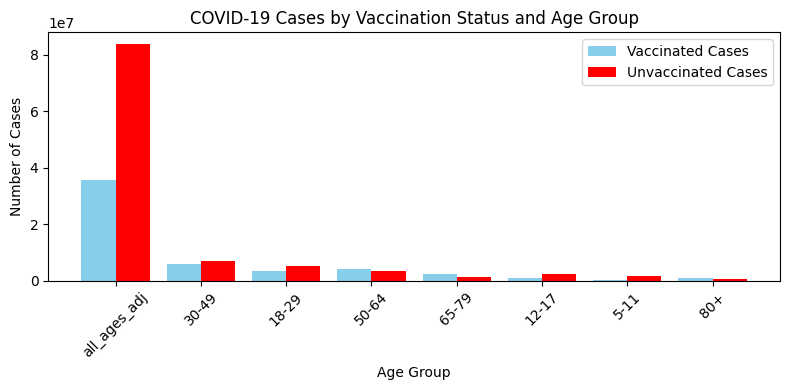

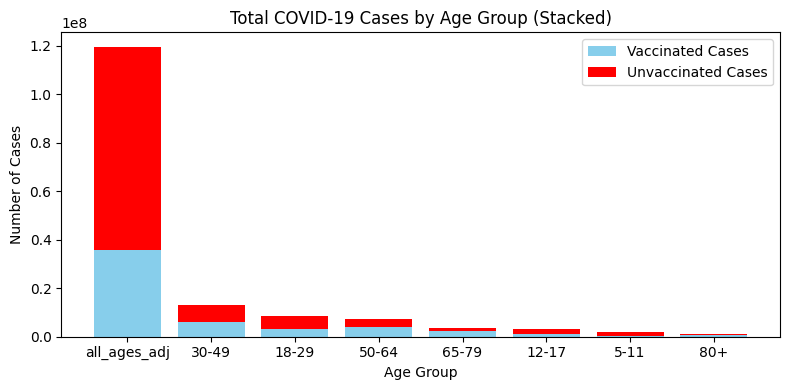

In [16]:
# Define Data for vizualization
data = {
    "Age group": ["all_ages_adj", "30-49", "18-29", "50-64", "65-79", "12-17", "5-11", "80+"],
    "Vaccinated_Cases": [35736157, 6037254, 3235323, 4071401, 2336144, 1064817, 374167, 758672],
    "Unvaccinated_Cases": [83788412, 6934922, 5060862, 3246103, 1365175, 2244912, 1687598, 407531],
    "Total_Cases": [119524569, 12972176, 8296185, 7317504, 3701319, 3309729, 2061765, 1166203],
}

df = pd.DataFrame(data)

# Set positions for bars
x = np.arange(len(df["Age group"]))

# Bar chart: Vaccinated vs. Unvaccinated Cases
plt.figure(figsize=(8, 4))
bar_width = 0.4
plt.bar(x - bar_width/2, df["Vaccinated_Cases"], width=bar_width, label="Vaccinated Cases", color="skyblue")
plt.bar(x + bar_width/2, df["Unvaccinated_Cases"], width=bar_width, label="Unvaccinated Cases", color="red")
plt.xticks(x, df["Age group"], rotation=45)
plt.xlabel("Age Group")
plt.ylabel("Number of Cases")
plt.title("COVID-19 Cases by Vaccination Status and Age Group")
plt.legend()
plt.tight_layout()
plt.show()

# Total Cases
plt.figure(figsize=(8, 4))
plt.bar(df["Age group"], df["Vaccinated_Cases"], label="Vaccinated Cases", color="skyblue")
plt.bar(df["Age group"], df["Unvaccinated_Cases"], bottom=df["Vaccinated_Cases"], label="Unvaccinated Cases", color="red")
plt.xlabel("Age Group")
plt.ylabel("Number of Cases")
plt.title("Total COVID-19 Cases by Age Group (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()

**DISTRIBUTION OF Covid-19 CASES BY AGE GROUP BETWEEN VACCINATED AND UNVACCINATED**

In [17]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data2.db')

# Calculate deaths by age group using SQL query
query = """
SELECT 
    [Age group], 
    SUM(CASE WHEN outcome = 'death' THEN [Vaccinated with outcome] ELSE 0 END) AS Vaccinated_Deaths,
    SUM(CASE WHEN outcome = 'death' THEN [Unvaccinated with outcome] ELSE 0 END) AS Unvaccinated_Deaths,
    SUM(CASE WHEN outcome = 'death' THEN [Vaccinated with outcome] + [Unvaccinated with outcome] ELSE 0 END) AS Total_Deaths
FROM Covid_rates
GROUP BY [Age group]
ORDER BY Total_Deaths ASC;
"""

# Execute the query and load results into a DataFrame
deaths_by_age_group = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Convert the DataFrame to a list of lists for tabulate
##data = deaths_by_age_group.values.tolist()

# Define column headers
##headers = deaths_by_age_group.columns.tolist()

# Print the result using tabulate
print(tabulate(deaths_by_age_group, headers='keys', tablefmt='grid', showindex=False))

# Display the result using tabulate
#print(tabulate(data, headers=headers, tablefmt="grid"))

# Display the result
#print(deaths_by_age_group)

+--------------+---------------------+-----------------------+----------------+
| Age group    |   Vaccinated_Deaths |   Unvaccinated_Deaths |   Total_Deaths |
+==============+=====================+=======================+================+
| 5-11         |                   3 |                    46 |             49 |
+--------------+---------------------+-----------------------+----------------+
| 12-17        |                  27 |                   183 |            210 |
+--------------+---------------------+-----------------------+----------------+
| 18-29        |                 210 |                  2487 |           2697 |
+--------------+---------------------+-----------------------+----------------+
| 30-49        |                2277 |                 21013 |          23290 |
+--------------+---------------------+-----------------------+----------------+
| 50-64        |               10328 |                 49229 |          59557 |
+--------------+---------------------+--

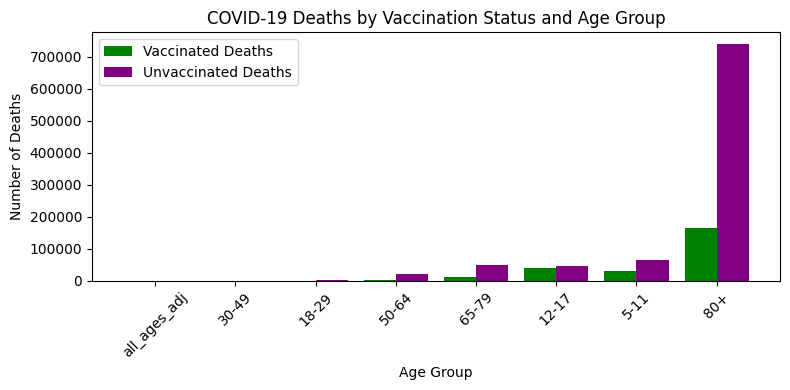

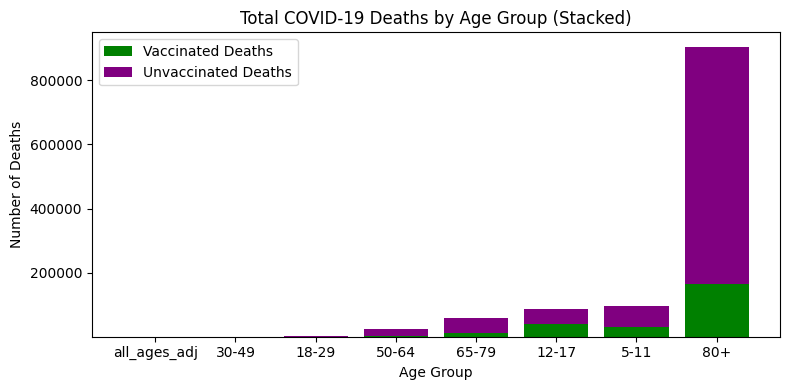

In [18]:
# Define Data for visualization
data = {
    "Age group": ["all_ages_adj", "30-49", "18-29", "50-64", "65-79", "12-17", "5-11", "80+"],
    "Vaccinated_Deaths": [3, 27, 210, 2277, 10328, 39438, 30248, 164958],
    "Unvaccinated_Deaths": [46, 183, 2487, 21013, 49229, 46355, 65686, 739996],
    "Total_Deaths": [49, 210, 2697, 23290, 59557, 85793, 95934, 904954],
}

df = pd.DataFrame(data)

# Set positions for bars
x = np.arange(len(df["Age group"]))

# Bar chart: Vaccinated vs. Unvaccinated Cases
plt.figure(figsize=(8, 4))
bar_width = 0.4
plt.bar(x - bar_width/2, df["Vaccinated_Deaths"], width=bar_width, label="Vaccinated Deaths", color="green")
plt.bar(x + bar_width/2, df["Unvaccinated_Deaths"], width=bar_width, label="Unvaccinated Deaths", color="purple")
plt.xticks(x, df["Age group"], rotation=45)
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("COVID-19 Deaths by Vaccination Status and Age Group")
plt.legend()
plt.tight_layout()
plt.show()

# Stacked Bar Chart: Total Cases
plt.figure(figsize=(8, 4))
plt.bar(df["Age group"], df["Vaccinated_Deaths"], label="Vaccinated Deaths", color="green")
plt.bar(df["Age group"], df["Unvaccinated_Deaths"], bottom=df["Vaccinated_Deaths"], label="Unvaccinated Deaths", color="purple")
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("Total COVID-19 Deaths by Age Group (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()

**Total COVID-19 deaths by vaccination status and age group.**

There is a disparity between vaccinated and unvaccinated populations.
About 905,000 deaths occurred across all age groups, with 82% (739,996) among unvaccinated individuals.
The 65-79 and 80+ age groups were at the highest death tolls (95,934 and 85,793 deaths, respectively), driven primarily by unvaccinated individuals.
Deaths among children and adolescents (5-11, and 12-17 years) were minimal, 259 deaths.
Summery (importance of vaccination): Deaths among vaccinated individuals were consistently lower across all age groups, 
reflecting vaccine effectiveness in reducing mortality.

**LEVEL OF TRANSMISSION BY DATE AND STATE**

**Regression models, correlation analysis, and hypothesis testing are used to find important patterns. 
The results are displayed using data visualizations such as bar charts, heat maps, and graphs. 
This analysis provides evidence for optimizing vaccination distribution and tailoring intervention strategies in eventual COVID-19 
    or other infectious disease outbreaks.**

['Winter' 'Spring' 'Summer' 'Fall']
   community_transmission_level  numeric_level
0                          high              4
4                           low              1
30                     moderate              2
73                  substantial              3
season                    Fall    Spring    Summer    Winter
state_name                                                  
Alabama               3.321544  3.321544  3.321544  3.321544
Alaska                2.839451  2.839451  2.839451  2.839451
Arizona               3.247467  3.247467  3.247467  3.247467
Arkansas              3.124147  3.124147  3.124147  3.124147
California            3.017534  3.017534  3.017534  3.017534
Colorado              2.978063  2.978063  2.978063  2.978063
Connecticut           3.237263  3.237263  3.237263  3.237263
Delaware              3.403000  3.403000  3.403000  3.403000
District of Columbia  3.283716  3.283716  3.283716  3.283716
Florida               3.222657  3.222657  3.222657  3.2226

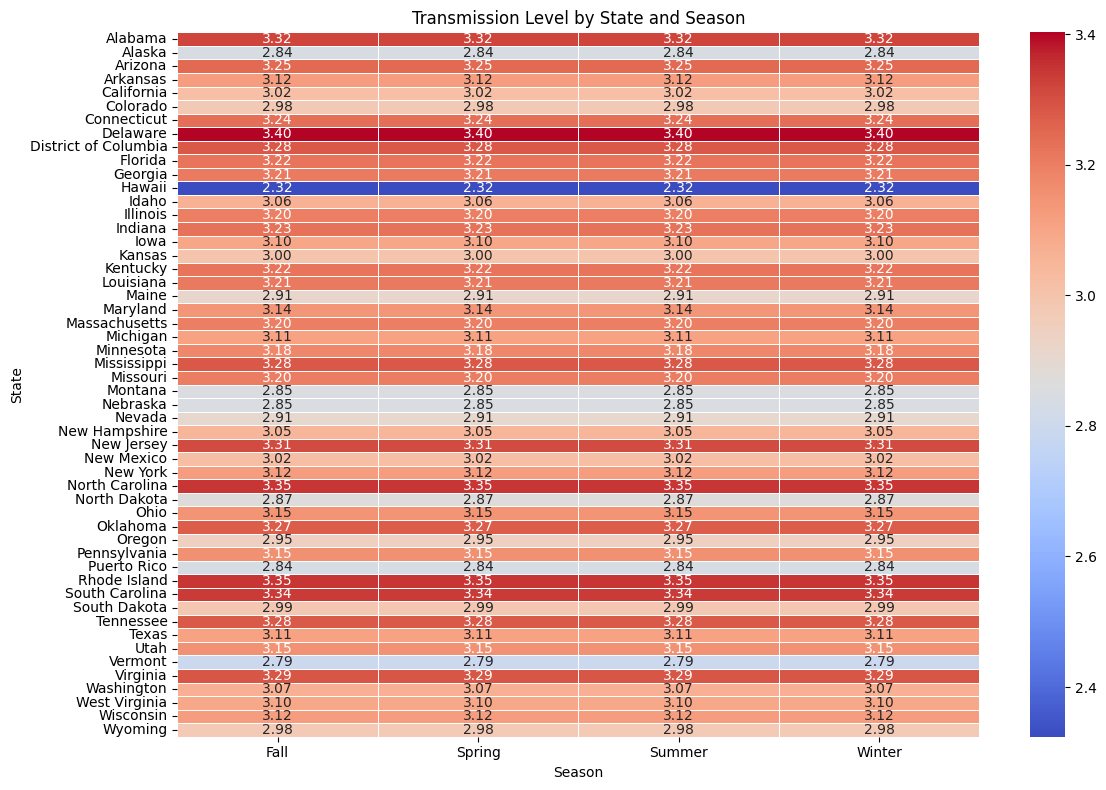

In [49]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')  # Replace with your database file name
query = """
SELECT
    date,
    state_name,
    community_transmission_level
FROM
    trans_level;
"""

#Load the query into a Pandas DataFrame
df_transmission = pd.read_sql_query(query, conn)

#Close the database connection
conn.close()

#Convert 'date' column to datetime
df_transmission['date'] = pd.to_datetime(df_transmission['date'])

# Create a copy of the data and add seasons manually
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
df_all_seasons = pd.concat([
    df_transmission.assign(season=season) for season in seasons
])
print(df_all_seasons['season'].unique())

#Map the transmission level to numeric values and create numeric_level column
level_map = {'low': 1, 'moderate': 2, 'substantial': 3, 'high': 4}
df_transmission['numeric_level'] = df_transmission['community_transmission_level'].map(level_map)
print(df_transmission[['community_transmission_level', 'numeric_level']].drop_duplicates())

#Calculate the Numeric Level by Season and State
#df_seasonal = df_all_seasons.groupby(['state_name', 'season'])['numeric_level'].mean().reset_index()
#print(df_seasonal)


#Create the Pivot table for Heatmap
heatmap_data = df_seasonal.pivot(index='state_name', columns='season', values='numeric_level')
print(heatmap_data)

#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True, fmt='.2f',
    linewidths=0.5, cbar=True, cmap='coolwarm',
    xticklabels=True, yticklabels=True
)
plt.title('Transmission Level by State and Season')
plt.xlabel('Season')
plt.ylabel('State')
plt.tight_layout()
plt.show()

The heatmap visualizes the average community transmission levels of COVID-19 across different U.S. states for all four seasons. Here's a breakdown of what the heatmap reveals:

Color Scale
Red Shades: Represent higher transmission levels, closer to "High" (numeric value = 4).
Blue Shades: Represent lower transmission levels, closer to "Low" (numeric value = 1).
Key Observations
Overall Transmission Levels:

Most states maintain relatively high transmission levels across all seasons, indicated by the dominant red-orange shades.
States like Connecticut, Delaware, and Georgia exhibit consistently higher transmission levels (close to 3.4) across all seasons.
Lowest Transmission States:

Hawaii and Vermont show consistently lower transmission levels (around 2.4 to 2.8). These states stand out in blue/gray shades, indicating lower levels of community transmission.
Seasonal Trends:

Transmission levels appear to be relatively stable across seasons for most states, with no significant seasonal spikes or drops.
This suggests that transmission levels might not be heavily influenced by seasonal factors in this dataset, or it could indicate uniform public health measures across seasons.
Regional Consistency:

States in the Northeast (e.g., Massachusetts, Rhode Island) and South (e.g., Florida, Georgia, South Carolina) show higher transmission levels.
Mountain West and Pacific states (e.g., Montana, Wyoming, Hawaii) tend to have lower average transmission levels.
Insights and Recommendations
Consistently High States: States with high average levels, such as Georgia, Connecticut, and Delaware, might benefit from enhanced public health measures, such as vaccination drives, mask mandates, or public awareness campaigns.
Relatively Low Transmission States: Hawaii and Vermont could provide case studies or best practices that other states could learn from to reduce transmission levels.
Future Analysis: Incorporate factors like population density, vaccination rates, and public health policies to better understand why transmission levels vary across states and seasons.
Let me know if you'd like a deeper dive into any specific pattern or state!







You’ve hit the Free plan limit for GPT-4o.
Responses will use another model until your li

In [ ]:
#convert date to datetime
df_transmission['date'] = pd.to_datetime(df_transmission['date'])

In [13]:
#function to map months to seasons
def get_season(date):
    if "month" in [12, 1, 2]:
        return 'Winter'
    elif "month" in [3, 4, 5]:
        return 'Spring'
    elif "month" in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [14]:
#Add a season column
df_transmission['season'] = df_transmission['date'].apply(get_season)

In [15]:
df_seasonal = df_transmission.groupby(['state_name', 'season'])['community_transmission_level'].sum().reset_index()

In [16]:
#Pivot the data for the heatmap
heatmap_data = df_seasonal.pivot(index='state_name', columns='season', values='community_transmission_level')

C:\Users\weare\AppData\Local\Temp\ipykernel_16516\2349098415.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(heatmap_data.applymap(lambda x: {'High': 4, 'Substantial': 3, 'Moderate': 2, 'Low': 1}.get(x, 0)),


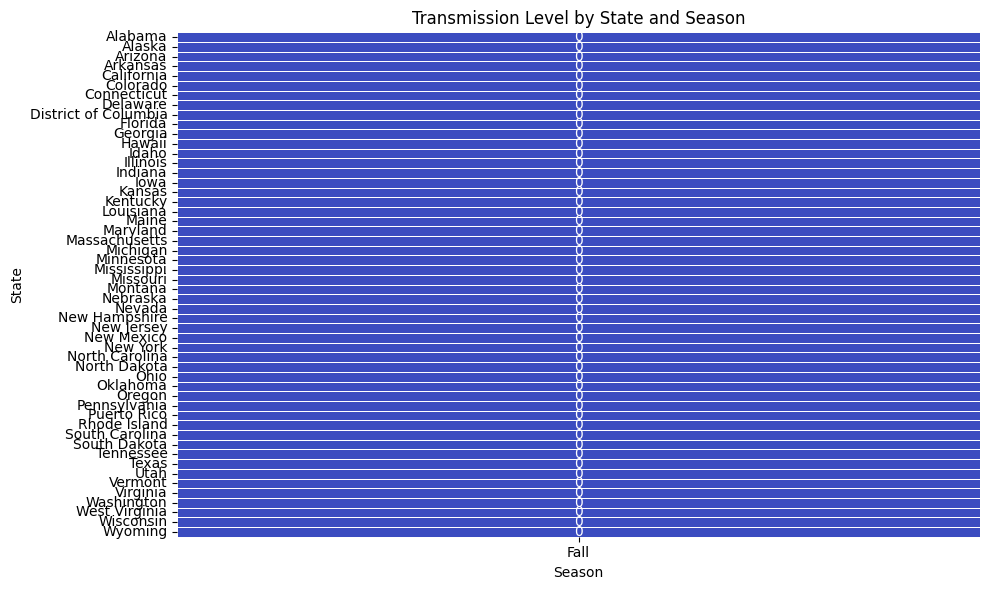

In [22]:
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.applymap(lambda x: {'High': 4, 'Substantial': 3, 'Moderate': 2, 'Low': 1}.get(x, 0)),
            annot=True, fmt='d', linewidths=0.5, cbar=False, cmap='coolwarm', xticklabels=True, yticklabels=True)

# Show the plot
plt.title('Transmission Level by State and Season')
plt.xlabel('Season')
plt.ylabel('State')
plt.tight_layout()
plt.show()

In [18]:
#create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="Y1GnBu", annot=True, fmt=".1f", linewidths=.5).applymap(lambda x: {'High': 4, 'Substantial': 3, 'Moderate': 2, 'Low': 1}.get(x, 0))
            #, cmap='coolwarm', cbar=True, xticklabels=True, yticklabels=True)

# Plot the heatmap
#plt.figure(figsize=(10, 8))
#sns.heatmap(
 #  annot=True,
  #  fmt='s',  # Show string categories in the cells
   #linewidths=0.5,
    #cbar=False,  # No color bar since we are using categorical data
#)

# Adjust the title and labels
plt.title('COVID-19 Transmission Levels by State and Season')  
plt.xlabel('Season')
plt.ylabel('State')
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: 'lowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighlowhighsubstantialhighhighhighhighmoderatehighlowmoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialmoderatehighmoderatelowlowmoderatehighsubstantialhighhighsubstantialsubstantialhighmoderatemoderatehighmoderatemoderatemoderatesubstantialmoderatesubstantialsubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantiallowmoderatemoderatesubstantialsubstantialsubstantialmoderatesubstantialsubstantialsubstantialsubstantialhighsubstantialmoderatehighmoderatemoderatemoderatesubstantialsubstantialsubstantialmoderatesubstantiallowlowhighsubstantialhighsubstantialhighhighsubstantiallowlowhighhighhighmoderatesubstantialhighhighhighmoderatemoderatelowsubstantialhighhighhighhighhighhighhighhighlowhighmoderatehighsubstantialhighhighsubstantialhighhighhighhighhighmoderatemoderatehighhighhighhighlowlowlowlowhighhighhighhighlowlowhighhighhighhighhighhighhighhighsubstantialmoderatemoderatelowhighhighhighhighhighmoderatehighhighsubstantialhighhighhighlowlowlowhighhighhighlowhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighlowhighhighhighhighmoderatesubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighlowlowlowhighhighhighhighhighhighlowmoderatehighhighhighhighhighsubstantiallowhighsubstantialhighhighhighhighhighlowlowmoderatehighhighhighhighhighlowhighhighlowmoderatelowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowmoderatelowlowlowlowlowlowlowhighlowsubstantiallowlowmoderatelowlowlowlowlowlowhighlowhighlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowhighlowlowlowlowlowsubstantiallowlowlowmoderatehighmoderatehighlowlowlowlowhighlowlowhighlowlowlowlowlowmoderatemoderatelowhighlowsubstantiallowlowlowmoderatelowmoderatelowlowhighlowmoderatesubstantiallowlowhighmoderatehighlowlowsubstantiallowlowlowhighhighlowlowmoderatemoderatelowhighlowlowhighmoderatelowmoderatelowlowlowlowhighlowsubstantiallowlowmoderatelowmoderatelowhighlowlowsubstantialmoderatelowlowlowhighsubstantialhighmoderatemoderatemoderatesubstantiallowsubstantiallowmoderatehighhighmoderatehighhighmoderatelowhighlowlowhighhighlowhighlowsubstantialhighlowmoderatesubstantialhighlowhighmoderatehighmoderatemoderatehighhighlowsubstantiallowlowmoderatehighlowlowhighlowmoderatehighsubstantialhighhighhighhighmoderatelowlowhighhighsubstantialhighlowhighmoderatehighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighmoderatehighhighhighhighmoderatelowmoderatehighmoderatehighhighhighhighhighmoderatehighsubstantialmoderatehighsubstantiallowhighlowhighmoderatehighhighhighhighhighmoderatemoderatehighmoderatehighhighhighmoderatemoderatesubstantialhighhighmoderatehighhighmoderatehighmoderatehighhighhighsubstantialmoderatehighhighmoderatehighsubstantialsubstantiallowhighhighhighhighmoderatehighhighhighmoderatelowmoderatehighhighhighhighmoderatehighmoderatehighhighhighhighhighhighhighhighhighhighsubstantialmoderatehighlowhighhighmoderatehighhighsubstantialmoderatesubstantialsubstantialhighhighlowlowhighlowmoderatelowsubstantialhighmoderatehighmoderatelowhighlowmoderatehighlowhighhighlowhighhighhighhighsubstantialsubstantialmoderatehighmoderatehighhighhighhighhighhighhighmoderatemoderatehighlowhighmoderatemoderatesubstantiallowlowlowhighmoderatemoderatemoderatehighmoderatesubstantialmoderatehighmoderatemoderatemoderatesubstantialhighhighhighsubstantialhighsubstantialhighmoderatelowhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighlowhighsubstantialhighhighhighmoderatehighmoderatemoderatesubstantialhighhighmoderatemoderatemoderatesubstantialhighhighhighhighhighmoderatehighhighmoderatehighsubstantialhighmoderatesubstantialhighsubstantialsubstantiallowhighhighhighhighhighhighhighmoderatehighmoderatehighhighmoderatehighhighmoderatemoderatehighhighlowmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighsubstantialsubstantialhighhighmoderatemoderatehighhighhighsubstantialhighsubstantialhighmoderatehighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighmoderatehighhighmoderatesubstantialhighhighhighsubstantialhighhighsubstantialsubstantialhighhighsubstantialsubstantialhighsubstantialhighhighhighhighmoderatesubstantialhighsubstantialhighhighsubstantialhighhighhighhighmoderatehighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighsubstantialhighsubstantialhighmoderatehighhighhighhighhighhighhighmoderatehighsubstantialmoderatehighhighhighhighmoderatemoderatehighhighhighhighhighhighsubstantialsubstantialsubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighmoderatemoderatehighhighhighhighhighhighsubstantialsubstantialhighhighhighhighmoderatehighhighmoderatesubstantialhighhighhighhighhighsubstantialsubstantialhighsubstantialsubstantialhighmoderatehighmoderatehighhighhighmoderatehighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighmoderatemoderatehighsubstantialhighmoderatesubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialsubstantialmoderatehighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighmoderatehighhighhighhighhighsubstantialsubstantialsubstantialhighhighsubstantialhighhighhighhighhighmoderatesubstantialhighmoderatesubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighsubstantialmoderatesubstantialsubstantialhighhighhighsubstantialhighhighhighmoderatehighhighhighsubstantialhighhighhighmoderatesubstantialsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialmoderatesubstantialhighhighhighhighhighmoderatesubstantialhighhighhighhighhighsubstantialmoderatesubstantialmoderatehighhighhighhighhighhighsubstantialhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighsubstantialmoderatehighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighmoderatehighhighhighhighhighsubstantialhighsubstantialsubstantialhighhighhighhighmoderatehighsubstantialhighsubstantialsubstantialhighhighhighmoderatemoderatehighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighsubstantialsubstantialhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighsubstantialhighsubstantialhighhighsubstantialhighsubstantialhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighsubstantialhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatehighhighmoderatehighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighmoderatehighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighmoderatehighhighhighsubstantialhighhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighmoderatehighsubstantialhighsubstantialhighhighsubstantialhighhighhighhighhighhighmoderatesubstantialhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighsubstantialsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighsubstantialhighsubstantialhighhighhighhighsubstantialhighhighhighsubstantialsubstantialsubstantialhighhighmoderatesubstantialsubstantialmoderatehighsubstantialhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighsubstantialhighhighhighhighhighmoderatesubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighmoderatehighsubstantialhighhighhighsubstantialhighhighsubstantialsubstantialhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighmoderatehighhighhighhighmoderatehighsubstantialhighhighsubstantialsubstantialmoderatesubstantialmoderatehighmoderatesubstantialsubstantialmoderatehighhighmoderatehighmoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatelowmoderatesubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialsubstantialmoderatesubstantiallowmoderatesubstantialmoderatesubstantialhighmoderatemoderatemoderatesubstantialsubstantialmoderatehighmoderatehighhighmoderatesubstantialsubstantialsubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatesubstantiallowsubstantialhighsubstantialsubstantialmoderatehighhighhighmoderatemoderatesubstantialsubstantialhighmoderatemoderatesubstantialsubstantiallowsubstantialsubstantialsubstantialsubstantialhighsubstantialmoderatesubstantialsubstantialsubstantialmoderatemoderatemoderatemoderatesubstantialhighsubstantiallowsubstantialmoderatehighhighmoderatehighsubstantialhighhighmoderatemoderatehighhighsubstantialmoderatehighsubstantialhighmoderatesubstantialsubstantialhighhighhighhighhighsubstantialhighsubstantialsubstantialmoderatehighhighhighhighmoderatesubstantiallowsubstantialhighmoderatesubstantialmoderatesubstantialsubstantialhighhighsubstantialhighsubstantialsubstantialhighlowmoderatehighhighsubstantialhighsubstantialhighmoderatelowhighmoderatemoderatemoderatehighsubstantialhighsubstantialhighhighmoderatesubstantialhighmoderatemoderatemoderatehighsubstantialmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatemoderatemoderatehighsubstantialsubstantialmoderatesubstantialsubstantialmoderatesubstantialsubstantialmoderatehighmoderatehighmoderatemoderatemoderatelowmoderatemoderatemoderatemoderatehighmoderatemoderatehighmoderatemoderatehighhighmoderatehighsubstantialhighmoderatemoderatemoderatemoderatesubstantialhighhighsubstantialmoderatehighmoderatelowmoderatelowmoderatemoderatehighmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatelowmoderatesubstantialsubstantialsubstantialsubstantialmoderatemoderatehighlowsubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatehighmoderatelowmoderatemoderatemoderatemoderatemoderatehighmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialhighmoderatemoderatesubstantialsubstantialmoderatemoderatelowmoderatemoderatemoderatemoderatesubstantialmoderatemoderatelowmoderatemoderatemoderatelowlowsubstantialhighsubstantialsubstantialmoderatemoderatemoderatehighmoderatehighsubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialmoderatemoderatehighsubstantialhighmoderatemoderatelowmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatelowsubstantialsubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatehighmoderatemoderatemoderatesubstantialmoderatemoderatelowmoderatelowsubstantialmoderatelowmoderatemoderatelowsubstantialmoderatesubstantialmoderatehighhighmoderatemoderatehighlowsubstantialsubstantialmoderatemoderatesubstantialmoderatehighlowmoderatelowhighlowmoderatehighmoderatelowsubstantiallowmoderatemoderatelowlowmoderatelowmoderatehighmoderatemoderatemoderatelowlowmoderatemoderatelowmoderatemoderatemoderatemoderatelowsubstantialmoderatemoderatemoderatemoderatemoderatelowmoderatesubstantialmoderatesubstantialmoderatemoderatemoderatelowmoderatelowmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatelowmoderatemoderatelowmoderatemoderatelowmoderatehighhighlowhighmoderatelowlowmoderatemoderatesubstantialsubstantialsubstantialmoderatelowhighmoderatehighmoderatemoderatelowmoderatelowmoderatelowhighsubstantiallowmoderatesubstantialmoderatelowlowmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatehighhighmoderatemoderatelowlowmoderatemoderatehighsubstantialmoderatelowlowlowlowmoderatehighmoderatemoderatehighhighmoderatelowhighmoderatemoderatemoderatemoderatemoderatehighmoderatemoderatemoderatemoderatehighlowhighhighlowhighmoderatemoderatemoderatemoderatemoderatemoderatemoderatehighlowsubstantialmoderatelowsubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatehighlowmoderatelowhighhighhighmoderatehighmoderatesubstantialmoderatemoderatemoderatemoderatehighmoderatemoderatemoderatemoderatelowlowlowsubstantialsubstantialhighhighhighmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatesubstantialhighsubstantialmoderatemoderatemoderatehighhighmoderatemoderatemoderatelowhighhighsubstantiallowhighsubstantialhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighsubstantialsubstantialhighsubstantialhighsubstantialmoderatesubstantialmoderatesubstantialhighsubstantialhighsubstantialmoderatehighlowsubstantialsubstantialhighsubstantialhighhighhighmoderatesubstantialsubstantialhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialmoderatehighhighhighsubstantialhighhighhighhighhighhighhighmoderatesubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighmoderatehighhighhighsubstantialsubstantialhighhighsubstantialsubstantialhighsubstantialhighmoderatemoderatehighhighhighhighhighhighhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighmoderatehighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighsubstantialmoderatehighhighhighmoderatehighhighlowsubstantialsubstantialmoderatehighhighsubstantialhighhighsubstantialsubstantialmoderatemoderatemoderatemoderatemoderatehighlowsubstantialsubstantialhighsubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialhighhighsubstantialsubstantialsubstantialhighsubstantialmoderatehighsubstantialsubstantialmoderatesubstantialmoderatehighhighhighhighhighmoderatehighhighhighhighhighsubstantialmoderatemoderatesubstantialhighmoderatehighmoderatemoderatemoderatesubstantialmoderatesubstantialhighhighhighsubstantialsubstantialhighsubstantialhighhighsubstantialmoderatesubstantialsubstantialhighmoderatehighsubstantialhighsubstantialmoderatesubstantialhighsubstantialsubstantialhighmoderatehighmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialhighhighsubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatesubstantialhighhighhighsubstantialsubstantialsubstantialsubstantialsubstantialhighmoderatemoderatesubstantialhighmoderatehighhighsubstantialhighsubstantialsubstantiallowmoderatehighsubstantialsubstantialsubstantialsubstantialmoderatesubstantialmoderatelowhighmoderatesubstantialmoderatesubstantialmoderatesubstantialmoderatemoderatehighhighhighsubstantialmoderatemoderatemoderatehighhighsubstantiallowmoderatemoderatemoderatehighsubstantialmoderatelowmoderatemoderatehighhighsubstantialsubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialsubstantialsubstantialsubstantialhighmoderatehighmoderatemoderatesubstantialsubstantialmoderatemoderatehighmoderatesubstantialsubstantialsubstantialhighhighhighhighsubstantialhighmoderatesubstantialsubstantialsubstantialmoderatehighhighhighhighmoderatehighsubstantialmoderatehighsubstantialsubstantialhighhighhighlowsubstantialsubstantialhighsubstantialmoderatemoderatesubstantialhighhighhighhighhighhighsubstantialsubstantialhighhighsubstantialsubstantialhighhighhighhighhighsubstantialmoderatemoderatehighhighhighhighsubstantialhighhighhighhighmoderatehighmoderatesubstantialhighsubstantialhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialmoderatemoderatemoderatesubstantialmoderatehighsubstantialhighhighhighhighsubstantialhighhighhighhighmoderatesubstantialmoderatesubstantialsubstantiallowmoderatehighsubstantialhighhighsubstantialhighhighmoderatehighhighhighsubstantialmoderatesubstantialhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighmoderatehighsubstantialhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighmoderatehighhighhighhighsubstantialhighhighmoderatehighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialsubstantialhighmoderatesubstantialmoderatehighhighsubstantialsubstantialsubstantialsubstantialhighhighhighhighhighhighhighmoderatehighsubstantialsubstantialmoderatesubstantialhighhighmoderatesubstantialmoderatehighhighmoderatemoderatemoderatehighsubstantialhighsubstantialhighmoderatehighhighmoderatemoderatemoderatesubstantialhighsubstantialmoderatehighhighsubstantialsubstantialmoderatehighhighsubstantialhighmoderatehighsubstantialhighsubstantialmoderatesubstantialsubstantialsubstantialhighhighsubstantialhighhighmoderatehighmoderatehighsubstantialhighsubstantialsubstantialhighsubstantialhighsubstantialsubstantialsubstantialsubstantialmoderatesubstantialmoderatehighmoderatehighsubstantialsubstantialhighhighsubstantialmoderatehighmoderatesubstantialhighhighmoderatesubstantialhighsubstantialhighsubstantialhighmoderatehighmoderatehighsubstantialhighsubstantialsubstantialsubstantialsubstantialmoderatehighmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantiallowsubstantialmoderatemoderatemoderatemoderatesubstantialhighmoderatemoderatemoderatemoderatelowmoderatelowmoderatemoderatesubstantialhighmoderatemoderatemoderatemoderatemoderatemoderatehighhighsubstantialmoderatemoderatemoderatehighmoderatemoderatemoderatelowsubstantiallowmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialhighmoderatesubstantialmoderatelowmoderatehighmoderatemoderatelowlowmoderatemoderatemoderatesubstantialmoderatehighmoderatemoderatemoderatesubstantialmoderatesubstantialsubstantialmoderatemoderatehighmoderatesubstantialmoderatemoderatemoderatelowmoderatehighmoderatemoderatemoderatelowsubstantialsubstantialmoderatemoderatelowlowmoderatemoderatemoderatemoderatemoderatesubstantialmoderatehighmoderatemoderatehighsubstantialmoderatehighmoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatemoderatelowlowsubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatehighmoderatemoderatesubstantialsubstantialmoderatelowhighmoderatelowmoderatemoderatemoderatemoderatemoderatemoderatelowlowmoderatemoderatemoderatemoderatemoderatesubstantiallowmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatemoderatelowmoderatesubstantialsubstantialmoderatemoderatemoderatelowlowmoderatelowmoderatesubstantialmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatehighhighhighsubstantialmoderatelowmoderatesubstantialhighlowhighmoderatehighmoderatemoderatemoderatelowhighmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowhighmoderatehighmoderatehighhighmoderatelowsubstantialmoderatelowsubstantiallowsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatesubstantialhighsubstantialmoderatesubstantialmoderatemoderatehighhighmoderatehighsubstantialmoderatehighhighsubstantialmoderatemoderatemoderatehighhighhighmoderatehighmoderatemoderatelowmoderatelowsubstantialmoderatesubstantialsubstantiallowmoderatehighmoderatesubstantialsubstantiallowsubstantialhighlowmoderatehighlowmoderatesubstantiallowmoderatelowmoderatelowmoderatehighlowhighhighmoderatemoderatelowhighmoderatehighsubstantialhighlowmoderatemoderatemoderatemoderatesubstantiallowmoderatehighmoderatelowmoderatemoderatemoderatelowlowhighmoderatesubstantialmoderatehighmoderatesubstantialhighmoderatelowmoderatehighhighsubstantialmoderatelowmoderatehighhighmoderatemoderatehighlowmoderatelowmoderatelowlowmoderatemoderatemoderatesubstantialsubstantialhighmoderatehighhighmoderatemoderatemoderatehighmoderatemoderatemoderatesubstantialhighhighlowlowhighsubstantialmoderatelowmoderatelowhighmoderatelowhighmoderatesubstantialmoderatemoderatemoderatemoderatehighmoderatelowsubstantialmoderatelowmoderatemoderatemoderatemoderatehighlowmoderatelowmoderatemoderatelowhighlowmoderatemoderatelowmoderatelowmoderatemoderatelowlowmoderatelowhighmoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatelowlowmoderatelowmoderatemoderatemoderatemoderatehighhighhighhighhighhighsubstantialmoderatelowsubstantiallowlowmoderatelowlowlowlowmoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatesubstantiallowlowlowhighmoderatemoderatelowlowmoderatelowmoderatelowlowmoderatelowmoderatehighmoderatemoderatemoderatemoderatemoderatelowmoderatemoderatelowmoderatehighlowlowmoderatemoderatelowsubstantiallowlowlowhighmoderatemoderatelowmoderatelowsubstantiallowlowlowmoderatelowmoderatelowmoderatemoderatehighmoderatelowmoderatelowmoderatelowlowlowmoderatemoderatemoderatemoderatelowmoderatelowmoderatemoderatesubstantiallowlowmoderatemoderatelowmoderatelowsubstantialmoderatelowmoderatelowmoderatelowmoderatemoderatemoderatelowsubstantialmoderatelowmoderatelowmoderatesubstantialmoderatemoderatemoderatemoderatemoderatelowlowmoderatemoderatelowmoderatemoderatelowlowmoderatesubstantialmoderatemoderatelowmoderatemoderatelowmoderatemoderatesubstantialmoderatemoderatelowmoderatemoderatemoderatelowsubstantialhighlowmoderatesubstantiallowmoderatemoderatemoderatelowlowmoderatelowlowsubstantialmoderatemoderatemoderatelowsubstantialmoderatemoderatelowlowmoderatemoderatelowsubstantiallowmoderatehighlowmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatelowsubstantialmoderatelowlowmoderatelowmoderatemoderatemoderatelowmoderatemoderatelowlowmoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatehighmoderatemoderatesubstantialmoderatemoderatemoderatemoderatelowmoderatehighlowmoderatelowmoderatelowsubstantialmoderatesubstantiallowlowmoderatelowmoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatesubstantialmoderatelowhighhighmoderatemoderatemoderatemoderatemoderatelowmoderatelowlowmoderatemoderatehighsubstantialsubstantialmoderatehighlowmoderatelowhighsubstantialmoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatelowmoderatemoderatesubstantiallowhighsubstantialmoderatemoderatelowmoderatemoderatemoderatemoderatelowlowmoderatelowlowmoderatemoderatelowmoderatemoderatemoderatelowmoderatemoderatemoderatehighlowhighmoderatehighlowmoderatesubstantialmoderatehighsubstantialmoderatemoderatesubstantiallowlowmoderatemoderatesubstantialmoderatemoderatemoderatehighhighhighlowmoderatesubstantialmoderatemoderatemoderatehighmoderatelowmoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowlowsubstantialmoderatemoderatesubstantialmoderatelowmoderatemoderatelowlowlowmoderatemoderatesubstantialmoderatemoderatelowlowmoderatesubstantiallowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialsubstantiallowmoderatelowmoderatemoderatemoderatemoderatelowmoderatelowmoderatelowlowmoderatesubstantialmoderatemoderatelowmoderatesubstantialmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatelowsubstantialmoderatemoderatemoderatemoderatelowsubstantialmoderatelowlowmoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialsubstantiallowmoderatemoderatelowhighsubstantialmoderatemoderatemoderatemoderatemoderatesubstantiallowlowlowsubstantiallowmoderatesubstantialsubstantialmoderatelowsubstantialsubstantialmoderatemoderatelowhighsubstantialmoderatemoderatesubstantiallowhighlowsubstantialmoderatemoderatesubstantialhighmoderatemoderatemoderatemoderatehighsubstantiallowhighmoderatemoderatemoderatehighsubstantialmoderatemoderatemoderatemoderatelowmoderatemoderatehighsubstantialsubstantialmoderatesubstantialsubstantialhighsubstantialsubstantialsubstantialmoderatemoderatelowmoderatesubstantiallowmoderatemoderatehighsubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatelowmoderatehighmoderatesubstantialhighmoderatemoderatehighmoderatemoderatesubstantialhighmoderatemoderatelowmoderatemoderatemoderatesubstantialmoderatehighmoderatehighsubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatesubstantialhighhighhighsubstantialhighsubstantialmoderatesubstantiallowhighmoderatehighmoderatemoderatesubstantialhighmoderatesubstantialsubstantialhighmoderatemoderatemoderatesubstantialhighlowmoderatemoderatesubstantialmoderatesubstantialsubstantialsubstantialmoderatemoderatelowmoderatehighhighhighhighhighhighhighsubstantialhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighsubstantialhighmoderatehighhighsubstantialhighhighhighsubstantialmoderatehighhighsubstantialsubstantialmoderatehighsubstantialhighhighsubstantialsubstantialsubstantialhighmoderatehighhighsubstantialhighhighhighhighhighsubstantialhighhighsubstantialhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialmoderatehighhighsubstantialsubstantialsubstantialsubstantialhighsubstantialsubstantialhighhighhighmoderatehighhighhighhighhighsubstantialsubstantialhighhighsubstantialmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatesubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighhighmoderatehighsubstantialsubstantialhighhighhighhighhighsubstantialsubstantialhighsubstantialsubstantialsubstantialmoderatemoderatemoderatemoderatehighhighmoderatesubstantialmoderatesubstantialsubstantialmoderatemoderatehighsubstantialhighsubstantialsubstantialmoderatesubstantialsubstantialhighlowmoderatesubstantialsubstantialsubstantialhighhighmoderatemoderatemoderatehighhighsubstantialsubstantialhighsubstantialhighhighhighmoderatehighhighhighhighhighhighsubstantialhighmoderatehighsubstantialhighsubstantialsubstantialsubstantialmoderatehighsubstantialmoderatelowlowmoderatesubstantialmoderatemoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowlowhighhighhighhighhighhighhighhighhighhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowhighlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowhighlowlowlowmoderatelowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowsubstantialmoderatehighlowlowlowlowlowhighlowlowlowlowmoderatelowlowmoderatelowlowlowlowlowlowlowlowlowlowlowhighlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighsubstantialmoderatemoderatehighlowhighlowlowlowlowsubstantiallowhighhighsubstantiallowhighlowhighlowmoderatesubstantialhighmoderatesubstantiallowhighhighlowmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatelowhighlowlowhighhighlowmoderatelowhighhighsubstantialmoderatehighlowlowlowmoderatehighsubstantialmoderatelowlowsubstantialsubstantialhighhighhighhighmoderatehighlowmoderatemoderatemoderatesubstantialsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighmoderatehighhighmoderatelowhighlowmoderatemoderatehighhighhighhighmoderatehighhighlowhighhighhighmoderatehighhighhighhighmoderatesubstantialhighhighmoderatemoderatehighmoderatehighhighlowhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighlowsubstantialhighhighhighhighsubstantialhighhighhighhighhighmoderatesubstantialhighhighsubstantialhighmoderatehighmoderatehighhighhighhighhighmoderatemoderatemoderatehighhighmoderatehighsubstantialhighhighhighhighhighmoderatemoderatehighhighhighsubstantialhighhighhighsubstantialhighhighhighsubstantialmoderatelowmoderatesubstantialhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighmoderatehighlowhighsubstantialhighmoderatehighhighhighhighmoderatehighhighhighhighhighsubstantialhighhighhighhighmoderatelowhighmoderatehighmoderatehighhighhighhighhighhighsubstantiallowhighhighmoderatemoderatelowlowmoderatehighhighlowhighlowmoderatemoderatemoderatehighhighhighsubstantialhighmoderatesubstantiallowsubstantialmoderatehighhighhighmoderatemoderatehighhighsubstantialhighlowlowhighmoderatehighmoderatelowmoderatelowmoderatemoderatehighhighmoderatehighhighsubstantialhighmoderatemoderatelowhighlowhighmoderatemoderatehighhighsubstantialhighhighmoderatehighhighsubstantiallowhighmoderatelowhighmoderatehighmoderatemoderatehighlowhighsubstantialmoderatesubstantialhighhighhighhighhighhighmoderatemoderatesubstantialhighmoderatesubstantialhighlowlowmoderatemoderatelowhighmoderatemoderatelowhighhighhighsubstantiallowmoderatesubstantialhighhighhighlowmoderatemoderatehighsubstantialmoderatelowlowhighhighmoderatehighhighhighmoderatehighlowhighhighhighmoderatehighmoderatemoderatehighsubstantialsubstantialmoderatehighhighlowhighhighmoderatelowmoderatehighhighsubstantialhighmoderatemoderatehighlowhighlowmoderatemoderatehighhighhighmoderatehighhighhighsubstantiallowmoderatehighhighhighlowlowhighmoderatehighsubstantialhighhighhighhighhighhighhighmoderatemoderatehighmoderatehighmoderatelowmoderatehighhighsubstantialhighhighmoderatehighlowmoderatesubstantialhighhighhighmoderatemoderatelowhighlowmoderatemoderatehighmoderatemoderatelowmoderatemoderatehighhighsubstantialhighhighhighmoderatehighmoderatemoderatehighhighmoderatelowhighhighlowhighhighhighmoderatehighhighsubstantialmoderatemoderatemoderatehighmoderatemoderatehighhighhighmoderatehighhighmoderatesubstantialhighhighhighhighmoderatelowhighlowhighhighhighmoderatesubstantialmoderatelowhighmoderatelowmoderatehighmoderatelowmoderatemoderatelowhighlowlowhighhighhighmoderatehighhighhighmoderatehighhighmoderatesubstantialhighhighmoderatehighmoderatehighsubstantialhighmoderatehighhighhighhighhighmoderatemoderatemoderatehighlowhighlowsubstantialhighhighmoderatesubstantialhighmoderatehighmoderatehighmoderatehighsubstantialhighhighmoderatemoderatesubstantialmoderatemoderatehighhighmoderatelowmoderatelowhighmoderatehighsubstantialmoderatehighmoderatehighhighmoderatelowhighlowmoderatemoderatemoderatelowhighhighhighhighhighmoderatehighmoderatemoderatehighhighmoderatehighhighlowhighhighhighmoderatemoderatesubstantialmoderatemoderatehighhighhighlowhighmoderatemoderatehighhighhighhighlowlowhighhighsubstantialhighlowmoderatehighhighhighsubstantialhighmoderatehighsubstantialmoderatehighmoderatehighsubstantialhighhighhighsubstantialhighsubstantialmoderatehighsubstantialhighhighhighmoderatehighsubstantialmoderatesubstantialsubstantialhighmoderatehighsubstantialhighhighsubstantialmoderatehighmoderatemoderatesubstantialhighhighhighhighhighhighhighhighmoderatehighhighsubstantialhighmoderatehighhighhighmoderatemoderatehighhighhighhighhighmoderatemoderatehighmoderatemoderatehighhighmoderatemoderatehighmoderatemoderatehighmoderatemoderatesubstantialhighhighhighsubstantialhighhighhighmoderatemoderatehighhighhighmoderatesubstantialhighmoderatehighhighmoderatehighhighhighhighhighmoderatehighmoderatehighsubstantialhighsubstantialhighhighmoderatehighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighmoderatehighsubstantialsubstantialhighmoderatemoderatehighmoderatehighhighmoderatesubstantialhighhighhighhighhighhighsubstantialsubstantialhighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighmoderatehighmoderatemoderatesubstantialhighsubstantialsubstantialmoderatehighhighhighmoderatehighmoderatehighhighhighhighhighhighmoderatehighhighmoderatehighhighhighhighhighhighhighhighsubstantialhighmoderatemoderatemoderatesubstantialhighmoderatesubstantialhighhighhighhighmoderatesubstantialhighsubstantialhighmoderatehighmoderatehighhighhighhighhighsubstantialhighhighhighmoderatehighhighmoderatehighhighhighhighhighhighmoderatehighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighsubstantialhighhighmoderatesubstantialsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighsubstantialhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighhighsubstantialhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighsubstantialhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighsubstantialsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialsubstantialmoderatehighhighhighhighhighhighhighsubstantialsubstantialsubstantialhighhighhighsubstantialhighmoderatehighsubstantialhighsubstantialsubstantialhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighsubstantialhighsubstantialmoderatehighhighhighhighhighsubstantialhighmoderatehighhighsubstantialsubstantialsubstantialhighsubstantialmoderatehighhighhighhighhighmoderatehighhighsubstantialsubstantialsubstantialhighsubstantialhighhighsubstantialhighsubstantialhighsubstantialhighhighsubstantialhighhighmoderatesubstantialhighsubstantialhighhighsubstantialsubstantialhighsubstantialsubstantialhighhighhighsubstantialsubstantialmoderatesubstantialsubstantialhighsubstantialhighhighhighhighsubstantialhighsubstantialhighmoderatehighhighhighhighmoderatehighhighsubstantialsubstantialhighhighhighhighhighhighmoderatehighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighmoderatesubstantialsubstantialhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighmoderatehighhighhighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighsubstantialsubstantialhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighsubstantialhighmoderatehighhighhighhighsubstantialhighsubstantialmoderatehighhighhighhighhighmoderatehighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighsubstantialsubstantialsubstantialhighmoderatehighhighhighsubstantialhighmoderatehighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighmoderatehighhighhighhighhighsubstantialhighmoderatemoderatehighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighmoderatesubstantialsubstantialsubstantiallowsubstantialhighhighsubstantialsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighhighsubstantialmoderatehighhighsubstantialsubstantialhighhighmoderatehighhighhighhighsubstantialhighhighsubstantialhighhighmoderatehighhighhighsubstantialhighhighhighsubstantialhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighsubstantialhighhighhighsubstantialmoderatesubstantialmoderatehighhighmoderatesubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialsubstantialmoderatesubstantialhighsubstantialsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighmoderatehighhighsubstantialhighhighhighsubstantialhighsubstantialmoderatehighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighsubstantialsubstantialhighhighsubstantialsubstantialhighhighhighsubstantialhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatemoderatehighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighlowhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighmoderatehighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighhighsubstantialhighhighsubstantialhighhighmoderatehighhighhighhighhighhighhighhighhighsubstantialmoderatehighhighhighsubstantialhighsubstantialsubstantialsubstantialsubstantialhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighhighmoderatehighhighhighhighhighhighsubstantialhighmoderatehighhighhighsubstantialsubstantialhighhighhighmoderatehighhighhighhighsubstantialhighhighhighsubstantialhighsubstantialhighhighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighmoderatehighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighhighhighmoderatesubstantialsubstantialmoderatehighhighsubstantialhighhighhighsubstantialhighhighlowhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialsubstantialmoderatehighhighhighhighhighhighhighsubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialhighsubstantialmoderatemoderatesubstantiallowmoderatesubstantialsubstantialmoderatemoderatesubstantialmoderatelowmoderatemoderatesubstantialsubstantialsubstantialsubstantialhighsubstantialmoderatesubstantiallowsubstantialmoderatesubstantialsubstantialsubstantialmoderatelowmoderatemoderatemoderatesubstantialmoderatehighmoderatemoderatehighmoderatemoderatemoderatesubstantialsubstantialsubstantialsubstantialmoderatesubstantialhighhighmoderatemoderatehighsubstantialsubstantialmoderatelowsubstantialmoderatesubstantialmoderatesubstantialsubstantialsubstantialsubstantialsubstantialmoderatemoderatesubstantialsubstantialmoderatesubstantiallowmoderatelowmoderatemoderatehighhighsubstantialmoderatelowmoderatemoderatehighsubstantialhighmoderatelowhighmoderatemoderatemoderatelowhighmoderatemoderatelowmoderatemoderatemoderatesubstantialmoderatehighsubstantialmoderatemoderatemoderatemoderatehighsubstantialhighlowmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatesubstantiallowsubstantialmoderatesubstantiallowhighmoderatemoderatemoderatelowhighhighmoderatemoderatehighsubstantialmoderatemoderatesubstantialsubstantialmoderatemoderatesubstantialsubstantialhighlowmoderatemoderatesubstantialmoderatehighlowmoderatesubstantialmoderatesubstantialsubstantialhighmoderatemoderatesubstantialmoderatesubstantialsubstantialsubstantialsubstantialmoderatehighmoderatemoderatehighmoderatemoderatesubstantialsubstantialsubstantialhighhighsubstantialmoderatesubstantialhighlowmoderatehighhighmoderatelowmoderatehighsubstantialmoderatemoderatesubstantiallowsubstantialhighhighmoderatehighhighmoderatesubstantialsubstantialsubstantialsubstantialhighmoderatemoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatehighhighhighmoderatesubstantialsubstantialsubstantialmoderatesubstantialmoderatesubstantialhighhighhighhighsubstantialmoderatelowhighsubstantialsubstantialhighsubstantialmoderatesubstantialsubstantialmoderatemoderatemoderatemoderatemoderatesubstantialmoderatesubstantialhighmoderatehighmoderatemoderatesubstantialhighsubstantialhighsubstantialsubstantialsubstantialmoderatemoderatehighmoderatesubstantialsubstantialhighmoderatemoderatemoderatemoderatemoderatesubstantialhighsubstantialsubstantialmoderatesubstantialmoderatesubstantialhighmoderatemoderatemoderatemoderatesubstantialmoderatesubstantialhighhighsubstantialsubstantialmoderatemoderatesubstantialhighhighsubstantialmoderatehighmoderatehighmoderatesubstantiallowmoderatemoderatesubstantialsubstantialhighmoderatesubstantialhighmoderatemoderatehighsubstantialsubstantialsubstantialmoderatehighmoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialsubstantialmoderatehighsubstantialmoderatelowsubstantialmoderatemoderatehighsubstantialsubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatesubstantialmoderatelowhighmoderatemoderatesubstantialhighsubstantialmoderatemoderatelowsubstantialmoderatemoderatelowsubstantialsubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatesubstantialhighhighhighmoderatesubstantialmoderatemoderatemoderatehighhighmoderatehighlowmoderatemoderatemoderatemoderatesubstantialsubstantiallowsubstantialmoderatemoderatesubstantialsubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatehighhighmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatesubstantialmoderatesubstantiallowhighsubstantialmoderatemoderatehighsubstantiallowlowmoderatesubstantialsubstantialhighsubstantialhighmoderatehighhighmoderatemoderatemoderatelowlowmoderatelowmoderatemoderatehighhighsubstantialmoderatesubstantialmoderatemoderatemoderatemoderatesubstantialmoderatemoderatelowmoderatemoderatemoderatesubstantiallowhighsubstantialhighhighsubstantialsubstantialhighhighhighhighmoderatesubstantialmoderatesubstantialhighhighhighlowmoderatesubstantialhighsubstantialhighmoderatesubstantialsubstantialmoderatehighhighhighhighmoderatemoderatehighhighhighhighsubstantialmoderatesubstantialsubstantialhighhighmoderatehighhighhighmoderatehighhighhighhighlowhighsubstantialhighmoderatesubstantialsubstantialmoderatehighsubstantialhighsubstantialmoderatesubstantialhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighsubstantialhighsubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialsubstantialhighsubstantialhighsubstantialhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialsubstantialmoderatehighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighmoderatesubstantialhighhighhighhighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighsubstantialhighsubstantialsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatehighsubstantialsubstantialhighhighsubstantialhighmoderatesubstantialmoderatehighmoderatesubstantialhighsubstantialsubstantialhighhighmoderatemoderatemoderatehighmoderatehighsubstantialhighsubstantialsubstantialsubstantialhighsubstantialhighhighmoderatemoderatemoderatemoderatehighhighsubstantialmoderatehighsubstantialsubstantialhighsubstantialhighsubstantialmoderatesubstantialsubstantialhighhighmoderatehighsubstantialmoderatemoderatehighhighsubstantialhighmoderatesubstantialsubstantialhighmoderatemoderatesubstantialhighsubstantialsubstantialhighhighsubstantialhighhighsubstantialsubstantialhighsubstantialmoderatehighsubstantialmoderatemoderatehighmoderatesubstantialsubstantialmoderatehighsubstantialmoderatesubstantialmoderatesubstantialsubstantialsubstantialsubstantialhighhighmoderatemoderatemoderatehighmoderatehighsubstantialsubstantialhighsubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialhighsubstantialhighmoderatehighsubstantialsubstantiallowsubstantialhighsubstantialsubstantialhighlowsubstantialhighmoderatemoderatemoderatesubstantialmoderatemoderatesubstantialhighhighmoderatehighmoderatemoderatemoderatesubstantialhighmoderatesubstantialmoderatesubstantialsubstantialmoderatehighmoderatemoderatesubstantialmoderatemoderatemoderatemoderatehighmoderatemoderatesubstantialsubstantialhighmoderatesubstantialmoderatehighhighhighmoderatehighsubstantialsubstantialhighlowhighhighhighmoderatemoderatemoderatemoderatehighmoderatemoderatemoderatehighsubstantialmoderatehighhighsubstantialsubstantialhighhighhighsubstantialsubstantialsubstantialhighmoderatesubstantialsubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialhighlowmoderatesubstantialhighhighhighsubstantialmoderatesubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatesubstantialhighmoderatemoderatesubstantialmoderatesubstantialmoderatesubstantialhighmoderatehighsubstantialsubstantialsubstantialhighmoderatemoderatemoderatesubstantialmoderatehighmoderatesubstantialsubstantialmoderatehighmoderatemoderatelowhighhighhighhighhighmoderatesubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighmoderatehighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatemoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialmoderatesubstantialsubstantialhighsubstantialhighhighsubstantialhighsubstantialhighsubstantialsubstantialmoderatesubstantialhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialsubstantialhighmoderatehighsubstantialmoderatehighhighhighsubstantialsubstantialsubstantialhighhighsubstantialhighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialmoderatehighhighhighhighmoderatesubstantialmoderatemoderatehighhighmoderatemoderatesubstantialhighmoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatehighmoderatehighsubstantialsubstantialhighsubstantialsubstantialmoderatemoderatehighlowsubstantialhighmoderatesubstantialmoderatemoderatehighhighmoderatemoderatemoderatesubstantialmoderatemoderatemoderatehighhighmoderatemoderatemoderatemoderatesubstantialsubstantialhighmoderatemoderatesubstantialmoderatehighhighhighmoderatehighhighlowlowlowmoderatelowlowlowlowsubstantialmoderatemoderatelowhighlowmoderatelowmoderatemoderatemoderatesubstantialmoderatemoderatelowlowlowlowmoderatemoderatelowmoderatemoderatemoderatemoderatesubstantiallowlowlowmoderatemoderatemoderatehighlowmoderatemoderatemoderatehighlowmoderatemoderatemoderatehighmoderatemoderatelowmoderatelowmoderatemoderatehighmoderatelowhighlowmoderatemoderatelowmoderatelowlowmoderatelowhighmoderatelowmoderatelowlowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatemoderatehighmoderatemoderatemoderatelowlowlowlowmoderatelowmoderatemoderatemoderatemoderatelowmoderatelowlowlowmoderatemoderatemoderatelowmoderatemoderatesubstantiallowmoderatemoderatelowsubstantialsubstantiallowmoderatehighmoderatelowlowmoderatemoderatehighsubstantialmoderatelowlowmoderatemoderatemoderatehighlowmoderatemoderatemoderatemoderatehighhighmoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatemoderatelowhighlowmoderatehighhighmoderatelowhighmoderatemoderatesubstantialmoderatemoderatemoderatelowlowlowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatehighsubstantiallowlowmoderatemoderatehighlowmoderatemoderatelowlowsubstantiallowmoderatelowsubstantialmoderatemoderatelowsubstantialsubstantiallowsubstantialmoderatemoderatesubstantialmoderatehighmoderatemoderatehighlowmoderatesubstantialmoderatemoderatemoderatelowsubstantialmoderatehighmoderatesubstantialmoderatelowlowmoderatesubstantialmoderatemoderatesubstantiallowmoderatehighsubstantiallowmoderatemoderatelowmoderatemoderatelowmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatehighmoderatemoderatemoderatehighhighmoderatemoderatehighlowsubstantialsubstantialmoderatelowmoderatehighmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatemoderatelowmoderatemoderatelowlowmoderatehighlowlowsubstantialhighsubstantialhighmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatesubstantialmoderatemoderatesubstantialsubstantialhighmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatehighmoderatemoderatelowsubstantialmoderatemoderatesubstantialhighmoderatehighlowmoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatemoderatesubstantialsubstantiallowmoderatemoderatesubstantialmoderatemoderatemoderatemoderatehighlowsubstantialsubstantialhighmoderatemoderatehighmoderatemoderatesubstantialhighsubstantialhighmoderatemoderatelowmoderatesubstantialmoderatehighmoderatemoderatehighsubstantialsubstantialmoderatemoderatelowmoderatesubstantialmoderatemoderatemoderatemoderatehighhighmoderatemoderatehighsubstantialhighmoderatesubstantialsubstantialsubstantialmoderatemoderatesubstantialsubstantialhighsubstantialhighsubstantialsubstantialhighsubstantialsubstantialmoderatehighmoderatesubstantialsubstantialhighmoderatemoderatehighhighhighhighhighlowmoderatehighsubstantialsubstantialhighhighsubstantialmoderatemoderatemoderatesubstantialmoderatemoderatehighhighhighhighsubstantialmoderatehighlowmoderatelowmoderatesubstantialhighmoderatehighhighhighhighmoderatesubstantialsubstantialhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighhighmoderatemoderatehighmoderatehighmoderatehighsubstantialsubstantialhighhighsubstantialhighmoderatemoderatehighsubstantialmoderatesubstantialhighhighhighsubstantialsubstantialmoderatesubstantialsubstantialhighsubstantialhighhighhighhighhighhighsubstantialmoderatehighmoderatehighmoderatesubstantialhighsubstantialhighhighmoderatehighhighhighhighmoderatesubstantialsubstantialhighhighhighhighmoderatesubstantialhighsubstantialsubstantialhighmoderatesubstantialhighhighhighsubstantialhighhighhighhighhighsubstantialmoderatehighhighsubstantialhighmoderatesubstantialhighhighhighsubstantialsubstantialhighhighhighhighsubstantiallowsubstantialmoderatesubstantialhighmoderatesubstantialmoderatemoderatesubstantialhighmoderatehighmoderatehighhighhighsubstantialmoderatehighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighlowhighhighhighhighhighhighhighhighhighhighsubstantialhighhighmoderatehighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighsubstantialmoderatesubstantialsubstantialhighmoderatehighsubstantialmoderatehighhighsubstantialsubstantialhighsubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialhighsubstantialhighhighmoderatehighmoderatesubstantialsubstantialsubstantialsubstantialhighmoderatemoderatehighmoderatesubstantialmoderatemoderatesubstantialsubstantialsubstantialsubstantialsubstantialhighsubstantialsubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialhighhighsubstantialhighmoderatesubstantialsubstantialmoderatemoderatelowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowhighlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighmoderatelowlowmoderatelowsubstantiallowlowlowlowlowlowlowlowsubstantiallowlowlowhighlowlowlowlowlowhighhighlowmoderatelowlowmoderatelowlowlowlowlowhighlowmoderatelowsubstantiallowlowlowhighlowlowlowlowlowlowhighlowlowlowlowlowlowlowmoderatehighlowhighlowhighlowhighmoderatehighhighhighmoderatehighsubstantiallowhighmoderatelowlowsubstantialmoderatesubstantialhighmoderatesubstantiallowhighhighhighlowlowmoderatehighhighsubstantialhighhighlowmoderatemoderatesubstantialmoderatelowlowhighsubstantialhighsubstantiallowmoderatelowlowlowmoderatehighhighlowhighhighlowlowmoderatehighlowhighhighhighhighhighmoderatehighhighmoderatehighsubstantialmoderatehighhighhighhighmoderatehighhighmoderatelowhighhighhighhighhighsubstantialhighmoderatehighhighhighlowhighmoderatehighhighlowhighlowhighsubstantialhighsubstantialhighhighhighhighhighhighlowhighmoderatemoderatemoderatehighhighmoderatehighhighhighmoderatehighhighmoderatehighhighhighhighsubstantialhighhighhighhighlowmoderatehighhighhighhighhighhighhighhighlowhighhighhighlowhighhighhighlowhighhighmoderatehighhighhighhighmoderatemoderatehighhighhighmoderatehighhighlowhighhighhighmoderatehighmoderatehighmoderatehighhighhighmoderatehighsubstantialsubstantialhighsubstantialmoderatehighmoderatemoderatesubstantialmoderatehighlowmoderatelowhighhighhighmoderatesubstantialhighhighhighmoderatelowsubstantialhighmoderatehighsubstantialhighhighhighhighhighlowhighhighhighlowmoderatehighhighhighmoderatehighsubstantialhighhighhighhighmoderatehighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighmoderatelowmoderatehighsubstantialmoderatehighhighsubstantiallowhighhighhighsubstantialmoderatemoderatehighlowlowhighhighsubstantialsubstantialmoderatehighsubstantialmoderatehighhighmoderatehighhighmoderatehighhighhighhighmoderatelowhighhighhighhighhighhighhighhighhighhighlowhighlowsubstantialsubstantialhighmoderatehighhighhighsubstantialmoderatelowhighhighmoderatelowhighmoderatemoderatemoderatehighhighmoderatehighlowlowhighmoderatehighhighhighmoderatehighhighmoderatelowsubstantialmoderatehighmoderatelowmoderatelowmoderatehighmoderatehighhighhighhighhighhighhighmoderatehighhighhighhighhighhighmoderatehighlowhighmoderatehighlowhighhighsubstantialmoderatehighhighmoderatemoderatehighmoderatelowlowhighhighhighlowhighhighhighhighhighhighlowlowmoderatemoderatelowsubstantialsubstantialhighmoderatehighhighhighhighhighhighhighmoderatesubstantialhighmoderatemoderatehighhighhighhighhighlowhighhighhighhighmoderatelowhighsubstantialmoderatehighsubstantialmoderatesubstantialmoderatelowhighhighmoderatehighhighmoderatemoderatesubstantialmoderatesubstantialhighhighmoderatemoderatemoderatehighhighhighmoderatemoderatehighhighhighmoderatehighhighhighmoderatehighhighhighhighmoderatehighhighmoderatehighhighhighhighmoderatehighhighhighmoderatehighhighhighhighsubstantialmoderatemoderatemoderatehighsubstantiallowhighhighhighsubstantialhighsubstantialhighhighsubstantialhighhighhighsubstantialmoderatehighhighmoderatehighmoderatesubstantialhighsubstantialhighlowmoderatehighhighhighhighmoderatemoderatehighhighhighmoderatehighhighmoderatehighsubstantialhighmoderatesubstantialsubstantialmoderatehighhighsubstantialhighsubstantialmoderatehighhighmoderatehighhighhighhighsubstantialsubstantialsubstantialsubstantialhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighlowhighhighhighsubstantialhighhighhighhighhighhighmoderatesubstantialmoderatemoderatehighlowmoderatesubstantialhighsubstantialhighhighhighsubstantialhighhighmoderatehighhighsubstantialsubstantialhighhighhighmoderatehighhighhighhighhighmoderatehighhighhighhighmoderatesubstantialhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighmoderatemoderatehighhighsubstantialhighmoderatehighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighmoderatesubstantialhighhighhighsubstantialmoderatehighhighhighhighsubstantialsubstantialhighhighsubstantialmoderatehighhighhighhighhighhighmoderatehighhighhighhighmoderatehighhighmoderatehighhighhighsubstantialhighmoderatehighsubstantialhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighmoderatehighhighhighhighhighsubstantialhighhighhighsubstantialhighmoderatehighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighsubstantialhighhighhighsubstantialhighhighhighsubstantialhighsubstantialhighhighhighmoderatesubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantiallowhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighmoderatehighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighsubstantialsubstantialsubstantialsubstantialsubstantialhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighsubstantialhighsubstantialsubstantialsubstantialhighhighmoderatehighhighmoderatehighhighsubstantialhighhighhighsubstantialhighmoderatesubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighsubstantialhighhighsubstantialhighmoderatehighsubstantialhighsubstantialsubstantialhighhighsubstantialhighhighsubstantialhighhighsubstantialsubstantialhighhighhighsubstantialsubstantialmoderatehighhighhighmoderatehighmoderatesubstantialhighhighhighhighsubstantialsubstantialsubstantialsubstantialsubstantialhighsubstantialhighsubstantialhighmoderatehighhighhighhighhighhighhighsubstantialsubstantialsubstantialhighmoderatehighhighhighhighsubstantialhighmoderatehighhighhighmoderatehighhighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighmoderatesubstantialhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighhighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighsubstantialmoderatehighhighhighhighhighmoderatemoderatehighmoderatehighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialmoderatehighmoderatehighhighhighmoderatesubstantialhighhighsubstantialhighmoderatehighhighhighhighsubstantialhighhighsubstantialhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialmoderatesubstantialhighsubstantialhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighsubstantialhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighhighsubstantialsubstantialhighsubstantialhighhighsubstantialhighsubstantialhighsubstantialhighhighmoderatehighhighsubstantialhighhighsubstantialhighhighsubstantialhighsubstantialhighsubstantialmoderatemoderatesubstantialhighhighsubstantialhighmoderatehighhighhighhighhighlowhighhighhighmoderatehighhighhighhighhighhighhighhighhighmoderatesubstantialmoderatelowlowhighhighmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatesubstantiallowsubstantialmoderatesubstantialmoderatemoderatehighsubstantiallowhighmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatehighmoderatesubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialmoderatemoderatehighsubstantiallowsubstantialsubstantialhighmoderatemoderatemoderatelowmoderatehighsubstantialmoderatehighmoderatemoderatemoderatesubstantialhighmoderatemoderatemoderatelowmoderatesubstantialhighmoderatehighhighmoderatemoderatemoderatelowsubstantialmoderatehighmoderatelowmoderatesubstantialsubstantialhighmoderatemoderatehighsubstantialhighhighlowsubstantialhighsubstantialsubstantialmoderatelowsubstantialhighsubstantialhighmoderatelowlowmoderatemoderatehighsubstantialsubstantialsubstantialsubstantialmoderatehighhighmoderatelowmoderatesubstantialhighsubstantialsubstantialmoderatesubstantialhighmoderatesubstantialmoderatesubstantialhighmoderatesubstantialmoderatemoderatelowsubstantialmoderatelowmoderatehighsubstantialmoderatehighsubstantiallowmoderatesubstantialhighsubstantialsubstantiallowsubstantialsubstantialhighlowhighmoderatemoderatehighlowmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatelowsubstantialhighhighhighhighhighhighsubstantiallowsubstantialhighsubstantialhighhighhighhighsubstantialsubstantialsubstantialsubstantialhighhighsubstantialmoderatehighlowmoderatelowsubstantialmoderatesubstantialsubstantialsubstantialhighhighlowhighhighsubstantiallowhighmoderatesubstantialsubstantialhighhighsubstantialmoderatehighmoderatemoderatemoderatemoderatesubstantialmoderatemoderatelowsubstantialmoderatehighmoderatehighlowsubstantialmoderatesubstantialhighhighsubstantialhighsubstantialsubstantiallowsubstantialsubstantialsubstantialhighlowmoderatesubstantialmoderatesubstantialsubstantialmoderatehighsubstantialhighmoderatemoderatesubstantialsubstantialhighsubstantialmoderatesubstantialsubstantialsubstantialmoderatemoderatesubstantialsubstantialhighmoderatemoderatemoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatesubstantialsubstantialmoderatesubstantialmoderatesubstantialsubstantialmoderatesubstantialhighmoderatehighsubstantialmoderatemoderatesubstantialsubstantialsubstantialhighmoderatemoderatemoderatemoderatesubstantialmoderatesubstantialsubstantialmoderatesubstantialsubstantialhighsubstantialhighhighsubstantialsubstantialhighmoderatehighlowhighsubstantialmoderatesubstantialmoderatehighmoderatemoderatesubstantialmoderatesubstantialhighmoderatemoderatehighmoderatemoderatemoderatesubstantialmoderatesubstantialsubstantialsubstantialhighsubstantialhighsubstantialhighsubstantialsubstantialmoderatesubstantialmoderatesubstantiallowhighmoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialhighsubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatesubstantialmoderatehighhighsubstantialsubstantialmoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatehighsubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialhighsubstantialsubstantialhighhighsubstantialmoderatehighhighsubstantialmoderatehighhighmoderatesubstantialmoderatesubstantialhighmoderatehighhighsubstantialsubstantialhighhighhighsubstantialhighsubstantialsubstantialhighmoderatehighmoderatemoderatehighmoderatehighhighmoderatesubstantiallowhighhighmoderatehighlowmoderatesubstantialsubstantialhighmoderatesubstantialsubstantialhighhighmoderatehighmoderatehighsubstantiallowsubstantialhighsubstantialsubstantialhighhighmoderatemoderatemoderatehighhighmoderatehighmoderatesubstantialsubstantialmoderatesubstantialhighsubstantialsubstantialsubstantialmoderatesubstantialhighsubstantialmoderatemoderatemoderatemoderatelowhighhighmoderatemoderatehighmoderatemoderatesubstantialmoderatemoderatelowmoderatesubstantialmoderatehighmoderatehighsubstantialsubstantialhighsubstantialhighsubstantialhighlowsubstantialhighhighsubstantialsubstantialmoderatemoderatemoderatesubstantialhighmoderatehighmoderatesubstantialmoderatemoderatelowmoderatemoderatesubstantialmoderatehighhighmoderatehighmoderatemoderatesubstantialmoderatemoderatehighhighmoderatehighmoderatemoderatemoderatemoderatemoderatehighmoderatehighmoderatehighmoderatemoderatehighmoderatemoderatesubstantialhighsubstantialmoderatemoderatesubstantialmoderatemoderatemoderatemoderatehighlowmoderatesubstantialmoderatemoderatehighmoderatehighmoderatemoderatesubstantialmoderatemoderatemoderatehighmoderatehighmoderatelowsubstantialmoderatemoderatehighmoderatemoderatesubstantialhighmoderatehighmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatesubstantialmoderatesubstantialmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowsubstantialsubstantialmoderatelowhighhighhighsubstantialsubstantialhighhighmoderatemoderatemoderatemoderatehighmoderatehighmoderatelowmoderatemoderatemoderatemoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatelowsubstantialhighmoderatemoderatemoderatemoderatesubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatemoderatehighsubstantialmoderatehighmoderatelowmoderatesubstantialmoderatehighhighhighsubstantialmoderatemoderatemoderatemoderatehighsubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatelowmoderatemoderatemoderatemoderatemoderatemoderatehighmoderatesubstantialmoderatemoderatehighmoderatemoderatemoderatemoderatesubstantialsubstantialsubstantialsubstantialsubstantialmoderatemoderatehighsubstantialmoderatemoderatemoderatemoderatelowlowmoderatemoderatesubstantialhighmoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatelowhighmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatelowsubstantialmoderatehighsubstantialmoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatesubstantiallowmoderatemoderatelowmoderatemoderatesubstantialhighmoderatesubstantialmoderatelowmoderatesubstantialsubstantialmoderatemoderatemoderatelowsubstantialsubstantialhighmoderatesubstantialmoderatemoderatehighsubstantiallowhighlowlowmoderatesubstantialmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatehighmoderatelowmoderatemoderatesubstantialmoderatemoderatelowlowsubstantialmoderatemoderatemoderatelowmoderatemoderatelowmoderatemoderatesubstantialmoderatelowhighmoderatesubstantiallowsubstantialmoderatemoderatemoderatemoderatehighmoderatemoderatehighhighsubstantialsubstantialhighhighhighmoderatemoderatemoderatemoderatelowlowhighlowsubstantialsubstantialhighmoderatemoderatemoderatemoderatemoderatelowhighmoderatemoderatemoderatehighlowmoderatehighmoderatemoderatelowlowmoderatelowlowmoderatelowmoderatehighlowmoderatemoderatesubstantialmoderatemoderatehighmoderatemoderatemoderatemoderatehighhighsubstantialmoderatesubstantiallowmoderatesubstantialmoderatemoderatemoderatemoderatelowhighsubstantialmoderatesubstantialmoderatemoderatelowhighmoderatemoderatemoderatesubstantialmoderatemoderatesubstantialsubstantialhighhighmoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatehighmoderatehighhighmoderatemoderatemoderatemoderatemoderatehighmoderatemoderatemoderatemoderatehighhighlowmoderatesubstantialmoderatemoderatehighmoderatehighmoderatehighhighhighmoderatehighmoderatesubstantialhighhighhighhighhighmoderatemoderatemoderatesubstantialhighmoderatesubstantialmoderatehighhighmoderatesubstantialmoderatemoderatemoderatehighmoderatehighhighsubstantialmoderatehighmoderatehighhighsubstantialmoderatemoderatehighmoderatehighhighhighmoderatemoderatesubstantialsubstantialmoderatehighhighsubstantialmoderatemoderatesubstantialmoderatehighlowhighhighmoderatemoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighsubstantialhighhighsubstantialhighhighhighhighmoderatesubstantialhighhighsubstantialhighhighhighhighsubstantialhighsubstantialhighhighsubstantialhighmoderatesubstantialhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighmoderatelowhighhighmoderatehighsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighsubstantiallowlowhighsubstantialmoderatesubstantialsubstantialhighmoderatehighsubstantialhighhighsubstantialhighhighmoderatesubstantialhighhighhighmoderatehighsubstantialsubstantialhighsubstantialsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighsubstantiallowsubstantialhighsubstantialsubstantialsubstantialsubstantialhighlowmoderatehighsubstantialsubstantialsubstantialhighsubstantialhighsubstantiallowsubstantialhighhighhighmoderatemoderatemoderatesubstantialhighhighsubstantialsubstantialhighsubstantialmoderatesubstantialhighmoderatesubstantiallowsubstantialhighhighsubstantialsubstantialhighsubstantialsubstantialhighmoderatemoderatemoderatemoderatemoderatemoderatesubstantialsubstantialsubstantialhighhighsubstantialmoderatesubstantialhighhighsubstantialsubstantialhighmoderatehighhighsubstantialhighsubstantialhighmoderatesubstantialhighhighsubstantialmoderatemoderatesubstantialmoderatehighmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialhighhighmoderatehighhighmoderatemoderatesubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialmoderatehighhighsubstantialmoderatehighlowmoderatehighhighhighmoderatemoderatesubstantialsubstantialsubstantialsubstantialhighhighsubstantialhighhighsubstantialsubstantialsubstantialsubstantialmoderatesubstantialhighsubstantialsubstantialhighhighhighsubstantialhighsubstantialhighhighlowhighsubstantialhighhighmoderatemoderatelowsubstantialhighmoderatesubstantialhighmoderatemoderatehighhighsubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialmoderatehighlowmoderatemoderatemoderatemoderatehighmoderatesubstantialsubstantialsubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatesubstantialmoderatesubstantiallowmoderatehighlowsubstantialmoderatesubstantialmoderatemoderatehighsubstantialhighsubstantialhighmoderatehighsubstantialmoderatemoderatemoderatesubstantialhighsubstantialhighmoderatemoderatemoderatesubstantialhighhighhighmoderatesubstantiallowmoderatesubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialhighsubstantialmoderatemoderatesubstantialsubstantialhighmoderatesubstantialhighsubstantialhighsubstantialsubstantialsubstantialhighsubstantialmoderatemoderatehighhighmoderatesubstantialmoderatesubstantialhighhighsubstantialmoderatemoderatehighsubstantialhighsubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatemoderatehighmoderatemoderatesubstantialmoderatelowhighhighsubstantialhighsubstantialsubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialhighhighhighsubstantialmoderatemoderatehighsubstantialsubstantialmoderatemoderatehighsubstantialsubstantialsubstantialmoderatesubstantialhighhighsubstantialhighsubstantialhighsubstantialsubstantialsubstantialhighhighsubstantialhighsubstantialmoderatehighsubstantialmoderatehighhighhighhighmoderatehighmoderatehighhighsubstantialsubstantialhighsubstantialhighsubstantialsubstantialhighhighsubstantialhighhighhighsubstantialsubstantialhighmoderatehighmoderatesubstantialhighhighsubstantialsubstantialhighhighsubstantialmoderatehighsubstantialhighsubstantialmoderatesubstantiallowmoderatehighhighsubstantialhighhighhighsubstantialsubstantialsubstantialsubstantialhighsubstantialsubstantialsubstantialmoderatesubstantialhighsubstantialsubstantialsubstantialmoderatesubstantialmoderatehighmoderatehighhighmoderatehighsubstantialsubstantialmoderatesubstantialhighhighhighhighsubstantialhighmoderatehighsubstantialsubstantialhighhighhighsubstantialmoderatesubstantialhighmoderatehighhighhighhighsubstantialsubstantialhighhighhighmoderatemoderatesubstantialsubstantialsubstantialsubstantialhighhighmoderatemoderatehighsubstantialmoderatemoderatesubstantialhighsubstantialhighsubstantialsubstantialhighhighhighhighhighsubstantialmoderatehighmoderatemoderatesubstantialhighmoderatesubstantialmoderatesubstantialmoderatesubstantialhighsubstantialhighsubstantialsubstantialmoderatehighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighsubstantialhighsubstantialhighhighmoderatemoderatemoderatelowmoderatemoderatehighhighmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatehighsubstantialmoderatehighsubstantialsubstantialhighhighsubstantialsubstantialhighmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialhighhighsubstantialmoderatehighmoderatehighhighsubstantialmoderatehighmoderatemoderatemoderatehighmoderatehighmoderatehighmoderatehighmoderatemoderatemoderatelowmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatemoderatemoderatehighmoderatehighmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatehighmoderatemoderatehighmoderatemoderatesubstantialhighhighmoderatesubstantialmoderatemoderatelowmoderatemoderatesubstantialmoderatesubstantialmoderatelowlowlowmoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatelowmoderatesubstantiallowmoderatelowmoderatemoderatemoderatelowmoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatemoderatehighmoderatemoderatemoderatemoderatelowmoderatemoderatehighsubstantialmoderatemoderatemoderatemoderatemoderatehighmoderatelowsubstantialmoderatemoderatelowmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatehighmoderatemoderatelowlowmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatelowlowmoderatemoderatelowlowlowlowmoderatelowhighlowlowmoderatemoderatesubstantiallowmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatelowsubstantialmoderatemoderatelowmoderatemoderatemoderatehighhighmoderatelowmoderatemoderatehighmoderatemoderatehighhighsubstantialsubstantiallowmoderatemoderatelowlowlowhighlowlowlowmoderatemoderatelowhighlowmoderatemoderatehighmoderatehighhighlowmoderatemoderatelowsubstantialmoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatelowmoderatemoderatelowlowmoderatemoderatelowmoderatemoderatelowlowmoderatelowlowmoderatemoderatelowmoderatesubstantialmoderatemoderatemoderatemoderatelowmoderatemoderatelowlowmoderatemoderatelowlowhighmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatemoderatelowmoderatelowmoderatehighlowmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatelowlowsubstantialmoderatelowsubstantialmoderatesubstantialmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatelowmoderatemoderatelowmoderatelowlowmoderatehighmoderatelowmoderatehighmoderatemoderatelowmoderatemoderatesubstantialmoderatelowmoderatemoderatemoderatelowsubstantiallowlowhighmoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatehighlowhighlowhighsubstantialmoderatemoderatemoderatelowmoderatemoderatelowlowmoderatesubstantiallowhighlowmoderatehighsubstantiallowsubstantialmoderatemoderatelowmoderatemoderatemoderatehighmoderatemoderatemoderatelowmoderatemoderatemoderatemoderatelowlowmoderatemoderatesubstantialmoderatelowmoderatemoderatehighmoderatemoderatehighmoderatemoderatehighmoderatemoderatelowmoderatemoderatesubstantialmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatesubstantialmoderatehighmoderatesubstantialmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatesubstantialmoderatemoderatelowmoderatelowmoderatelowmoderatemoderatemoderatemoderatelowlowmoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatelowlowmoderatelowlowmoderatelowlowmoderatemoderatemoderatesubstantialmoderatemoderatemoderatelowlowlowmoderatesubstantiallowmoderatehighmoderatemoderatemoderatelowsubstantialmoderatemoderatemoderatelowsubstantiallowlowmoderatemoderatemoderatemoderatemoderatehighlowmoderatemoderatemoderatemoderatemoderatelowmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatesubstantialsubstantialmoderatelowmoderatemoderatemoderatelowmoderatesubstantialsubstantialmoderatehighmoderatehighhighmoderatehighhighmoderatehighmoderatehighhighsubstantialsubstantialmoderatemoderatehighhighmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatehighsubstantialsubstantiallowhighlowhighsubstantialhighhighsubstantialsubstantialhighhighhighsubstantialsubstantialmoderatemoderatehighsubstantialsubstantialmoderatesubstantialhighhighsubstantialhighhighhighmoderatemoderatemoderatehighmoderatehighsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighlowhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialmoderatemoderatemoderatesubstantialhighhighhighhighmoderatehighsubstantialmoderatehighsubstantialsubstantialsubstantialmoderatemoderatesubstantialhighhighhighsubstantialhighhighsubstantialsubstantialmoderatehighhighsubstantialhighmoderatesubstantialsubstantialmoderatehighmoderatesubstantialmoderatesubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatehighhighhighsubstantialmoderatehighhighsubstantialmoderatesubstantialhighmoderatesubstantialsubstantialmoderatesubstantialhighsubstantialmoderatehighhighmoderatesubstantialhighhighmoderatehighmoderatesubstantialmoderatemoderatehighmoderatesubstantialmoderatesubstantialsubstantialhighsubstantialhighsubstantialsubstantialhighhighmoderatehighsubstantialmoderatesubstantialhighmoderatehighsubstantialmoderatehighmoderatesubstantialhighmoderatesubstantialhighhighsubstantialsubstantialhighhighsubstantialmoderatesubstantialsubstantialsubstantialsubstantialsubstantialsubstantialmoderatemoderatemoderatemoderatehighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowhighmoderatemoderatemoderatelowhighsubstantialhighhighlowlowhighhighlowlowhighmoderatemoderatelowlowsubstantialhighhighhighlowmoderatelowlowlowlowhighlowsubstantiallowmoderatesubstantiallowsubstantialhighmoderatelowlowlowhighmoderatemoderatelowlowlowhighlowlowlowsubstantiallowmoderatesubstantialmoderatelowlowlowlowlowsubstantialsubstantialhighhighhighhighmoderatehighsubstantialhighsubstantialhighhighhighhighlowhighhighhighhighsubstantialsubstantialhighhighmoderatehighhighhighhighmoderatemoderatehighmoderatelowmoderatehighhighhighhighhighsubstantialhighhighhighmoderatehighhighhighhighmoderatehighhighmoderatehighhighhighmoderatehighhighhighhighsubstantialhighhighhighhighmoderatehighmoderatehighhighmoderatehighlowmoderatesubstantialhighhighsubstantialhighhighhighhighhighmoderatehighhighhighsubstantialhighsubstantialhighhighsubstantialmoderatehighhighsubstantialhighlowhighmoderatehighhighmoderatemoderatehighlowhighhighhighhighhighmoderatesubstantiallowlowhighmoderatemoderatehighhighmoderatehighlowhighhighhighhighhighmoderatehighhighhighsubstantiallowmoderatehighmoderatelowsubstantialmoderatehighhighhighsubstantialsubstantialmoderatemoderatemoderatehighhighlowhighhighmoderatesubstantialsubstantialhighhighhighhighhighhighmoderatehighhighhighhighhighmoderatehighmoderatehighhighhighlowmoderatelowhighlowhighhighhighlowhighmoderatehighlowhighhighmoderatemoderatehighhighhighmoderatesubstantialmoderatelowmoderatehighmoderatelowhighmoderatehighlowmoderatesubstantialmoderatehighhighmoderatehighsubstantialhighhighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighmoderatesubstantiallowhighhighhighmoderatehighsubstantialhighhighhighmoderatehighhighlowsubstantialmoderatelowhighhighmoderatehighhighsubstantialhighsubstantialmoderatemoderatehighmoderatehighsubstantialsubstantialsubstantialmoderatehighmoderatesubstantialhighlowhighlowlowmoderatemoderatemoderatemoderatehighhighmoderatehighsubstantialhighsubstantialmoderatehighhighhighhighmoderatehighmoderatehighhighhighlowhighhighlowmoderatehighmoderatehighhighlowsubstantiallowhighhighlowhighlowmoderatehighmoderatehighhighhighsubstantialmoderatemoderatesubstantialsubstantialsubstantialhighhighhighsubstantialmoderatehighhighhighmoderatehighmoderatelowmoderatemoderatesubstantiallowmoderatehighlowhighhighhighsubstantialmoderatemoderatehighhighhighhighhighmoderatehighlowmoderatehighhighhighhighmoderatemoderatehighhighsubstantialmoderatehighmoderatemoderatesubstantialhighmoderatehighhighhighhighmoderatelowlowlowhighlowhighsubstantialhighhighmoderatehighmoderatehighhighlowmoderatelowmoderatehighmoderatehighmoderatelowhighlowlowmoderatelowmoderatehighhighhighsubstantialhighhighmoderatehighlowsubstantiallowlowhighhighmoderatemoderatelowmoderatehighhighmoderatemoderatelowhighhighhighlowhighsubstantialhighhighmoderatehighmoderatehighhighhighhighhighsubstantialhighhighmoderatehighlowmoderatehighhighmoderatemoderatelowsubstantiallowhighhighhighsubstantialhighhighmoderatehighhighsubstantiallowmoderatemoderatehighsubstantialhighlowhighhighhighmoderatehighhighhighhighhighhighmoderatemoderatemoderatehighlowlowlowhighhighhighhighlowmoderatesubstantialhighhighhighhighsubstantialmoderatelowhighlowhighhighhighmoderatehighhighmoderatemoderatelowmoderatehighmoderatehighsubstantialhighlowhighmoderatehighhighmoderatesubstantialhighsubstantialmoderatelowlowsubstantialmoderatelowmoderatehighmoderatehighhighhighlowhighmoderatemoderatehighmoderatemoderatesubstantialhighhighhighhighhighsubstantialsubstantialhighlowmoderatelowhighhighhighhighhighhighhighhighmoderatemoderatehighhighmoderatehighmoderatemoderatemoderatemoderatemoderatehighmoderatehighhighhighhighhighmoderatemoderatehighmoderatehighhighhighhighhighhighhighhighmoderatemoderatehighmoderatemoderatehighhighhighmoderatehighmoderatemoderatemoderatehighmoderatehighhighhighmoderatehighhighhighlowhighmoderatehighmoderatehighmoderatelowhighsubstantialhighlowhighmoderatehighhighhighhighsubstantialmoderatehighhighhighhighhighmoderatehighmoderatesubstantialmoderatesubstantialmoderatemoderatehighmoderatehighhighhighhighhighhighhighsubstantialhighhighhighmoderatehighhighhighmoderatemoderatehighsubstantialsubstantialhighmoderatehighhighhighhighhighhighhighsubstantialmoderatehighhighsubstantialhighhighmoderatehighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighmoderatesubstantialsubstantialhighsubstantialhighhighhighhighmoderatehighmoderatemoderatehighhighhighsubstantialhighsubstantialhighsubstantialhighmoderatemoderatelowhighmoderatehighhighhighmoderatehighlowhighhighsubstantialhighhighmoderatehighmoderatehighsubstantialsubstantialhighsubstantialhighsubstantialhighhighmoderatehighhighsubstantialsubstantialhighhighhighhighhighmoderatehighsubstantiallowhighhighhighhighhighmoderatehighhighsubstantialhighhighhighhighhighmoderatesubstantialmoderatehighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialhighmoderatehighhighhighhighhighhighhighhighsubstantialmoderatehighhighhighsubstantialhighsubstantialmoderatesubstantialsubstantialmoderatehighhighhighhighmoderatehighmoderatemoderatehighhighhighhighhighmoderatehighhighhighmoderatehighhighhighhighhighsubstantialhighhighmoderatehighhighhighhighsubstantialhighmoderatehighhighhighmoderatehighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighmoderatehighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialsubstantialsubstantialhighhighsubstantialhighsubstantialhighhighsubstantialsubstantialhighsubstantialhighhighhighsubstantialhighhighsubstantialsubstantialsubstantialhighhighsubstantialhighhighsubstantialhighsubstantialsubstantialhighmoderatehighhighsubstantialhighhighsubstantialhighmoderatehighsubstantialsubstantialsubstantialsubstantialhighhighhighhighhighsubstantialsubstantialhighsubstantialsubstantialhighhighsubstantialmoderatemoderatesubstantialsubstantialhighmoderatehighsubstantialhighhighsubstantialsubstantialhighhighhighhighmoderatesubstantialsubstantialhighhighhighsubstantialsubstantialsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighhighhighsubstantialsubstantialsubstantialhighsubstantialmoderatehighhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighsubstantialsubstantialsubstantialhighsubstantialhighhighhighsubstantialhighhighhighmoderatemoderatehighsubstantialhighsubstantialhighsubstantialhighhighsubstantialhighmoderatehighsubstantialsubstantialhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighmoderatesubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighsubstantialhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatesubstantialhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighmoderatehighmoderatehighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatesubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialsubstantialmoderatesubstantialsubstantialhighhighmoderatehighsubstantialmoderatehighmoderatehighhighhighhighhighhighhighmoderatesubstantialsubstantialhighsubstantialsubstantialhighhighhighhighhighmoderatesubstantialhighmoderatehighmoderatesubstantialsubstantialhighhighhighhighsubstantialhighhighsubstantialhighhighsubstantialhighmoderatehighsubstantialsubstantialhighmoderatemoderatehighsubstantialhighsubstantialsubstantialmoderatesubstantialsubstantialsubstantialhighsubstantialsubstantialhighhighsubstantialmoderatehighsubstantialsubstantialmoderatehighhighhighsubstantialhighhighmoderatehighmoderatehighmoderatemoderatehighhighsubstantialhighsubstantialhighhighsubstantialhighsubstantialsubstantialmoderatesubstantialsubstantialmoderatesubstantialhighhighsubstantialsubstantialmoderatesubstantialsubstantialsubstantialmoderatesubstantialhighmoderatesubstantialsubstantialhighmoderatehighsubstantialhighmoderatehighsubstantialhighmoderatesubstantialmoderatesubstantialsubstantialhighsubstantialmoderatemoderatehighmoderatesubstantialsubstantialmoderatehighlowsubstantialsubstantialhighhighsubstantialhighmoderatehighsubstantialmoderatehighsubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialhighmoderatesubstantialhighsubstantialmoderatehighsubstantialsubstantialhighmoderatehighhighhighhighsubstantialmoderatemoderatehighhighsubstantialhighhighsubstantialsubstantialsubstantialsubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialmoderatesubstantialsubstantialhighhighsubstantialmoderatehighsubstantialhighsubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialhighmoderatehighsubstantialsubstantialsubstantialmoderatehighmoderatemoderatesubstantialhighhighhighhighsubstantialsubstantialsubstantialsubstantialsubstantialhighsubstantialhighmoderatehighhighhighhighsubstantialsubstantialhighhighmoderatehighlowmoderatesubstantialsubstantialsubstantialsubstantialmoderatemoderatemoderatemoderatemoderatehighhighhighsubstantialhighsubstantialhighhighmoderatehighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighmoderatesubstantialmoderatehighhighsubstantialhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighsubstantialhighhighhighsubstantialmoderatehighhighsubstantialmoderatesubstantialhighhighhighhighhighsubstantiallowhighlowmoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialhighsubstantialmoderatelowmoderatehighmoderatesubstantialhighsubstantialhighlowmoderatemoderatemoderatesubstantialsubstantialsubstantialmoderatehighhighsubstantialsubstantialhighmoderatemoderatemoderatelowmoderatesubstantialmoderatesubstantialhighsubstantialmoderatehighmoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatemoderatehighsubstantialsubstantialsubstantialsubstantialmoderatehighmoderatemoderatesubstantialhighsubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatemoderatemoderatesubstantialsubstantialmoderatelowmoderatesubstantialmoderatesubstantialmoderatehighmoderatesubstantialmoderatesubstantialhighlowmoderatesubstantiallowmoderatehighsubstantialsubstantiallowsubstantialmoderatesubstantialmoderatesubstantialmoderatehighlowmoderatehighsubstantialsubstantialhighsubstantialhighsubstantialmoderatesubstantialmoderatesubstantialsubstantialhighmoderatemoderatehighsubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatehighhighhighhighmoderatelowsubstantialsubstantialsubstantialhighmoderatesubstantialmoderatemoderatesubstantialhighmoderatemoderatesubstantialmoderatesubstantiallowsubstantialsubstantialsubstantialmoderatesubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatehighsubstantialsubstantialhighmoderatesubstantialhighsubstantialsubstantialsubstantialsubstantialmoderatesubstantiallowhighsubstantialhighsubstantialhighmoderatesubstantialsubstantialmoderatemoderatemoderatehighmoderatesubstantiallowhighmoderatesubstantialsubstantiallowhighmoderatemoderatesubstantialhighhighhighhighhighsubstantialhighmoderatesubstantialsubstantialhighsubstantialhighmoderatemoderatesubstantialhighmoderatelowhighhighhighsubstantialsubstantialhighsubstantialsubstantialhighsubstantiallowsubstantialhighmoderatemoderatemoderatehighsubstantialsubstantialmoderatemoderatemoderatesubstantialhighhighmoderatehighhighhighsubstantialhighhighmoderatehighsubstantialmoderatehighmoderatesubstantialsubstantialmoderatehighhighsubstantialhighsubstantialhighmoderatehighhighmoderatehighmoderatemoderatemoderatesubstantialhighsubstantialmoderatemoderatesubstantialsubstantialhighsubstantialmoderatemoderatehighhighhighhighhighsubstantialhighhighhighhighhighhighlowhighhighsubstantialsubstantialsubstantialsubstantialhighmoderatehighhighmoderatemoderatehighhighmoderatehighmoderatesubstantialsubstantialhighsubstantialsubstantialhighsubstantialhighmoderatesubstantialhighsubstantialmoderatemoderatehighmoderatelowmoderatehighmoderatesubstantialsubstantialmoderatesubstantialmoderatehighhighmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatehighhighhighmoderatemoderatesubstantialhighmoderatehighmoderatesubstantialmoderatemoderatemoderatemoderatehighhighsubstantialmoderatesubstantialmoderatelowhighmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatesubstantialmoderatemoderatehighmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatehighsubstantialmoderatemoderatelowhighmoderatemoderatesubstantialsubstantialhighmoderatemoderatelowmoderatehighsubstantialhighhighmoderatemoderatehighsubstantialmoderatemoderatemoderatehighhighmoderatemoderatehighhighmoderatemoderatemoderatemoderatesubstantialsubstantialmoderatelowmoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatehighsubstantialmoderatemoderatemoderatehighmoderatehighsubstantialsubstantialmoderatehighhighmoderatemoderatehighhighhighmoderatesubstantialmoderatesubstantialsubstantialsubstantialmoderatehighsubstantialmoderatelowmoderatehighmoderatemoderatehighmoderatemoderatesubstantialmoderatesubstantiallowsubstantialmoderatemoderatemoderatemoderatelowsubstantialmoderatemoderatemoderatelowmoderatemoderatehighhighhighmoderatesubstantialmoderatemoderatemoderatemoderatehighmoderatemoderatehighmoderatesubstantiallowmoderatemoderatemoderatemoderatemoderatemoderatemoderatehighmoderatesubstantialmoderatesubstantialhighhighmoderatehighhighsubstantialsubstantiallowsubstantialsubstantialmoderatelowsubstantialmoderatesubstantialhighmoderatemoderatelowmoderatehighmoderatemoderatelowmoderatesubstantialmoderatelowlowmoderatelowsubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatemoderatelowmoderatehighhighmoderatehighlowmoderatemoderatelowlowmoderatemoderatemoderatelowmoderatemoderatelowmoderatemoderatelowmoderatemoderatesubstantialsubstantialmoderatesubstantialhighhighmoderatelowmoderatelowmoderatelowmoderatesubstantiallowmoderatemoderatemoderatemoderatehighmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatelowmoderatemoderatehighsubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatesubstantialhighlowsubstantialsubstantialmoderatemoderatemoderatemoderatehighsubstantialsubstantialsubstantialmoderatemoderatemoderatelowhighmoderatehighmoderatesubstantialsubstantialmoderatehighmoderatemoderatemoderatesubstantialsubstantialmoderatehighhighhighmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatelowhighhighmoderatehighmoderatesubstantialmoderatemoderatesubstantiallowlowmoderatesubstantialhighmoderatesubstantialhighmoderatemoderatesubstantialmoderatemoderatehighhighmoderatemoderatemoderatemoderatelowlowmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatehighsubstantialmoderatemoderatesubstantialmoderatemoderatehighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatehighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighsubstantialhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialsubstantialhighhighsubstantialhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatesubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighmoderatemoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighmoderatesubstantialhighsubstantialmoderatehighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighhighmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighmoderatehighsubstantialhighhighmoderatehighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighlowhighsubstantialsubstantialhighhighhighhighsubstantialsubstantialmoderatehighhighhighhighsubstantialhighhighhighhighhighhighmoderatesubstantialhighsubstantialsubstantialhighsubstantialhighsubstantialsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighmoderatehighhighsubstantialhighhighmoderatehighsubstantialhighhighsubstantialhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialsubstantialhighlowsubstantialhighhighhighhighhighhighhighmoderatehighhighhighhighhighsubstantialhighmoderatemoderatemoderatesubstantialhighsubstantialsubstantialsubstantialsubstantialhighmoderatehighsubstantialmoderatesubstantiallowhighsubstantialmoderatehighsubstantialsubstantialsubstantialhighhighhighhighmoderatehighhighsubstantialmoderatelowsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialsubstantiallowhighhighsubstantialhighsubstantialhighhighsubstantialhighhighlowmoderatehighhighhighsubstantialhighsubstantialsubstantialhighsubstantialhighhighhighsubstantialmoderatemoderatesubstantialsubstantialhighhighhighsubstantialmoderatehighhighlowsubstantialsubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatehighmoderatesubstantialhighsubstantialhighhighmoderatehighlowsubstantialmoderatesubstantialsubstantialhighsubstantialmoderatehighsubstantialhighmoderatesubstantialmoderatelowsubstantialsubstantialhighhighmoderatehighhighsubstantialmoderatehighsubstantialsubstantialhighsubstantialhighmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialhighmoderatehighhighhighmoderatemoderatehighmoderatemoderatemoderatehighhighmoderatemoderatehighhighmoderatesubstantialmoderatehighhighlowsubstantialmoderatehighsubstantialmoderatemoderatehighmoderatemoderatehighsubstantialsubstantialmoderatemoderatelowmoderatemoderatehighsubstantialsubstantialmoderatemoderatehighmoderatemoderatemoderatehighmoderatemoderatesubstantialmoderatesubstantialmoderatemoderatehighhighmoderatehighhighhighhighsubstantialhighsubstantialhighhighhighmoderatesubstantialhighsubstantialsubstantialsubstantialmoderatehighsubstantialhighhighhighhighhighhighmoderatehighsubstantialsubstantialhighhighhighhighhighmoderatehighhighsubstantialhighhighmoderatehighhighhighhighhighmoderatemoderatehighsubstantialsubstantialsubstantialhighsubstantialhighsubstantialhighhighsubstantialsubstantialhighsubstantialsubstantialsubstantialhighsubstantialhighsubstantialhighsubstantialsubstantialmoderatehighsubstantialhighhighhighsubstantialhighsubstantialsubstantialsubstantialhighhighhighhighhighsubstantialhighmoderatehighhighhighmoderatehighhighmoderatehighhighhighsubstantialhighmoderatemoderatesubstantialhighhighsubstantialhighhighmoderatesubstantialhighmoderatehighhighhighhighhighsubstantialhighsubstantialhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatemoderatemoderatesubstantialmoderatehighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantiallowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatemoderatesubstantiallowhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighsubstantialhighmoderatehighsubstantialsubstantialhighhighsubstantialhighsubstantialsubstantialhighhighsubstantialmoderatehighmoderatesubstantialsubstantialmoderatesubstantialhighhighsubstantialsubstantialhighhighsubstantialsubstantialmoderatehighhighhighhighsubstantialsubstantialhighmoderatehighsubstantialmoderatesubstantialhighhighmoderatehighhighhighhighsubstantialhighhighhighhighmoderatemoderatemoderatehighmoderatesubstantialmoderatehighmoderatesubstantialmoderatehighhighsubstantialsubstantialhighsubstantiallowmoderatehighsubstantialsubstantialmoderatemoderatemoderatehighmoderatehighhighlowhighhighhighhighhighmoderatehighhighmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialmoderatemoderatehighsubstantialhighmoderatesubstantialmoderatehighsubstantialsubstantialsubstantialmoderatemoderatesubstantialhighmoderatesubstantialmoderatehighhighsubstantialsubstantialsubstantialsubstantialmoderatelowmoderatemoderatesubstantialhighmoderatemoderatemoderatelowmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatemoderatemoderatehighmoderatesubstantialmoderatesubstantiallowmoderatesubstantialmoderatemoderatemoderatemoderatelowsubstantialmoderatelowlowmoderatemoderatemoderatemoderatelowsubstantialmoderatemoderatemoderatemoderatemoderatesubstantiallowmoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialhighmoderatemoderatemoderatemoderatehighhighmoderatemoderatelowsubstantialmoderatesubstantialmoderatemoderatemoderatelowsubstantiallowlowmoderatemoderatelowlowlowsubstantialmoderatelowlowmoderatemoderatelowmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatelowmoderatelowmoderatelowlowsubstantialmoderatemoderatelowlowmoderatelowsubstantialmoderatelowlowmoderatelowmoderatemoderatemoderatemoderatehighlowlowlowsubstantialmoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowsubstantialsubstantialmoderatesubstantialmoderatelowlowhighmoderatelowmoderatemoderatesubstantialmoderatelowlowmoderatelowmoderatemoderatemoderatemoderatehighmoderatemoderatemoderatemoderatehighmoderatelowhighlowmoderatemoderatemoderatehighmoderatemoderatemoderatehighsubstantialsubstantiallowlowlowmoderatelowlowmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatemoderatemoderatehighhighhighsubstantialhighhighhighhighsubstantialsubstantialmoderatehighhighhighsubstantialhighsubstantialhighmoderatehighmoderatesubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighmoderatesubstantialhighsubstantialhighlowhighhighhighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighmoderatehighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialmoderatehighhighhighhighmoderatesubstantialhighhighmoderatehighhighhighsubstantialhighsubstantialsubstantialhighhighhighhighsubstantialhighhighhighmoderatehighhighhighsubstantialhighsubstantialhighsubstantialsubstantialhighhighmoderatehighmoderatehighsubstantialhighhighsubstantialsubstantialsubstantialhighhighhighsubstantialsubstantialsubstantialhighhighhighsubstantialhighmoderatesubstantialhighhighsubstantialhighhighhighhighsubstantialhighhighmoderatehighsubstantialhighmoderatesubstantialhighhighsubstantialsubstantialmoderatesubstantialhighsubstantialhighmoderatehighsubstantialhighhighhighhighsubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialhighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighhighhighmoderatehighhighmoderatehighsubstantialmoderatehighhighsubstantialhighhighhighhighsubstantialsubstantialsubstantialhighhighsubstantialmoderatesubstantialsubstantialhighhighhighmoderatehighhighhighhighhighhighhighmoderatesubstantialhighhighhighsubstantialhighsubstantialsubstantialmoderatesubstantialhighsubstantialsubstantialhighmoderatesubstantialhighhighsubstantialhighhighsubstantialhighsubstantialhighsubstantialhighsubstantialhighhighhighmoderatesubstantialsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighmoderatehighhighmoderatehighsubstantialhighmoderatemoderatesubstantialhighhighsubstantialmoderatesubstantialsubstantialmoderatemoderatesubstantialhighmoderatehighsubstantialhighsubstantialsubstantialsubstantialhighsubstantialhighmoderatemoderatemoderatemoderatemoderatemoderatesubstantialhighsubstantialsubstantialmoderatehighsubstantialhighsubstantialhighhighsubstantialsubstantialhighhighsubstantialmoderatehighhighsubstantialhighmoderatemoderatehighhighhighhighlowsubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatehighmoderatehighmoderatemoderatemoderatehighhighmoderatesubstantialsubstantialsubstantialhighsubstantialmoderatesubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatemoderatemoderatehighhighhighmoderatesubstantialmoderatemoderatehighsubstantialhighmoderatemoderatemoderatelowsubstantialsubstantialsubstantialmoderatehighhighhighsubstantialmoderatesubstantialsubstantialsubstantiallowmoderatehighsubstantialmoderatelowmoderatesubstantialsubstantialhighmoderatesubstantiallowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowhighsubstantiallowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowmoderatelowlowhighlowlowlowhighlowlowsubstantiallowlowlowlowlowlowhighlowlowlowlowlowhighlowlowlowlowlowlowmoderatelowlowhighlowlowlowlowmoderatelowlowlowlowlowlowhighlowlowmoderatelowlowmoderatesubstantialhighlowmoderatehighlowlowlowlowlowhighlowlowsubstantialmoderatelowlowlowsubstantiallowmoderatehighhighlowmoderatelowlowmoderatemoderatemoderatehighhighlowlowhighlowlowmoderatelowlowlowlowlowmoderatemoderatehighlowlowlowhighmoderatelowhighlowlowlowlowlowhighlowlowhighlowmoderatemoderatehighhighlowsubstantialhighhighmoderatehighmoderatesubstantiallowhighmoderatesubstantialsubstantialhighsubstantialhighhighhighhighlowlowhighmoderatehighhighlowsubstantialmoderatemoderatesubstantiallowhighhighhighsubstantialmoderatehighhighhighmoderatehighmoderatelowhighmoderatehighhighmoderatelowsubstantialhighhighlowhighhighsubstantialhighhighhighhighhighhighmoderatehighhighsubstantialmoderatehighmoderatehighhighhighhighhighhighmoderatehighsubstantialhighsubstantialhighmoderatemoderatelowlowhighhighhighhighmoderatehighmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantiallowmoderatelowhighlowhighhighlowhighhighmoderatehighhighhighhighhighhighmoderatehighhighsubstantialsubstantialhighmoderatehighhighhighhighhighhighhighhighhighmoderatemoderatehighmoderatehighhighhighmoderatehighhighmoderatehighlowsubstantialmoderatehighmoderatehighhighhighmoderatehighhighhighhighlowlowhighmoderatehighhighhighhighhighhighmoderatehighmoderatehighhighhighmoderatehighhighhighhighhighhighmoderatehighhighmoderatemoderatehighhighhighhighhighhighhighhighsubstantialmoderatehighhighhighmoderatesubstantialhighhighmoderatemoderatehighlowhighhighlowmoderatehighmoderatehighhighhighmoderatehighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighlowmoderatehighlowlowhighhighhighmoderatehighhighhighsubstantialhighhighhighsubstantialhighhighhighhighmoderatehighhighsubstantialmoderatehighlowsubstantialhighhighmoderatehighlowmoderatehighhighmoderatelowhighhighmoderatehighhighmoderatehighsubstantialhighlowsubstantiallowhighmoderatemoderatehighhighhighhighhighhighhighmoderatehighsubstantialmoderatemoderatehighhighsubstantialhighhighmoderatemoderatesubstantiallowhighhighhighmoderatehighhighmoderatelowlowhighhighlowhighmoderatehighhighhighhighmoderatehighhighhighhighhighlowlowmoderatemoderatemoderatemoderatehighlowhighmoderatelowhighhighmoderatemoderatehighmoderatehighhighsubstantiallowhighhighhighmoderatehighhighhighsubstantialhighhighhighhighhighmoderatemoderatemoderatehighhighmoderatemoderatehighhighsubstantialmoderatesubstantialhighlowmoderatelowhighhighmoderatehighhighsubstantialhighhighlowhighhighlowmoderatehighmoderatehighmoderatemoderatehighmoderatehighhighmoderatehighhighhighlowmoderatehighmoderatemoderatemoderatehighlowhighhighmoderatehighhighlowhighmoderatehighhighhighhighhighlowhighhighhighmoderatehighhighmoderatemoderatehighmoderatemoderatehighhighhighhighmoderatemoderatemoderatemoderatehighlowhighhighhighmoderatemoderatesubstantialhighsubstantialhighhighhighsubstantialhighmoderatemoderatemoderatehighmoderatehighhighhighhighhighmoderatesubstantialmoderatehighhighmoderatemoderatelowmoderatehighhighhighhighlowsubstantialsubstantialhighhighhighhighlowhighhighmoderatehighhighmoderatehighmoderatemoderatemoderatehighhighhighhighhighmoderatemoderatemoderatemoderatemoderatehighsubstantialhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighmoderatelowhighsubstantialhighmoderatemoderatehighmoderatehighhighhighmoderatehighhighsubstantialhighhighhighhighmoderatehighhighhighmoderatemoderatehighmoderatehighhighmoderatelowhighhighhighhighhighmoderatehighsubstantialsubstantialhighhighmoderatehighhighmoderatesubstantialhighhighhighmoderatemoderatehighhighmoderatesubstantialhighhighsubstantialmoderatemoderatehighhighhighhighhighmoderatehighhighhighmoderatehighhighhighmoderatesubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighhighmoderatemoderatehighhighhighsubstantialhighhighmoderatesubstantialsubstantialsubstantialhighhighmoderatehighmoderatemoderatesubstantialmoderatesubstantialhighsubstantialmoderatemoderatehighhighhighhighhighhighlowmoderatelowhighhighmoderatehighmoderatehighhighhighhighlowhighhighhighmoderatesubstantialsubstantialhighhighhighhighsubstantialhighhighmoderatehighhighhighhighhighsubstantialmoderatemoderatesubstantialhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighsubstantialmoderatemoderatehighhighsubstantialhighhighhighhighmoderatehighhighhighmoderatehighhighhighmoderatehighhighmoderatehighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantiallowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatehighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighsubstantialhighsubstantialhighmoderatesubstantialmoderatehighhighmoderatesubstantialhighhighhighmoderatehighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighmoderatehighsubstantialhighhighhighsubstantialmoderatesubstantialmoderatesubstantialhighhighmoderatehighsubstantialhighhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighmoderatesubstantialhighhighhighhighsubstantialmoderatehighsubstantialsubstantialhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighmoderatehighhighhighhighhighmoderatehighhighhighhighsubstantialhighsubstantialhighsubstantialhighhighhighsubstantialsubstantialhighsubstantialmoderatehighhighhighsubstantialhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighsubstantialhighhighsubstantialhighhighhighhighsubstantialhighmoderatehighhighmoderatehighhighhighhighhighsubstantialhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialsubstantialhighmoderatehighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighsubstantialsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighsubstantialmoderatehighhighhighsubstantialhighhighhighhighhighhighmoderatehighhighhighhighhighmoderatehighhighhighsubstantialhighsubstantialsubstantialhighsubstantialhighhighhighhighmoderatehighhighhighhighsubstantialhighhighsubstantialhighsubstantialhighhighhighhighsubstantialhighhighmoderatehighsubstantialsubstantialhighsubstantialhighsubstantialhighhighhighsubstantialmoderatehighsubstantialhighhighmoderatehighhighsubstantialhighhighsubstantialhighmoderatehighsubstantialsubstantialhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialsubstantialhighlowhighmoderatehighhighsubstantialsubstantialhighhighsubstantialhighhighhighsubstantialsubstantialhighhighmoderatemoderatemoderatehighsubstantialsubstantialsubstantialhighsubstantialsubstantialhighhighhighhighsubstantialhighsubstantialhighhighsubstantialhighsubstantialsubstantialhighhighsubstantialsubstantialmoderatehighsubstantialmoderatehighhighsubstantialhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighmoderatelowhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighsubstantialmoderatesubstantialhighmoderatehighsubstantialmoderatehighsubstantialsubstantialhighmoderatehighsubstantialhighhighhighhighsubstantialhighhighsubstantialhighhighsubstantialhighhighsubstantialmoderatesubstantialsubstantiallowhighhighhighhighsubstantialmoderatehighhighsubstantialhighmoderatehighhighhighhighhighsubstantialsubstantialhighsubstantialsubstantialmoderatemoderatehighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighsubstantialhighmoderatesubstantialhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialsubstantialsubstantialhighhighmoderatehighsubstantialhighhighsubstantialhighsubstantialhighsubstantialhighhighhighsubstantialhighhighhighhighsubstantialmoderatehighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighlowhighhighmoderatemoderatelowhighsubstantialsubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialmoderatemoderatesubstantialhighmoderatemoderatelowhighlowsubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatemoderatehighhighhighmoderatesubstantialsubstantiallowsubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialsubstantiallowsubstantialmoderatemoderatesubstantiallowlowmoderatesubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatesubstantialsubstantialmoderatemoderatesubstantiallowsubstantialsubstantiallowmoderatesubstantialsubstantialsubstantialhighsubstantialhighsubstantialmoderatemoderatemoderatemoderatesubstantialsubstantialhighmoderatehighmoderatemoderatemoderatesubstantialmoderatemoderatemoderatehighsubstantialsubstantialhighmoderatelowsubstantialsubstantialsubstantialmoderatesubstantialmoderatehighmoderatemoderatehighmoderatesubstantialsubstantialsubstantialmoderatemoderatemoderatemoderatelowmoderatesubstantialmoderatesubstantialsubstantialsubstantialmoderatemoderatemoderatemoderatelowsubstantialmoderatesubstantialmoderatemoderatehighlowlowsubstantialmoderatemoderatesubstantialsubstantialsubstantialsubstantialsubstantialsubstantialmoderatemoderatemoderatemoderatemoderatemoderatesubstantialhighmoderatemoderatemoderatesubstantialhighsubstantialhighsubstantialmoderatemoderatehighmoderatemoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatelowmoderatemoderatesubstantialmoderatesubstantiallowhighmoderatemoderatesubstantialsubstantiallowmoderatesubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialmoderatehighmoderatesubstantialsubstantialmoderatehighhighmoderatemoderatemoderatemoderatemoderatelowlowhighsubstantialhighhighsubstantialsubstantialmoderatelowmoderatemoderatemoderatemoderatemoderatehighmoderatehighmoderatelowmoderatemoderatehighlowmoderatelowmoderatemoderatelowmoderatehighmoderatesubstantiallowsubstantialmoderatesubstantialsubstantialsubstantialhighmoderatemoderatesubstantialsubstantialmoderatesubstantialhighhighhighmoderatemoderatemoderatemoderatemoderatesubstantialsubstantialmoderatemoderatesubstantialsubstantialmoderatemoderatehighsubstantialmoderatehighsubstantialmoderatesubstantialsubstantialsubstantialsubstantiallowmoderatesubstantialmoderatehighhighmoderatemoderatesubstantialsubstantialsubstantialmoderatehighmoderatemoderatemoderatemoderatehighmoderatelowsubstantialhighmoderatehighmoderatehighsubstantialsubstantiallowlowhighmoderatemoderatelowmoderatesubstantialmoderatehighmoderatemoderatemoderatelowsubstantiallowhighhighhighsubstantialsubstantialmoderatehighmoderatesubstantialsubstantialmoderatehighmoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialhighhighsubstantialhighmoderatemoderatesubstantialsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialhighmoderatehighmoderatesubstantialsubstantialhighsubstantialmoderatemoderatesubstantialsubstantialmoderatehighmoderatemoderatehighsubstantialmoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatehighsubstantialsubstantialhighhighsubstantialsubstantialsubstantialsubstantialmoderatehighhighsubstantialmoderatehighsubstantialsubstantialsubstantialmoderatemoderatesubstantialsubstantialsubstantialsubstantialmoderatemoderatemoderatemoderatemoderatemoderatesubstantialsubstantialmoderatehighsubstantialhighmoderatesubstantialmoderatelowhighmoderatesubstantialhighhighmoderatehighsubstantialsubstantialmoderatesubstantialhighsubstantialmoderatehighmoderatesubstantialsubstantialmoderatemoderatesubstantialsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatehighmoderatesubstantialhighsubstantialmoderatemoderatesubstantialmoderatemoderatehighmoderatemoderatehighmoderatehighsubstantialhighmoderatesubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatelowsubstantialhighsubstantialmoderatesubstantialmoderatemoderatemoderatehighsubstantialsubstantialmoderatesubstantialmoderatesubstantialmoderatemoderatehighmoderatehighsubstantialmoderatehighmoderatehighhighhighhighhighhighhighhighmoderatesubstantialsubstantialsubstantialhighsubstantialmoderatemoderatemoderatehighmoderatemoderatehighhighsubstantialhighsubstantialmoderatesubstantialhighsubstantialmoderatesubstantialhighhighsubstantialhighmoderatesubstantialhighlowsubstantialhighsubstantialsubstantialsubstantialmoderatehighsubstantialhighmoderatesubstantialhighmoderatehighmoderatesubstantialhighhighsubstantiallowmoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatemoderatehighhighmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatehighmoderatemoderatemoderatelowhighsubstantialhighsubstantialhighsubstantialmoderatemoderatehighmoderatemoderatesubstantialhighmoderatehighmoderatemoderatesubstantialhighmoderatemoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatehighsubstantialsubstantialsubstantialhighmoderatemoderatesubstantialhighmoderatesubstantialhighmoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialsubstantialhighmoderatemoderatemoderatemoderatemoderatelowhighmoderatemoderatemoderatesubstantialmoderatemoderatehighmoderatemoderatemoderatesubstantialhighmoderatesubstantialmoderatelowlowmoderatemoderatemoderatemoderatelowmoderatehighhighhighmoderatehighsubstantialsubstantialmoderatelowmoderatemoderatemoderatesubstantialmoderatemoderatemoderatehighhighmoderatemoderatemoderatesubstantialhighlowsubstantialsubstantialmoderatemoderatehighhighmoderatesubstantialmoderatelowsubstantialhighsubstantialmoderatemoderatemoderatemoderatelowlowsubstantialhighmoderatemoderatemoderatelowmoderatehighhighhighsubstantialmoderatehighmoderatesubstantialmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatesubstantialmoderatelowmoderatesubstantialmoderatemoderatemoderatemoderatesubstantialmoderatesubstantialhighmoderatemoderatemoderatesubstantialhighsubstantiallowmoderatesubstantialsubstantialmoderatemoderatesubstantialmoderatehighlowmoderatemoderatelowmoderatemoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatehighmoderatehighlowmoderatemoderatemoderatesubstantialhighmoderatesubstantialmoderatesubstantialmoderatesubstantialmoderatesubstantialmoderatehighmoderatemoderatehighsubstantialmoderatemoderatesubstantiallowhighmoderatemoderatemoderatemoderatelowmoderatelowmoderatemoderatemoderatesubstantialmoderatehighmoderatesubstantialmoderatesubstantialmoderatesubstantialmoderatelowhighlowmoderatemoderatelowmoderatehighmoderatelowmoderatemoderatelowmoderatemoderatehighhighhighmoderatemoderatemoderatelowsubstantialmoderatehighmoderatemoderatemoderatelowmoderatesubstantialmoderatelowsubstantialhighsubstantialsubstantiallowlowmoderatesubstantialmoderatemoderatelowlowmoderatemoderatemoderatesubstantialmoderatelowhighsubstantialmoderatesubstantialmoderatemoderatemoderatelowlowhighlowmoderatemoderatelowhighmoderatelowmoderatehighmoderatemoderatelowmoderatehighlowlowmoderatemoderatesubstantialmoderatelowmoderatemoderatelowsubstantialmoderatemoderatemoderatelowhighmoderatehighsubstantialhighlowlowmoderatelowlowhighmoderatemoderatehighlowsubstantialmoderatemoderatelowsubstantialmoderatesubstantialmoderatemoderatemoderatemoderatehighlowhighmoderatemoderatemoderatelowmoderatehighlowmoderatemoderatemoderatemoderatemoderatelowhighhighmoderatemoderatemoderatemoderatehighmoderatemoderatelowmoderatemoderatemoderatemoderatelowmoderatemoderatesubstantiallowmoderatelowhighmoderatesubstantialmoderatesubstantialmoderatelowmoderatehighmoderatelowsubstantialmoderatehighsubstantialmoderatemoderatehighhighhighmoderatemoderatemoderatehighmoderatesubstantialmoderatemoderatehighhighmoderatemoderatesubstantialhighhighmoderatehighhighlowmoderatehighmoderatemoderatemoderatemoderatemoderatelowmoderatesubstantiallowsubstantialmoderatelowmoderatemoderatehighhighhighhighhighmoderatesubstantialhighmoderatemoderatemoderatehighsubstantialmoderatehighhighsubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialhighhighmoderatemoderatesubstantiallowmoderatemoderatemoderatemoderatehighhighmoderatehighmoderatelowhighhighhighhighmoderatehighlowhighlowhighmoderatemoderatehighmoderatehighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighmoderatehighhighhighmoderatesubstantialhighhighsubstantialsubstantialhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighsubstantialsubstantialhighmoderatemoderatehighhighhighsubstantialsubstantialsubstantialsubstantialhighhighsubstantialhighhighlowhighhighsubstantialhighhighhighhighmoderatehighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighsubstantialhighhighhighhighhighmoderatesubstantialhighhighsubstantialhighsubstantialsubstantialhighsubstantialhighhighhighhighhighhighmoderatehighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighsubstantialhighhighmoderatesubstantialhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighsubstantialhighhighsubstantialhighhighhighsubstantialhighhighhighsubstantialsubstantialsubstantialhighhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialmoderatehighhighhighsubstantialsubstantialsubstantialhighhighmoderatemoderatehighhighhighsubstantialsubstantialhighhighhighsubstantialhighsubstantialsubstantialsubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighlowmoderatehighmoderatelowhighsubstantialhighmoderatesubstantialhighhighsubstantialhighhighsubstantialsubstantialmoderatelowhighhighmoderatesubstantialsubstantialhighhighsubstantialhighhighhighsubstantialhighhighmoderatehighsubstantialhighhighsubstantialmoderatehighhighhighmoderatehighsubstantialsubstantialmoderatehighsubstantialhighsubstantiallowhighsubstantialhighmoderatehighsubstantialsubstantiallowsubstantialmoderatesubstantialhighsubstantialhighmoderatehighsubstantialsubstantialsubstantiallowhighhighsubstantialsubstantialsubstantialsubstantialsubstantialhighmoderatehighmoderatehighmoderatemoderatesubstantialsubstantialsubstantialsubstantialhighsubstantialhighmoderatehighhighhighsubstantialmoderatehighhighhighmoderatehighsubstantialhighhighsubstantialsubstantialsubstantialmoderatesubstantialhighlowmoderatehighsubstantialmoderatesubstantialmoderatesubstantialmoderatehighsubstantialhighsubstantialsubstantialsubstantialhighhighsubstantialhighhighhighhighsubstantialsubstantialsubstantialsubstantialhighhighhighhighlowlowhighhighhighhighmoderatehighmoderatemoderatehighmoderatemoderatehighsubstantialhighhighsubstantialmoderatesubstantialmoderatesubstantialhighsubstantialsubstantialhighmoderatesubstantialsubstantialhighhighmoderatehighsubstantialmoderatemoderatesubstantialhighsubstantialsubstantialhighmoderatesubstantialsubstantialhighmoderatesubstantialhighhighhighhighhighmoderatemoderatehighsubstantialhighsubstantialhighhighmoderatemoderatesubstantialhighsubstantialsubstantialsubstantialhighsubstantialhighsubstantialsubstantialsubstantialhighmoderatemoderatehighsubstantialmoderatelowsubstantialsubstantialmoderatemoderatehighsubstantialsubstantialmoderatesubstantialmoderatemoderatehighhighmoderatemoderatehighhighmoderatemoderatehighmoderatehighlowmoderatemoderatemoderatemoderatesubstantialhighmoderatesubstantialsubstantialmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatehighsubstantialsubstantialsubstantialhighmoderatemoderatelowmoderatemoderatemoderatesubstantialhighmoderatemoderatemoderatesubstantialhighmoderatemoderatemoderatehighhighsubstantialsubstantialmoderatesubstantialmoderatehighhighhighsubstantialsubstantialmoderatehighsubstantialsubstantialmoderatehighsubstantialmoderatesubstantialsubstantialhighmoderatehighhighhighsubstantialhighmoderatesubstantiallowsubstantialsubstantialmoderatehighhighsubstantialmoderatesubstantialsubstantiallowsubstantialsubstantialsubstantialsubstantialhighhighmoderatehighsubstantialhighmoderatehighsubstantialhighsubstantialsubstantialhighsubstantialsubstantialhighsubstantialhighhighsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialmoderatesubstantialhighhighmoderatesubstantialmoderatesubstantialhighsubstantialhighhighhighsubstantialsubstantialsubstantialhighmoderatemoderatesubstantialhighsubstantialhighsubstantialhighsubstantialhighhighsubstantialsubstantialsubstantialmoderatehighhighhighsubstantialhighhighsubstantialmoderatesubstantialmoderatehighhighhighsubstantialhighhighmoderatemoderatehighsubstantialhighhighhighsubstantialhighsubstantialsubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialhighhighhighsubstantialhighsubstantialhighhighmoderatesubstantialmoderatehighhighmoderatehighhighlowhighmoderatemoderatehighhighsubstantialhighhighhighsubstantialhighhighhighhighsubstantialmoderatehighhighsubstantialsubstantialsubstantialmoderatesubstantialsubstantialhighsubstantialsubstantialhighsubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialmoderatehighhighhighhighsubstantialmoderatesubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighsubstantialmoderatehighmoderatemoderatesubstantialhighhighsubstantialmoderatesubstantialhighsubstantialhighsubstantialsubstantiallowhighhighsubstantialhighhighmoderatehighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighsubstantialhighsubstantialsubstantialhighmoderatehighhighsubstantialmoderatehighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighsubstantialhighsubstantialhighsubstantialhighhighhighsubstantialhighsubstantialhighhighhighhighhighmoderatehighsubstantialhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighsubstantialhighhighmoderatehighmoderatehighhighhighhighsubstantialhighsubstantialhighhighhighhighmoderatehighhighsubstantialsubstantialhighhighhighmoderatehighhighsubstantialhighmoderatehighmoderatesubstantialhighlowhighhighhighmoderatehighsubstantialhighhighmoderatesubstantialhighsubstantialsubstantialhighsubstantialhighsubstantialmoderatesubstantialsubstantialhighhighhighhighsubstantialsubstantialmoderatehighsubstantialhighhighhighsubstantialsubstantialhighmoderatemoderatehighsubstantialhighmoderatesubstantialsubstantialhighsubstantialhighmoderatehighsubstantiallowlowlowmoderatemoderatemoderatelowmoderatemoderatelowmoderatemoderatemoderatelowhighlowmoderatemoderatemoderatemoderatemoderatelowmoderatelowhighmoderatemoderatelowsubstantialmoderatelowsubstantiallowlowmoderatemoderatemoderatelowmoderatemoderatesubstantiallowmoderatelowlowmoderatehighlowlowlowmoderatesubstantialhighlowhighlowmoderatehighmoderatelowmoderatehighmoderatemoderatelowhighlowlowlowmoderatelowmoderatemoderatemoderatehighmoderatemoderatesubstantialsubstantiallowhighmoderatemoderatemoderatesubstantiallowlowsubstantialmoderatesubstantialmoderatelowlowhighmoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatehighmoderatehighlowmoderatesubstantialmoderatesubstantialmoderatemoderatemoderatelowmoderatemoderatehighmoderatesubstantialmoderatelowmoderatemoderatemoderatemoderatemoderatelowlowhighlowhighhighmoderatemoderatemoderatemoderatehighmoderatemoderatemoderatesubstantialmoderatemoderatelowmoderatemoderatelowsubstantialsubstantialmoderatehighmoderatehighmoderatemoderatehighmoderatemoderatehighlowmoderatemoderatemoderatelowlowsubstantialmoderatemoderatelowlowsubstantialmoderatemoderatesubstantiallowmoderatesubstantialsubstantiallowlowmoderatelowmoderatemoderatemoderatesubstantiallowhighmoderatelowlowmoderatemoderatelowhighmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatelowsubstantiallowhighmoderatesubstantiallowsubstantialmoderatemoderatesubstantialmoderatemoderatemoderatemoderatelowmoderatelowmoderatemoderatelowlowsubstantialsubstantialmoderatemoderatesubstantialmoderatelowmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatelowmoderatelowmoderatemoderatemoderatehighhighmoderatehighsubstantialmoderatelowmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatehighhighhighsubstantialsubstantialhighmoderatesubstantialsubstantialhighhighhighhighhighmoderatehighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighhighsubstantialsubstantialmoderatemoderatesubstantialhighhighhighhighmoderatesubstantialsubstantialhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialhighhighsubstantialsubstantialsubstantialmoderatemoderatehighhighhighhighmoderatelowhighhighsubstantialsubstantialsubstantialhighhighsubstantialhighmoderatehighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighsubstantialsubstantialmoderatehighsubstantialhighsubstantialhighhighhighhighhighhighmoderatesubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighlowlowhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighmoderatehighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialmoderatehighmoderatehighlowhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatehighhighhighhighlowhighhighhighhighhighhighhighsubstantiallowsubstantialmoderatemoderatehighhighmoderatesubstantialsubstantialhighsubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatelowhighsubstantialmoderatemoderatemoderatesubstantialsubstantialhighsubstantialsubstantialsubstantialhighhighsubstantialmoderatelowsubstantialhighhighsubstantialsubstantialsubstantialmoderatehighmoderatemoderatemoderatemoderatemoderatesubstantialmoderatehighmoderatemoderatesubstantialhighmoderatehighmoderatemoderatemoderatesubstantialhighsubstantialhighhighsubstantialsubstantialmoderatemoderatehighmoderatesubstantialhighsubstantialhighmoderatehighlowsubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatesubstantialsubstantialsubstantialhighmoderatesubstantialhighsubstantialhighsubstantialsubstantialmoderatemoderatelowsubstantialsubstantialsubstantialhighsubstantialsubstantialmoderatelowsubstantialhighmoderatemoderatemoderatehighmoderatesubstantialsubstantialsubstantialsubstantialhighhighhighmoderatesubstantialmoderatesubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowmoderatelowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighmoderatelowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowhighlowsubstantiallowlowlowlowlowlowhighlowlowlowlowlowlowlowhighlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowmoderatelowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowmoderatehighlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighsubstantiallowlowhighlowlowlowlowlowlowlowlowhighlowlowlowmoderatelowlowlowlowhighmoderatelowlowlowlowlowlowlowhighlowlowlowlowsubstantiallowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowmoderatelowlowlowlowlowlowlowlowlowsubstantialsubstantiallowlowmoderatehighmoderatelowlowlowhighlowsubstantialhighhighlowhighlowhighmoderatemoderatelowlowlowlowlowlowmoderatehighmoderatehighhighlowlowsubstantialsubstantialmoderatelowmoderatehighlowmoderatesubstantiallowmoderatelowmoderatesubstantiallowlowsubstantialhighhighsubstantialhighlowsubstantialhighmoderatesubstantialmoderatelowhighlowhighmoderatehighhighsubstantialhighmoderatehighsubstantialsubstantialhighhighlowhighhighmoderatehighlowlowlowmoderatelowsubstantiallowsubstantialmoderatehighhighsubstantialmoderatemoderatemoderatehighhighmoderatehighhighmoderatemoderatelowlowmoderatehighmoderatehighsubstantialhighhighhighhighlowhighlowsubstantialhighmoderatehighsubstantialmoderatehighhighlowlowsubstantiallowhighlowsubstantialmoderatelowhighmoderatehighhighhighhighhighmoderatemoderatemoderatehighhighlowmoderatemoderatemoderatehighhighsubstantialhighhighhighhighmoderatehighlowhighmoderatelowhighhighhighhighhighmoderatehighlowlowmoderatesubstantiallowmoderatesubstantialhighhighhighlowmoderatehighhighmoderatelowhighlowhighhighhighmoderatehighlowhighsubstantiallowsubstantialsubstantialmoderatesubstantialhighhighhighhighmoderatehighsubstantialhighhighsubstantialhighmoderatehighmoderatehighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatemoderatesubstantialhighhighhighlowhighhighmoderatehighhighmoderatehighhighhighlowmoderatemoderatesubstantialsubstantialhighhighhighhighlowhighhighmoderatehighhighsubstantialmoderatehighmoderatehighhighmoderatemoderatemoderatehighhighhighhighmoderatemoderatehighlowhighmoderatesubstantialhighhighsubstantialhighmoderatemoderatehighhighhighlowhighhighhighhighsubstantialhighlowhighhighhighhighhighhighhighmoderatehighhighmoderatelowhighhighhighsubstantialhighlowhighhighsubstantiallowmoderatehighlowlowsubstantialsubstantialhighhighmoderatemoderatesubstantialsubstantialhighsubstantialmoderatemoderatehighsubstantialsubstantialhighlowmoderatelowhighhighlowhighhighmoderatehighhighhighsubstantialhighhighlowhighmoderatehighhighmoderatehighhighmoderatehighlowlowhighhighmoderatehighlowlowmoderatehighmoderatesubstantialsubstantialhighmoderatehighmoderatehighmoderatelowhighsubstantiallowmoderatemoderatelowhighmoderatemoderatehighhighmoderatehighhighmoderatehighhighsubstantialmoderatehighmoderatehighhighmoderatehighhighhighmoderatehighmoderatehighmoderatehighmoderatemoderatemoderatemoderatelowmoderatehighhighmoderatehighmoderatehighmoderatelowmoderatehighmoderatehighlowhighmoderatemoderatemoderatelowsubstantialmoderatemoderatesubstantiallowhighsubstantialhighmoderatehighhighhighmoderatehighhighsubstantialhighlowlowlowsubstantiallowmoderatehighmoderatesubstantiallowhighhighhighhighhighhighhighhighhighlowsubstantialsubstantialmoderatemoderatemoderatehighlowmoderatehighhighsubstantialmoderatehighhighsubstantiallowhighhighhighhighhighlowlowlowhighhighhighhighhighhighlowmoderatehighhighhighmoderatemoderatesubstantialmoderatelowhighmoderatesubstantialhighhighhighmoderatemoderatemoderatehighhighhighhighhighmoderatehighhighhighmoderatelowhighhighsubstantialhighhighmoderatemoderatehighsubstantialmoderatehighhighmoderatehighmoderatehighmoderatemoderatehighsubstantialsubstantialhighhighhighhighlowhighhighlowhighmoderatehighmoderatemoderatehighhighhighhighhighhighhighhighmoderatemoderatemoderatemoderatesubstantialhighhighmoderatemoderatemoderatehighhighhighhighhighhighmoderatehighmoderatehighmoderatehighsubstantialmoderatehighmoderatesubstantialhighhighhighsubstantialsubstantialhighsubstantialhighhighhighhighhighmoderatehighhighmoderatehighhighhighmoderatehighsubstantialsubstantialsubstantiallowhighhighhighsubstantialhighmoderatehighsubstantialhighhighsubstantialhighmoderatehighhighhighsubstantialsubstantialmoderatehighhighsubstantialhighhighhighhighhighhighsubstantialmoderatehighsubstantialhighmoderatehighhighlowsubstantialhighhighhighhighhighhighhighsubstantialmoderatesubstantialhighsubstantialhighhighhighhighhighhighmoderatehighsubstantialsubstantialhighhighhighhighsubstantialhighhighhighhighlowhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighmoderatehighhighsubstantialsubstantialsubstantialhighhighmoderatemoderatehighhighhighhighlowsubstantialhighhighhighhighsubstantialhighsubstantialhighhighsubstantialhighhighhighmoderatehighhighhighhighsubstantialhighhighmoderatehighsubstantialhighhighhighmoderatehighsubstantialhighhighsubstantialhighsubstantialsubstantialmoderatehighhighlowhighhighmoderatehighsubstantialmoderatesubstantialhighhighhighmoderatehighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighhighmoderatesubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighhighhighmoderatehighhighmoderatehighhighmoderatehighmoderatelowhighhighmoderatehighhighhighlowhighsubstantialhighhighhighsubstantialhighmoderatehighhighsubstantialhighhighhighsubstantialhighhighmoderatehighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighmoderatemoderatehighhighsubstantialhighmoderatehighhighhighmoderatehighhighmoderatemoderatehighsubstantialhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighsubstantialmoderatehighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialsubstantialhighsubstantialhighhighhighhighhighmoderatehighhighhighhighsubstantialmoderatehighhighhighhighmoderatehighhighsubstantialhighsubstantialhighhighhighmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighmoderatehighhighsubstantialhighhighhighhighhighhighhighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighmoderatehighhighmoderatesubstantialsubstantialhighsubstantialhighsubstantialsubstantialhighsubstantialhighhighhighhighsubstantialhighsubstantialsubstantialsubstantialhighmoderatehighhighhighsubstantialhighhighmoderatehighsubstantialhighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialsubstantialsubstantialhighsubstantialhighhighhighhighhighsubstantialsubstantialsubstantialmoderatemoderatemoderatesubstantialhighhighhighhighmoderatehighsubstantialhighhighmoderatehighsubstantialhighmoderatehighsubstantialhighhighhighhighhighmoderatehighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighmoderatehighhighhighhighsubstantialhighhighsubstantialhighhighmoderatehighmoderatehighsubstantialhighsubstantialsubstantialhighhighhighsubstantialsubstantialhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighmoderatehighhighhighhighsubstantialsubstantialmoderatehighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighhighsubstantialhighsubstantialsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighmoderatehighmoderatesubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighmoderatehighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighmoderatehighhighhighsubstantialhighhighhighhighmoderatehighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighmoderatehighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighsubstantialhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighmoderatehighhighhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighsubstantialhighhighhighsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighmoderatehighhighhighhighsubstantialhighsubstantialhighsubstantialhighhighmoderatehighhighhighmoderatehighsubstantialhighhighhighsubstantialhighhighhighsubstantialmoderatehighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighsubstantialsubstantialhighhighsubstantialhighhighhighsubstantialmoderatesubstantialmoderatesubstantialhighsubstantialsubstantiallowsubstantialsubstantialmoderatemoderatesubstantialhighhighhighsubstantialsubstantialhighsubstantialhighhighhighhighmoderatesubstantialsubstantialsubstantialhighhighhighsubstantialhighsubstantialsubstantialsubstantialhighsubstantialmoderatesubstantialsubstantialhighhighmoderatesubstantialhighhighsubstantialmoderatehighsubstantialsubstantialmoderatemoderatemoderatehighsubstantialsubstantialsubstantialsubstantialmoderatehighmoderatehighsubstantialhighsubstantialhighsubstantialsubstantialhighsubstantialsubstantialsubstantialhighmoderatemoderatesubstantialsubstantialmoderatemoderatesubstantialmoderatesubstantialhighsubstantialsubstantialhighmoderatemoderatemoderatesubstantialhighmoderatehighsubstantialsubstantialsubstantialsubstantialmoderatesubstantiallowsubstantialmoderatehighmoderatemoderatemoderatesubstantiallowmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatesubstantiallowmoderatemoderatesubstantialsubstantialhighmoderatesubstantialmoderatehighhighmoderatehighsubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialsubstantialmoderatesubstantialmoderatelowmoderatemoderatehighsubstantialsubstantialhighlowlowmoderatesubstantialsubstantialmoderatesubstantialhighmoderatesubstantialsubstantialsubstantialmoderatesubstantialmoderatehighsubstantialsubstantialsubstantialhighmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialsubstantiallowhighsubstantialsubstantialhighhighsubstantialsubstantialsubstantialmoderatemoderatemoderatelowsubstantialsubstantialmoderatemoderatesubstantialhighmoderatelowmoderatemoderatemoderatesubstantialhighsubstantialhighhighsubstantialsubstantialhighmoderatelowmoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatehighmoderatemoderatesubstantialmoderatesubstantiallowhighlowhighsubstantialsubstantialsubstantialmoderatemoderatesubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatesubstantialsubstantialsubstantialsubstantialsubstantialsubstantialmoderatemoderatemoderatesubstantialmoderatehighmoderatelowmoderatesubstantialhighlowsubstantialmoderatemoderatesubstantialmoderatesubstantialmoderatesubstantialsubstantiallowmoderatesubstantialmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatesubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatehighhighhighmoderatemoderatemoderatemoderatesubstantialhighmoderatehighmoderatesubstantialmoderatesubstantialsubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatemoderatemoderatemoderatelowhighhighmoderatehighmoderatehighhighsubstantialhighhighsubstantialmoderatemoderatesubstantialmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatesubstantialmoderatesubstantialhighlowmoderatelowmoderatesubstantialhighhighsubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialmoderatemoderatehighmoderatesubstantiallowlowhighmoderatesubstantialmoderatesubstantialmoderatemoderatelowhighhighlowsubstantialmoderatemoderatemoderatesubstantialsubstantialhighsubstantialsubstantialhighmoderatemoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatemoderatehighmoderatehighsubstantialhighsubstantialhighlowsubstantialsubstantialsubstantialhighsubstantialmoderatesubstantiallowhighmoderatemoderatehighmoderatemoderatesubstantialsubstantialsubstantialsubstantialmoderatehighlowmoderatemoderatesubstantialsubstantialsubstantialsubstantialmoderatesubstantialsubstantialmoderatesubstantialsubstantialsubstantialmoderatehighlowmoderatehighmoderatehighsubstantialsubstantialmoderatemoderatemoderatesubstantialmoderatesubstantialmoderatehighhighsubstantialhighmoderatehighsubstantialsubstantialmoderatemoderatehighlowmoderatemoderatesubstantialsubstantialmoderatehighsubstantialmoderatesubstantialmoderatesubstantialsubstantialhighsubstantialhighsubstantialhighsubstantialhighmoderatelowmoderatemoderatehighhighsubstantialmoderatesubstantialmoderatemoderatemoderatehighsubstantialsubstantialsubstantialmoderatemoderatesubstantiallowsubstantialmoderatesubstantialhighsubstantialhighsubstantialsubstantialmoderatemoderatehighmoderatesubstantiallowmoderatesubstantialhighsubstantialsubstantialhighmoderatehighhighmoderatesubstantialmoderatehighsubstantialmoderatemoderatesubstantialhighsubstantialsubstantialhighsubstantialmoderatehighsubstantialmoderatehighsubstantialsubstantialsubstantialmoderatesubstantialmoderatehighsubstantialsubstantialmoderatehighmoderatemoderatesubstantialsubstantialmoderatehighmoderatemoderatemoderatehighsubstantialmoderatehighhighsubstantialsubstantialmoderatesubstantialsubstantialmoderatesubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialhighsubstantialsubstantialhighsubstantialsubstantialhighmoderatehighsubstantialhighsubstantialmoderatemoderatehighsubstantialhighmoderatehighmoderatehighsubstantialhighmoderatehighhighsubstantialmoderatehighmoderatemoderatehighhighsubstantialhighsubstantialhighsubstantialhighhighsubstantialmoderatehighsubstantialhighsubstantialhighmoderatehighsubstantialhighhighmoderatehighsubstantialhighsubstantiallowhighhighmoderatemoderatemoderatesubstantialmoderatesubstantialhighhighmoderatesubstantialmoderatemoderatehighmoderatemoderatehighhighmoderatemoderatemoderatemoderatemoderatesubstantialhighmoderatehighsubstantialmoderatemoderatemoderatehighhighmoderatemoderatesubstantialhighsubstantialmoderatehighmoderatemoderatelowmoderatehighmoderatesubstantialmoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatehighmoderatesubstantialsubstantialsubstantialmoderatelowsubstantialhighmoderatehighsubstantialhighmoderatesubstantialmoderatemoderatemoderatehighmoderatemoderatehighmoderatemoderatemoderatemoderatemoderatemoderatehighsubstantialhighhighmoderatelowsubstantialmoderatehighlowmoderatemoderatemoderatesubstantialmoderatehighmoderatelowmoderatesubstantialmoderatemoderatemoderatelowmoderatehighmoderatelowmoderatemoderatemoderatemoderatemoderatemoderatesubstantiallowsubstantialhighsubstantialmoderatemoderatemoderatehighsubstantialmoderatesubstantialsubstantialsubstantialhighmoderatemoderatemoderatesubstantialmoderatesubstantialmoderatehighmoderatelowsubstantialmoderatemoderatesubstantialsubstantialmoderatehighsubstantialsubstantialmoderatelowhighmoderatesubstantialsubstantialhighsubstantialsubstantialmoderatemoderatehighsubstantialsubstantialsubstantialsubstantialsubstantialhighhighmoderatesubstantialsubstantiallowmoderatemoderatemoderatesubstantialmoderatesubstantialhighmoderatemoderatemoderatehighmoderatesubstantiallowsubstantialsubstantialhighsubstantialmoderatesubstantialsubstantiallowmoderatesubstantialhighmoderatemoderatesubstantialmoderatesubstantialsubstantialhighmoderatehighsubstantialhighhighmoderatemoderatelowhighsubstantialmoderatehighmoderatesubstantialmoderatemoderatelowhighhighhighmoderatemoderatehighsubstantiallowsubstantialmoderatemoderatemoderatemoderatemoderatesubstantialhighmoderatelowsubstantiallowlowlowmoderatemoderatemoderatemoderatehighmoderatemoderatehighlowmoderatemoderatelowmoderatemoderatesubstantialmoderatesubstantialhighhighhighmoderatelowmoderatelowsubstantialhighsubstantialhighmoderatemoderatemoderatelowmoderatelowhighhighhighmoderatehighhighsubstantialhighsubstantialsubstantialmoderatemoderatemoderatemoderatehighmoderatehighhighhighsubstantialmoderatemoderatemoderatemoderatehighsubstantialhighmoderatehighmoderatehighhighhighmoderatemoderatemoderatemoderatehighsubstantialhighhighmoderatehighmoderatemoderatehighhighmoderatehighsubstantialmoderatemoderatemoderatelowmoderatehighmoderatesubstantialmoderatemoderatemoderatehighhighmoderatemoderatemoderatemoderatemoderatemoderatemoderatelowhighhighhighmoderatemoderatehighsubstantialhighhighmoderatehighhighhighhighlowsubstantialhighhighmoderatehighmoderatehighsubstantialsubstantialhighhighhighmoderatesubstantialhighhighhighmoderatehighhighmoderatehighhighmoderatehighhighmoderatemoderatehighhighmoderatehighhighsubstantialmoderatemoderatemoderatehighhighsubstantialsubstantialhighmoderatesubstantialsubstantialsubstantialmoderatemoderatehighhighhighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighmoderatehighsubstantialmoderatehighmoderatehighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighmoderatehighmoderatehighmoderatemoderatehighhighsubstantialhighmoderatehighmoderatesubstantialhighlowhighsubstantialhighmoderatemoderatemoderatehighmoderatehighsubstantialhighhighhighhighsubstantialsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighsubstantialsubstantialhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighmoderatesubstantialhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialsubstantialsubstantialhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighsubstantialhighsubstantialhighsubstantialhighhighsubstantialhighsubstantialsubstantialhighhighmoderatehighhighsubstantialhighhighsubstantialhighhighhighhighsubstantialsubstantialsubstantialhighhighlowhighhighsubstantialhighsubstantialmoderatesubstantialsubstantiallowsubstantialmoderatemoderatehighhighhighhighhighmoderatehighsubstantialhighsubstantialhighsubstantialhighlowmoderatehighhighsubstantialhighsubstantialmoderatesubstantialhighhighsubstantialhighmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatehighmoderatehighhighmoderatesubstantialmoderatesubstantialhighmoderatemoderatemoderatehighsubstantialhighsubstantialhighsubstantialhighmoderatemoderatesubstantialhighhighhighhighmoderatesubstantialsubstantialmoderatesubstantialmoderatemoderatehighhighhighmoderatehighsubstantialsubstantialmoderatemoderatehighhighsubstantialhighsubstantialhighsubstantialhighhighsubstantialhighlowsubstantialsubstantialsubstantialmoderatemoderatehighhighlowhighsubstantialsubstantialsubstantialmoderatehighsubstantialsubstantialmoderatehighhighhighsubstantialsubstantialsubstantialsubstantialmoderatemoderatemoderatesubstantialmoderatesubstantialsubstantialmoderatesubstantialmoderatehighsubstantialhighhighhighmoderatesubstantialmoderatesubstantialhighsubstantialmoderatemoderatesubstantialmoderatehighhighmoderatehighhighhighhighsubstantialhighsubstantialsubstantialmoderatesubstantialhighhighmoderatemoderatehighsubstantialsubstantialsubstantialhighsubstantialhighhighsubstantialsubstantialmoderatehighmoderatehighlowhighsubstantialmoderatemoderatesubstantialsubstantialmoderatehighmoderatehighmoderatehighmoderatemoderatesubstantialhighhighhighhighlowsubstantialsubstantialhighhighsubstantialmoderatehighhighhighhighhighsubstantialmoderatesubstantialsubstantialmoderatelowhighhighlowsubstantialsubstantialhighhighlowhighmoderatehighmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatehighsubstantialmoderatelowsubstantialhighmoderatesubstantialmoderatemoderatehighsubstantialmoderatehighmoderatemoderatehighhighmoderatehighhighmoderatesubstantialmoderatehighmoderatemoderatesubstantialsubstantiallowhighhighmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatesubstantialmoderatehighsubstantialsubstantialmoderatemoderatemoderatemoderatehighmoderatemoderatemoderatelowsubstantialhighhighmoderatesubstantialmoderatehighsubstantialsubstantialmoderatemoderatemoderatemoderatehighsubstantialmoderatesubstantialmoderatehighmoderatesubstantialsubstantialhighhighmoderatemoderatehighhighsubstantialsubstantialhighsubstantialsubstantialhighhighhighhighsubstantialmoderatesubstantialhighhighsubstantialmoderatemoderatesubstantialhighsubstantialhighsubstantialhighhighsubstantialmoderatehighhighmoderatehighmoderatesubstantiallowmoderatesubstantialhighsubstantialhighmoderatemoderatehighsubstantialsubstantialsubstantialmoderatesubstantialsubstantialhighsubstantialhighsubstantialmoderatemoderatesubstantialsubstantialhighsubstantialhighsubstantialhighsubstantialhighmoderatehighsubstantiallowhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatehighsubstantialhighhighhighhighhighhighmoderatehighhighhighhighsubstantialhighsubstantialhighsubstantialsubstantialhighmoderatehighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighsubstantialsubstantialhighhighhighhighhighsubstantialhighhighmoderatehighhighhighhighsubstantialsubstantialhighsubstantialhighmoderatehighmoderatehighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighsubstantialhighsubstantialmoderatehighhighhighhighhighsubstantialhighhighsubstantialsubstantialhighhighsubstantialhighsubstantialsubstantialsubstantialhighhighhighmoderatehighsubstantialsubstantialhighmoderatemoderatemoderatemoderatemoderatemoderatesubstantiallowlowsubstantialmoderatemoderatesubstantialmoderatesubstantialhighhighmoderatesubstantialmoderatemoderatesubstantialhighsubstantialmoderatesubstantialhighmoderatemoderatemoderatehighmoderatehighlowmoderatesubstantialhighmoderatelowmoderatesubstantialhighsubstantialmoderatesubstantialhighsubstantialmoderatesubstantialsubstantialsubstantialmoderatesubstantialhighhighsubstantialsubstantialsubstantialmoderatemoderatesubstantialhighhighmoderatemoderatemoderatemoderatemoderatesubstantialhighsubstantialmoderatehighmoderatemoderatemoderatehighlowhighhighsubstantialsubstantialhighmoderatehighsubstantialsubstantialhighsubstantialsubstantialmoderatehighsubstantialsubstantialmoderatehighmoderatemoderatehighmoderatemoderatehighmoderatemoderatemoderatemoderatesubstantialmoderatehighhighmoderatesubstantialmoderatehighmoderatehighsubstantialmoderatehighmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatehighsubstantialmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatesubstantialmoderatehighmoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatemoderatesubstantialmoderatehighmoderatemoderatesubstantialhighmoderatehighmoderatemoderatesubstantialmoderatemoderatemoderatelowmoderatemoderatehighmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatelowlowmoderatemoderatesubstantialmoderatelowlowmoderatemoderatehighsubstantialmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatehighmoderatemoderatemoderatemoderatemoderatesubstantialsubstantialhighmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatehighmoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialsubstantialmoderatemoderatelowsubstantiallowmoderatemoderatemoderatemoderatehighlowlowhighhighsubstantialsubstantiallowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatehighmoderatesubstantialsubstantiallowmoderatemoderatemoderatemoderatehighmoderatesubstantialsubstantiallowmoderatemoderatehighsubstantialsubstantialmoderatemoderatemoderatelowmoderatemoderatemoderatelowmoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatelowmoderatemoderatemoderatehighsubstantialmoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatelowmoderatemoderatehighsubstantialsubstantialsubstantiallowsubstantiallowhighmoderatemoderatemoderatesubstantialmoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatesubstantialmoderatehighmoderatemoderatehighmoderatesubstantialmoderatesubstantiallowsubstantialsubstantialmoderatemoderatehighhighlowhighlowmoderatehighmoderatemoderatelowsubstantialsubstantialsubstantialsubstantialmoderatemoderatemoderatehighlowhighmoderatemoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatehighhighmoderatemoderatemoderatesubstantialhighmoderatemoderatemoderatelowhighhighmoderatelowsubstantiallowmoderatelowmoderatelowmoderatelowlowlowlowmoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatelowlowlowlowlowlowlowhighmoderatemoderatemoderatemoderatelowlowmoderatemoderatemoderatemoderatemoderatehighlowmoderatemoderatemoderatelowmoderatemoderatelowmoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatelowsubstantiallowlowmoderatesubstantialsubstantialmoderatelowmoderatelowmoderatehighsubstantialmoderatemoderatemoderatehighmoderatemoderatelowlowmoderatemoderatelowhighsubstantiallowlowsubstantialmoderatesubstantialmoderatelowsubstantialmoderatemoderatemoderatelowlowmoderatelowhighmoderatemoderatehighmoderatemoderatehighmoderatehighmoderatelowsubstantialmoderatemoderatelowlowlowlowmoderatehighmoderatesubstantialmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatesubstantialmoderatehighmoderatelowmoderatelowmoderatemoderatemoderatemoderatemoderatemoderatehighlowsubstantiallowmoderatemoderatelowmoderatemoderatemoderatemoderatelowlowmoderatelowlowmoderatemoderatemoderatelowmoderatesubstantialmoderatelowhighlowmoderatemoderatemoderatemoderatesubstantialmoderatelowmoderatemoderatesubstantialmoderatelowmoderatehighhighmoderatemoderatemoderatemoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatelowmoderatemoderatemoderatemoderatesubstantialhighmoderatemoderatemoderatesubstantialmoderatehighsubstantialsubstantialmoderatemoderatemoderatesubstantialmoderatemoderatelowmoderatemoderatemoderatesubstantialmoderatelowlowmoderatemoderatemoderatesubstantialmoderatemoderatemoderatelowmoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatelowmoderatehighlowmoderatehighmoderatelowhighmoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatesubstantiallowsubstantiallowmoderatemoderatelowmoderatesubstantialmoderatemoderatemoderatehighmoderatelowmoderatehighhighmoderatehighmoderatemoderatemoderatesubstantialsubstantialsubstantialmoderatehighmoderatelowmoderatesubstantialmoderatesubstantialsubstantiallowmoderatelowmoderatesubstantialsubstantialhighmoderatemoderatemoderatemoderatesubstantialsubstantialmoderatemoderatelowmoderatemoderatehighhighhighlowhighmoderatemoderatemoderatemoderatehighmoderatesubstantialmoderatemoderatemoderatemoderatelowsubstantiallowmoderatemoderatesubstantialhighmoderatesubstantialmoderatehighhighsubstantialhighhighsubstantialmoderatemoderatehighhighsubstantialmoderatesubstantialmoderatehighhighsubstantialhighsubstantialmoderatehighsubstantialmoderatehighhighmoderatesubstantialmoderatesubstantialmoderatesubstantialmoderatesubstantialhighmoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialsubstantialmoderatemoderatelowsubstantialhighlowmoderatesubstantialmoderatesubstantialmoderatelowlowmoderatemoderatehighhighsubstantialmoderatesubstantialmoderatehighsubstantialmoderatesubstantialsubstantialhighsubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatehighmoderatemoderatehighmoderatemoderatehighhighmoderatesubstantialmoderatehighlowmoderatesubstantialsubstantialhighsubstantialhighsubstantialsubstantialhighlowsubstantialhighsubstantialsubstantialmoderatemoderatesubstantialmoderatelowsubstantialmoderatesubstantialsubstantialmoderatesubstantialsubstantialsubstantialhighsubstantialmoderatehighhighhighhighhighsubstantialmoderatesubstantialhighmoderatesubstantialhighhighhighsubstantialhighsubstantialhighhighhighhighsubstantialmoderatehighhighsubstantialsubstantialsubstantialhighhighhighsubstantialsubstantialmoderatemoderatemoderatesubstantialhighhighmoderatehighhighsubstantialhighsubstantialsubstantialhighsubstantialhighhighsubstantialhighhighmoderatehighmoderatesubstantialhighhighhighhighhighsubstantialsubstantialhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighmoderatehighsubstantialhighhighmoderatehighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighlowlowhighhighhighsubstantialsubstantialhighhighhighhighmoderatemoderatehighhighlowhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighmoderatehighsubstantialhighsubstantialsubstantialhighhighhighsubstantialhighmoderatesubstantialsubstantialhighhighhighhighsubstantialhighsubstantialmoderatehighhighsubstantialsubstantialsubstantialsubstantialmoderatesubstantialhighhighhighmoderatehighhighsubstantialhighsubstantialhighhighsubstantialhighhighsubstantialsubstantialhighhighhighsubstantialsubstantialsubstantialsubstantialmoderatehighsubstantialsubstantialhighsubstantialhighsubstantialhighhighmoderatehighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighsubstantialhighmoderatesubstantialsubstantialsubstantialhighhighsubstantialhighhighhighsubstantialsubstantialhighhighsubstantialsubstantialhighhighmoderatehighhighhighhighhighsubstantialmoderatehighhighsubstantialsubstantialmoderatehighhighhighhighmoderatesubstantialhighsubstantialsubstantialhighsubstantialsubstantialhighmoderatesubstantialhighmoderatesubstantialmoderatemoderatehighmoderatehighmoderatemoderatemoderatehighhighsubstantialsubstantialhighsubstantialsubstantialsubstantialmoderatehighsubstantialsubstantialhighsubstantialhighsubstantialhighsubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialmoderatelowlowlowsubstantialmoderatehighmoderatesubstantialsubstantialsubstantialmoderatehighsubstantialmoderatehighmoderatemoderatehighsubstantialmoderatemoderatehighsubstantialsubstantialhighsubstantialmoderatemoderatehighsubstantialhighhighmoderatesubstantialsubstantialsubstantialsubstantialsubstantialhighhighmoderatehighmoderatehighhighmoderatesubstantialmoderatelowsubstantialsubstantialmoderatesubstantialhighmoderatemoderatemoderatesubstantialsubstantialsubstantialhighmoderatesubstantialsubstantialsubstantialhighsubstantialmoderatesubstantialsubstantialhighmoderatehighmoderatesubstantialhighmoderatesubstantialsubstantialmoderatehighsubstantialhighsubstantialsubstantialmoderatemoderatesubstantialmoderatemoderatehighmoderatesubstantialsubstantialsubstantialhighsubstantialsubstantialsubstantialhighsubstantialsubstantialhighsubstantialhighmoderatesubstantialhighhighsubstantialsubstantialsubstantialhighmoderatemoderatesubstantialsubstantialmoderatehighmoderatemoderatesubstantialhighsubstantialsubstantialsubstantialhighmoderatehighhighsubstantialsubstantialmoderatesubstantialhighmoderatesubstantialsubstantialhighsubstantialhighmoderatemoderatesubstantialmoderatesubstantialsubstantialhighsubstantialhighmoderatesubstantialmoderatehighmoderatesubstantialhighmoderatelowmoderatemoderatemoderatemoderatesubstantialsubstantialhighhighhighhighsubstantialhighmoderatesubstantialhighhighmoderatehighsubstantialsubstantialsubstantialsubstantialhighmoderatehighhighsubstantialsubstantialsubstantialmoderatehighsubstantialsubstantialhighmoderatesubstantialsubstantialmoderatemoderatemoderatemoderatelowmoderatesubstantialhighmoderatesubstantialsubstantialmoderatehighhighsubstantialmoderatemoderatemoderatesubstantialhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowsubstantialmoderatehighlowlowlowlowlowlowlowlowlowlowlowlowhighhighlowlowlowlowhighlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowhighlowlowlowhighlowhighlowlowlowlowlowhighhighmoderatelowlowlowlowlowlowlowhighlowhighsubstantiallowlowmoderatehighmoderatelowlowlowlowmoderatelowlowlowlowlowmoderatelowlowlowlowlowlowmoderatelowmoderatelowmoderatelowlowhighlowsubstantiallowlowlowlowmoderatelowlowhighhighhighmoderatelowlowmoderatehighhighhighhighlowmoderatelowlowhighhighlowsubstantialmoderatesubstantialhighmoderatehighlowlowlowlowmoderatesubstantialmoderatehighmoderatehighmoderatehighhighlowlowmoderatemoderatemoderatehighmoderatemoderatelowmoderatemoderatesubstantialsubstantiallowhighhighhighlowhighhighlowhighsubstantiallowhighsubstantialhighhighhighhighhighlowhighsubstantialhighsubstantialsubstantialhighhighhighhighhighsubstantialmoderatehighhighhighhighlowhighhighhighhighsubstantialhighmoderatelowhighmoderatehighsubstantialmoderatehighmoderatehighlowhighmoderatesubstantialhighhighmoderatehighsubstantialhighhighhighsubstantialhighsubstantiallowlowlowsubstantiallowhighhighhighhighhighhighhighmoderatelowhighhighmoderatemoderatehighhighmoderatehighhighhighmoderatehighhighhighsubstantialmoderatemoderatehighhighlowhighmoderatelowsubstantialhighhighhighhighhighmoderatesubstantialhighhighhighlowmoderatelowmoderatehighhighhighhighmoderatesubstantiallowhighhighsubstantialhighsubstantialhighmoderatemoderatesubstantialmoderatehighhighlowhighhighmoderatehighmoderatehighhighhighhighhighmoderatehighmoderatemoderatesubstantialmoderatelowhighsubstantiallowhighhighmoderatehighmoderatesubstantialhighsubstantialhighmoderatemoderatehighmoderatelowmoderatehighmoderatehighhighmoderatemoderatehighhighhighlowlowhighhighhighmoderatesubstantialhighhighhighhighlowhighhighhighlowhighmoderatemoderatehighsubstantialmoderatehighhighhighhighlowlowhighhighhighhighsubstantialmoderatehighhighmoderatehighmoderatehighmoderatemoderatehighhighlowmoderatehighhighlowhighmoderatemoderatehighmoderatehighmoderatelowlowsubstantialhighhighlowmoderatemoderatehighhighsubstantialhighmoderatehighlowhighhighlowlowhighhighmoderatehighhighmoderatehighlowhighhighmoderatehighhighmoderatehighlowhighmoderatemoderatelowhighhighmoderatehighhighlowsubstantialhighlowhighhighhighhighmoderatehighmoderatehighhighmoderatelowmoderatehighhighlowhighhighhighsubstantialhighmoderatelowmoderatemoderatehighmoderatehighlowmoderatemoderatehighlowhighlowhighlowhighlowhighhighsubstantialmoderatelowmoderatemoderatesubstantialsubstantialhighhighhighmoderatesubstantialhighmoderatehighmoderatesubstantiallowhighhighmoderatemoderatehighlowhighmoderatehighhighhighmoderatehighhighmoderatehighsubstantialhighmoderatehighhighhighmoderatehighmoderatehighmoderatehighmoderatemoderatemoderatemoderatehighhighmoderatelowhighmoderatemoderatehighlowmoderatemoderatesubstantialhighhighhighhighhighhighmoderatehighhighmoderatemoderatehighlowmoderatehighhighmoderatehighmoderatehighsubstantialhighmoderatemoderatemoderatehighhighhighmoderatehighlowhighsubstantialhighhighhighhighhighsubstantialhighsubstantialhighhighmoderatehighhighhighmoderatehighmoderatesubstantialsubstantialhighhighmoderatehighhighhighhighmoderatemoderatemoderatehighmoderatesubstantialhighhighhighmoderatehighhighhighhighsubstantialmoderatesubstantialhighmoderatemoderatehighhighhighhighmoderatehighmoderatemoderatesubstantialhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighmoderatelowsubstantialhighmoderatehighhighsubstantialhighhighmoderatehighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialsubstantialhighmoderatehighhighhighhighhighhighhighhighmoderatehighhighhighsubstantialhighhighhighmoderatehighhighhighhighsubstantialhighhighsubstantialmoderatesubstantialsubstantialhighhighhighhighhighmoderatesubstantialmoderatehighhighlowhighhighhighhighmoderatehighhighsubstantialsubstantialhighmoderatehighhighhighhighhighsubstantialsubstantialhighhighhighlowhighhighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighmoderatemoderatelowmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighmoderatelowhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighmoderatehighlowhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatehighmoderatehighmoderatehighmoderatehighsubstantialhighmoderatehighmoderatesubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighsubstantialsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighsubstantialhighhighsubstantialsubstantialhighsubstantialsubstantialhighhighhighsubstantialhighhighsubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighmoderatehighsubstantialhighsubstantialsubstantialhighsubstantialhighhighhighsubstantialsubstantialhighhighsubstantialhighsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialsubstantialmoderatehighmoderatesubstantialhighmoderatehighhighhighsubstantialsubstantialhighsubstantialsubstantialhighhighhighsubstantialhighsubstantialsubstantialhighhighmoderatehighsubstantialhighmoderatesubstantialsubstantialhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighsubstantialhighsubstantialhighhighsubstantialhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighsubstantialhighmoderatehighhighhighhighsubstantialsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialmoderatehighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighmoderatehighhighsubstantialhighmoderatehighhighmoderatehighhighhighsubstantialhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighmoderatehighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighmoderatehighsubstantialsubstantialhighsubstantialhighmoderatehighmoderatehighhighsubstantialhighhighsubstantialmoderatehighsubstantialhighhighhighhighmoderatesubstantialhighsubstantialmoderatehighhighsubstantialhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatesubstantialhighhighhighhighsubstantialhighhighmoderatehighmoderatehighhighhighhighmoderatesubstantialmoderatehighhighhighsubstantialhighhighsubstantialhighhighhighhighsubstantialhighsubstantialhighhighsubstantialsubstantialhighsubstantialhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighmoderatehighmoderatehighsubstantialsubstantialmoderatemoderatesubstantiallowhighhighhighmoderatesubstantialsubstantialsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighsubstantialmoderatesubstantialhighhighsubstantialsubstantialsubstantialsubstantialsubstantialhighmoderatesubstantialsubstantialmoderatesubstantialsubstantialsubstantialhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighsubstantialmoderatehighsubstantialsubstantialhighhighhighsubstantialhighhighhighmoderatehighhighhighsubstantialmoderatehighmoderatehighhighmoderatemoderatehighhighhighsubstantialsubstantialhighhighhighhighhighhighlowsubstantialsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighhighhighmoderatesubstantialhighmoderatehighhighlowlowhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighsubstantialhighsubstantiallowlowmoderatesubstantialsubstantialsubstantialsubstantialmoderatemoderatehighmoderatesubstantialsubstantialsubstantialhighsubstantialmoderatehighhighsubstantialmoderatesubstantialmoderatesubstantialsubstantialmoderatehighmoderatesubstantialmoderatesubstantialhighsubstantialmoderatehighmoderatemoderatelowhighlowsubstantiallowsubstantialsubstantialsubstantialsubstantialhighmoderatesubstantialsubstantialmoderatemoderatemoderatemoderatesubstantialsubstantialmoderatesubstantialhighmoderatesubstantialmoderatesubstantialsubstantialmoderatemoderatemoderatelowmoderatehighmoderatemoderatemoderatesubstantialsubstantialmoderatelowmoderatesubstantialmoderatesubstantialsubstantialhighsubstantialmoderatehighmoderatesubstantialhighsubstantialsubstantialsubstantialmoderatesubstantialmoderatesubstantialsubstantialmoderatehighhighsubstantialhighmoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatelowmoderatesubstantialsubstantialsubstantialmoderatesubstantialmoderatesubstantialmoderatemoderatehighhighsubstantiallowsubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatelowsubstantialsubstantialsubstantialhighsubstantiallowsubstantialsubstantialhighmoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatelowmoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatehighmoderatehighsubstantialmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialhighlowhighsubstantialmoderatelowmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialsubstantialsubstantialsubstantialsubstantialhighmoderatemoderatemoderatesubstantialmoderatemoderatesubstantiallowmoderatesubstantialhighmoderatemoderatesubstantialmoderatemoderatemoderatemoderatehighmoderatemoderatesubstantialsubstantialhighsubstantialmoderatemoderatemoderatehighmoderatehighmoderatelowsubstantialmoderatemoderatemoderatemoderatemoderatemoderatelowsubstantialmoderatelowsubstantialmoderatemoderatelowhighhighsubstantialmoderatesubstantialsubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialsubstantialhighmoderatehighhighhighmoderatesubstantialsubstantialsubstantialhighmoderatehighlowmoderatesubstantialmoderatelowhighsubstantialmoderatemoderatemoderatehighhighsubstantialhighmoderatesubstantialsubstantialsubstantiallowlowmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatelowsubstantialmoderatemoderatesubstantialsubstantialsubstantialhighmoderatehighhighsubstantialmoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowlowmoderatemoderatehighhighmoderatemoderatesubstantialmoderatesubstantialhighmoderatemoderatehighmoderatemoderatesubstantialhighsubstantialsubstantialmoderatesubstantialmoderatelowsubstantialsubstantialhighlowmoderatemoderatemoderatehighhighmoderatemoderatehighmoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialmoderatemoderatelowsubstantiallowsubstantialmoderatehighhighmoderatemoderatelowlowmoderatehighhighhighmoderatehighmoderatehighhighsubstantialsubstantialmoderatemoderatesubstantialhighmoderatelowhighmoderatemoderatemoderatesubstantialsubstantialhighhighmoderatesubstantialhighmoderatemoderatehighmoderatemoderatesubstantialsubstantialhighmoderatehighmoderatesubstantialhighmoderatesubstantialsubstantialmoderatesubstantialhighsubstantialhighmoderatemoderatesubstantialmoderatemoderatehighmoderatesubstantialsubstantialhighlowhighlowlowmoderatehighsubstantialsubstantialmoderatesubstantialsubstantialhighsubstantialhighlowsubstantialsubstantiallowsubstantialhighlowmoderatesubstantialmoderatemoderatemoderatehighhighhighmoderatesubstantialsubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialhighsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatesubstantialsubstantialsubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatehighhighmoderatehighmoderatesubstantialsubstantialmoderatemoderatehighhighlowsubstantialhighsubstantialsubstantialmoderatehighmoderatelowlowmoderatemoderatelowmoderatesubstantialmoderatesubstantialhighhighmoderatehighhighsubstantiallowmoderatehighhighhighmoderatesubstantialmoderatelowsubstantialhighlowsubstantialsubstantialhighmoderatehighmoderatesubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialsubstantialsubstantialsubstantialmoderatemoderatemoderatesubstantialmoderatehighsubstantialsubstantialhighsubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatelowmoderatehighsubstantialsubstantialmoderatehighmoderatehighmoderatemoderatelowsubstantialsubstantialsubstantialmoderatehighhighhighsubstantialsubstantialsubstantialhighmoderatehighmoderatelowmoderatemoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatesubstantialsubstantialhighsubstantialmoderatelowmoderatehighsubstantialmoderatesubstantialsubstantialmoderatesubstantialsubstantialsubstantialsubstantialhighsubstantialmoderatesubstantialmoderatehighmoderatemoderatemoderatemoderatesubstantialsubstantialsubstantialmoderatehighmoderatesubstantialsubstantialhighlowsubstantialsubstantialhighmoderatesubstantialhighhighhighhighmoderatesubstantialmoderatehighsubstantialsubstantialsubstantiallowsubstantialmoderatehighmoderatesubstantialmoderatesubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatehighhighmoderatehighmoderatesubstantialmoderatemoderatesubstantialhighmoderatemoderatesubstantialmoderatehighhighhighmoderatesubstantialsubstantialmoderatesubstantialsubstantialmoderatesubstantialsubstantialsubstantialmoderatemoderatehighhighhighmoderatemoderatemoderatehighsubstantialsubstantialhighhighmoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatemoderatehighmoderatehighmoderatemoderatemoderatesubstantiallowlowmoderatemoderatemoderatemoderatesubstantialmoderatemoderatelowhighmoderatemoderatehighhighsubstantialhighhighhighmoderatelowhighhighhighmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatesubstantialsubstantialmoderatesubstantialsubstantialsubstantialhighmoderatesubstantialsubstantialmoderatehighmoderatesubstantialsubstantialmoderatehighmoderatemoderatemoderatemoderatehighmoderatemoderatesubstantialsubstantialmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatesubstantialsubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatelowhighsubstantialsubstantiallowmoderatehighlowmoderatemoderatemoderatesubstantialmoderatemoderatesubstantialhighmoderatemoderatesubstantialmoderatemoderatehighsubstantialhighsubstantialmoderatemoderatelowhighsubstantialmoderatehighmoderatemoderatesubstantialsubstantialsubstantiallowmoderatehighmoderatesubstantialhighmoderatemoderatemoderatemoderatesubstantialhighmoderatemoderatemoderatesubstantialmoderatehighmoderatelowmoderatehighmoderatemoderatehighsubstantialmoderatelowlowlowhighlowmoderatehighmoderatemoderatemoderatemoderatelowmoderatesubstantialmoderatesubstantiallowmoderatemoderatehighhighlowmoderatemoderatelowmoderatemoderatesubstantialmoderatemoderatehighmoderatemoderatemoderatelowmoderatesubstantiallowmoderatehighhighhighsubstantialmoderatelowmoderatemoderatehighlowhighmoderatemoderatelowmoderatemoderatelowmoderatemoderatemoderatemoderatelowhighhighlowmoderatemoderatehighmoderatemoderatesubstantialmoderatehighhighsubstantialmoderatelowhighsubstantialmoderatesubstantialmoderatemoderatemoderatemoderatesubstantialhighhighhighmoderatemoderatelowmoderatehighhighhighhighmoderatehighmoderatemoderatemoderatemoderatemoderatehighmoderatesubstantialmoderatemoderatehighhighsubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatehighmoderatesubstantialsubstantialhighmoderatemoderatemoderatemoderatemoderatemoderatemoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighmoderatesubstantialhighhighhighsubstantialmoderatehighhighhighsubstantialhighhighsubstantialhighhighhighmoderatehighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighsubstantialsubstantialsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialmoderatesubstantialhighhighhighlowhighmoderatesubstantialhighhighhighmoderatehighsubstantialhighhighhighhighhighhighhighhighhighsubstantialmoderatehighhighmoderatesubstantialhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighsubstantialmoderatehighhighhighmoderatesubstantialhighhighhighhighhighhighhighhighsubstantialsubstantialsubstantialhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighhighsubstantialhighhighhighsubstantialhighhighmoderatehighhighsubstantialhighhighmoderatehighsubstantialhighsubstantialhighlowhighhighmoderatehighsubstantialhighsubstantialhighsubstantialhighsubstantialhighsubstantialhighmoderatesubstantialhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighsubstantialsubstantialhighhighhighsubstantialhighmoderatesubstantialsubstantialsubstantialhighhighhighhighmoderatesubstantiallowhighhighsubstantialhighhighsubstantialhighhighhighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialsubstantialmoderatesubstantialhighhighhighsubstantialsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighmoderatesubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighsubstantialsubstantialsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialmoderatehighsubstantialhighsubstantialmoderatesubstantialmoderatehighsubstantialmoderatesubstantialhighhighmoderatehighsubstantialhighhighlowsubstantialhighhighmoderatesubstantialsubstantialsubstantialmoderatehighhighmoderatehighmoderatehighhighmoderatehighmoderatemoderatehighhighhighmoderatehighhighsubstantialhighhighhighsubstantialsubstantialsubstantialsubstantialhighhighmoderatemoderatehighmoderatesubstantialhighhighlowhighhighmoderatesubstantialsubstantialsubstantialsubstantialhighsubstantialhighhighhighsubstantialmoderatelowhighhighhighsubstantialmoderatehighmoderatehighhighhighhighsubstantialhighmoderatesubstantialsubstantialmoderatehighmoderatesubstantialhighsubstantialsubstantiallowsubstantialmoderatesubstantialmoderatehighsubstantialsubstantialmoderatehighhighhighsubstantialhighsubstantialhighmoderatemoderatesubstantialsubstantialsubstantialhighsubstantialhighhighsubstantialmoderatehighmoderatesubstantiallowhighhighhighhighsubstantialhighmoderatehighhighsubstantialhighhighmoderatesubstantialmoderatehighmoderatemoderatemoderatesubstantialsubstantialsubstantialsubstantialmoderatesubstantialhighsubstantialsubstantialhighsubstantialsubstantialhighsubstantialmoderatesubstantialsubstantialsubstantialhighsubstantialhighhighhighsubstantialsubstantialmoderatehighsubstantialhighhighlowsubstantialhighsubstantialsubstantialhighmoderatehighmoderatemoderatehighsubstantialsubstantialsubstantialsubstantialhighhighsubstantialmoderatesubstantialhighsubstantialsubstantialmoderatesubstantialhighmoderatesubstantialsubstantialsubstantialsubstantialhighhighhighmoderatesubstantialhighhighsubstantialmoderatehighmoderatemoderatehighsubstantialmoderatesubstantialhighsubstantialhighhighhighhighsubstantialsubstantialhighsubstantialsubstantialhighsubstantialhighmoderatesubstantialhighmoderatesubstantialhighmoderatesubstantialhighmoderatesubstantialsubstantialmoderatesubstantialmoderatehighhighsubstantialhighhighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowlowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighmoderatesubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialsubstantialhighmoderatesubstantialhighhighhighsubstantialsubstantialhighsubstantialhighhighhighsubstantialhighhighhighhighmoderatehighsubstantialhighhighmoderatehighlowmoderatemoderatelowsubstantialsubstantialsubstantialsubstantialhighsubstantialhighhighmoderatehighhighsubstantialsubstantialmoderatesubstantialhighhighsubstantialsubstantialhighlowsubstantialhighhighhighsubstantialhighhighhighhighmoderatehighhighhighsubstantialsubstantialhighsubstantialhighhighhighsubstantialmoderatehighsubstantialmoderatesubstantialhighlowsubstantialsubstantialhighhighsubstantialsubstantialsubstantialhighsubstantialhighsubstantialsubstantialsubstantialhighhighsubstantialmoderatesubstantialmoderatemoderatehighhighsubstantiallowhighmoderatemoderatesubstantialmoderatehighmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatehighhighmoderatesubstantialmoderatehighsubstantialhighsubstantialhighsubstantialhighmoderatehighlowsubstantialhighmoderatemoderatesubstantialhighmoderatehighhighmoderatehighsubstantialmoderatehighsubstantialsubstantialhighsubstantialhighmoderatesubstantialhighhighmoderatesubstantialsubstantialmoderatehighsubstantialmoderatehighmoderatemoderatelowhighsubstantialsubstantialsubstantialhighsubstantialmoderatehighsubstantialhighsubstantiallowmoderatemoderatemoderatehighhighsubstantialhighmoderatehighsubstantialhighmoderatesubstantialsubstantialmoderatesubstantialmoderatesubstantialmoderatesubstantialmoderatehighmoderatemoderatehighmoderatesubstantiallowhighmoderatemoderatemoderatemoderatesubstantialhighmoderatemoderatehighsubstantialhighmoderatehighhighsubstantialmoderatemoderatehighsubstantialmoderatesubstantialmoderatemoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantiallowmoderatehighlowhighmoderatemoderatesubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatelowmoderatehighmoderatehighmoderatemoderatehighmoderatemoderatemoderatesubstantialmoderatemoderatemoderatesubstantialmoderatesubstantialmoderatemoderatelowsubstantialsubstantialmoderatemoderatesubstantialmoderatelowlowlowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialhighmoderatesubstantialhighmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatehighlowmoderatemoderatelowhighsubstantialmoderatemoderatelowmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatelowmoderatesubstantialmoderatemoderatemoderatelowmoderatehighsubstantialmoderatelowmoderatemoderatelowsubstantialmoderatemoderatelowlowmoderatelowmoderatesubstantialmoderatelowmoderatelowmoderatemoderatesubstantiallowmoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatelowmoderatelowmoderatemoderatelowhighmoderatemoderatesubstantialmoderatehighmoderatemoderatehighmoderatehighmoderatemoderatelowmoderatelowmoderatemoderatesubstantialmoderatemoderatelowmoderatesubstantialmoderatemoderatemoderatemoderatelowmoderatelowsubstantialsubstantiallowmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatehighmoderatemoderatesubstantialmoderatemoderatelowsubstantiallowmoderatemoderatelowsubstantialmoderatemoderatemoderatemoderatelowmoderatesubstantiallowlowmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatelowmoderatesubstantialhighsubstantialsubstantialsubstantialsubstantialhighmoderatehighmoderatehighmoderatemoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatehighsubstantialmoderatesubstantiallowhighmoderatemoderatelowhighhighsubstantialmoderatemoderatesubstantialmoderatesubstantialhighmoderatehighhighsubstantialhighmoderatemoderatehighsubstantiallowmoderatehighsubstantialmoderatehighmoderatemoderatesubstantialsubstantialhighmoderatelowmoderatemoderatemoderatemoderatemoderatesubstantialsubstantialmoderatesubstantiallowhighmoderatemoderatemoderatehighsubstantialhighhighsubstantialhighsubstantialsubstantialmoderatesubstantialmoderatehighmoderatelowmoderatemoderatemoderatesubstantialmoderatelowsubstantiallowhighhighhighhighsubstantialsubstantialhighmoderatemoderatehighhighmoderatesubstantialsubstantialsubstantialmoderatesubstantialhighhighmoderatehighmoderatehighmoderatemoderatemoderatesubstantialhighmoderatemoderatehighhighmoderatemoderatemoderatehighhighhighhighmoderatehighhighhighsubstantialsubstantialhighsubstantialhighhighsubstantialmoderatesubstantialsubstantialsubstantialsubstantialhighhighsubstantialhighhighhighsubstantialhighmoderatesubstantialhighsubstantialhighsubstantialhighhighhighhighhighmoderatesubstantialmoderatehighhighmoderatesubstantialhighhighhighsubstantialhighhighhighsubstantialhighhighmoderatehighsubstantialhighsubstantialsubstantialsubstantialsubstantialhighmoderatesubstantialhighsubstantialhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialmoderatehighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighsubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialhighhighsubstantialhighsubstantialhighsubstantialhighhighhighsubstantialhighsubstantialhighsubstantialhighmoderatehighsubstantialhighhighmoderatesubstantialsubstantialsubstantialhighsubstantialhighhighhighhighmoderatehighhighsubstantialhighhighhighmoderatehighhighhighsubstantialhighsubstantialmoderatehighhighhighsubstantialsubstantialhighsubstantialhighhighhighsubstantialhighhighhighsubstantialmoderatesubstantialsubstantialsubstantialsubstantialsubstantialhighmoderatesubstantialmoderatesubstantialhighmoderatesubstantialmoderatemoderatemoderatehighmoderatesubstantialhighsubstantialsubstantialsubstantialsubstantialhighhighhighsubstantialsubstantialhighmoderatehighsubstantialhighmoderatemoderatemoderatesubstantialhighsubstantialhighmoderatehighsubstantialsubstantialhighsubstantialhighsubstantialmoderatesubstantialhighhighmoderatehighmoderatemoderatesubstantialsubstantialhighsubstantialsubstantialmoderatemoderatehighhighsubstantiallowhighhighmoderatehighmoderatesubstantialhighhighsubstantialhighsubstantialhighmoderatehighhighmoderatesubstantialhighmoderatehighsubstantialhighmoderatesubstantialhighmoderatesubstantialmoderatehighmoderatehighsubstantialmoderatemoderatehighsubstantialsubstantialsubstantialhighhighhighsubstantialhighmoderatesubstantialhighmoderatehighmoderatesubstantialmoderatehighsubstantialhighhighmoderatehighsubstantialmoderatesubstantialmoderatemoderatehighhighmoderatemoderatehighsubstantialhighhighsubstantialsubstantialmoderatesubstantialhighsubstantialsubstantiallowhighmoderatesubstantialmoderatemoderatehighhighhighhighhighsubstantialsubstantialhighsubstantialmoderatesubstantialmoderatemoderatemoderatesubstantialhighhighsubstantialmoderatesubstantialsubstantialmoderatehighlowlowlowsubstantialhighhighmoderatehighsubstantialmoderatehighhighsubstantialsubstantialhighmoderatesubstantialsubstantialhighsubstantialmoderatemoderatemoderatemoderatesubstantialmoderatehighhighmoderatesubstantialmoderatesubstantialsubstantialhighsubstantialhighhighsubstantialhighhighmoderatemoderatemoderatehighmoderatehighsubstantialmoderatemoderatemoderatesubstantialsubstantialhighsubstantialmoderatesubstantialmoderatemoderatesubstantiallowlowhighmoderatesubstantialhighhighsubstantialmoderatehighmoderatesubstantialmoderatemoderatehighhighsubstantialsubstantialmoderatelowmoderatemoderatelowsubstantialsubstantialhighsubstantialsubstantialmoderatesubstantialsubstantialsubstantialsubstantialmoderatehighmoderatemoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighhighlowlowlowlowlowlowlowlowlowhighmoderatelowsubstantiallowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowhighlowlowlowlowhighlowlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowhighlowlowlowlowlowhighlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowlowsubstantialsubstantialhighmoderatesubstantialhighhighhighhighhighhighhighsubstantialhighhighmoderatelowmoderatemoderatehighlowmoderatelowhighsubstantialhighhighhighhighhighhighmoderatehighhighhighhighmoderatehighlowmoderatelowhighhighsubstantialmoderatesubstantialmoderatemoderatehighhighmoderatemoderatemoderatesubstantialhighlowsubstantialmoderatehighmoderatesubstantialhighhighhighhighmoderatehighmoderatehighhighmoderatemoderatemoderatehighhighhighlowhighlowhighmoderatemoderatehighlowhighmoderatehighhighhighhighhighhighhighhighmoderatehighhighmoderatehighhighmoderatemoderatehighlowlowmoderatemoderatelowmoderatemoderatehighhighhighmoderatehighmoderatehighhighmoderatelowmoderatehighmoderatesubstantialhighmoderatehighsubstantialhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantiallowhighhighlowhighsubstantialmoderatemoderatesubstantialhighmoderatehighmoderatehighhighlowmoderatelowlowsubstantialmoderatemoderatemoderatehighsubstantiallowhighmoderatehighmoderatehighlowhighhighhighhighhighmoderatehighmoderatemoderatemoderatemoderatemoderatemoderatesubstantialhighlowhighmoderatehighmoderatemoderatehighlowhighhighhighhighhighlowhighhighlowhighhighmoderatemoderatehighhighhighhighhighmoderatemoderatehighmoderatemoderatehighhighhighmoderatehighmoderatesubstantialhighhighhighlowhighlowmoderatehighmoderatelowmoderatehighhighsubstantialhighmoderatelowhighmoderatemoderatelowhighmoderatesubstantialhighhighlowhighmoderatehighmoderatemoderatesubstantialhighmoderatemoderatesubstantialhighmoderatemoderatemoderatehighmoderatesubstantialhighmoderatemoderatemoderatehighlowsubstantialmoderatehighsubstantialmoderatemoderatehighmoderatehighmoderatehighmoderatehighmoderatehighsubstantialmoderatehighmoderatemoderatesubstantialhighhighhighhighhighhighlowsubstantialhighsubstantialhighlowhighhighmoderatemoderatelowhighsubstantialhighlowmoderatehighhighmoderatehighlowmoderatehighhighhighhighlowhighlowhighmoderatemoderatemoderatehighmoderatemoderatelowsubstantialsubstantialhighsubstantiallowhighmoderatemoderatehighmoderatehighlowhighlowsubstantialmoderatehighhighhighmoderatemoderatemoderatemoderatelowhighmoderatemoderatehighhighsubstantialhighmoderatemoderatehighmoderatelowhighlowhighhighmoderatehighlowhighsubstantialmoderatemoderatehighhighhighmoderatehighhighhighlowmoderatehighhighhighhighhighhighhighhighhighhighmoderatehighhighhighmoderatesubstantialhighmoderatemoderatehighhighmoderatehighhighhighhighhighhighhighmoderatehighmoderatehighhighlowmoderatehighlowmoderatemoderatemoderatelowsubstantiallowlowmoderatelowhighhighmoderatemoderatehighhighmoderatelowmoderatesubstantialmoderatehighhighlowhighhighhighsubstantialhighhighsubstantialsubstantialhighhighlowlowhighhighhighlowhighhighhighsubstantialmoderatehighmoderatehighlowlowlowlowmoderatehighhighhighhighhighhighmoderatesubstantialhighhighhighhighhighmoderatehighhighhighlowhighlowmoderatehighlowhighmoderatemoderatemoderatemoderatemoderatehighmoderatemoderatelowmoderatehighhighmoderatemoderatehighmoderatehighsubstantialhighhighhighhighhighmoderatehighhighhighhighmoderatehighmoderatehighhighhighhighhighmoderatehighhighhighhighhighmoderatehighhighlowhighmoderatemoderatehighhighlowsubstantialsubstantialsubstantialsubstantialsubstantialhighhighhighmoderatehighlowmoderatehighhighhighmoderatehighhighsubstantialmoderatemoderatehighhighmoderatehighmoderatehighmoderatehighsubstantialmoderatehighhighhighhighhighmoderatehighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighmoderatemoderatehighsubstantialsubstantialhighhighsubstantialhighsubstantialhighsubstantialhighhighsubstantialhighhighsubstantialsubstantialsubstantialmoderatehighhighhighhighhighsubstantialsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighmoderatemoderatehighsubstantialhighhighhighsubstantialsubstantialmoderatehighsubstantialhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialmoderatesubstantialhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatehighhighhighhighhighhighsubstantialhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatehighhighhighsubstantialhighhighsubstantialhighsubstantialhighhighhighsubstantialhighsubstantialhighhighsubstantialmoderatesubstantialhighhighhighsubstantialhighhighhighhighhighmoderatehighmoderatehighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighsubstantialmoderatesubstantialhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighsubstantialhighhighmoderatehighhighhighhighhighsubstantialmoderatehighsubstantialsubstantialhighsubstantialhighsubstantialmoderatehighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighsubstantialhighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighsubstantialhighhighsubstantialsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighsubstantialsubstantialhighsubstantialhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialsubstantialhighhighhighsubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialmoderatehighhighhighhighhighhighhighhighmoderatehighhighlowhighsubstantialhighmoderatehighhighhighhighhighsubstantialhighhighhighsubstantialhighhighmoderatehighsubstantialsubstantialhighsubstantialhighmoderatehighsubstantialhighmoderatesubstantialhighhighhighhighmoderatemoderatesubstantialsubstantialhighsubstantialhighhighmoderatesubstantialmoderatehighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighmoderatesubstantialmoderatesubstantialmoderatesubstantialmoderatesubstantialmoderatesubstantialsubstantialsubstantialsubstantialhighsubstantialmoderatehighhighsubstantialsubstantialhighmoderatesubstantialhighmoderatesubstantialsubstantialsubstantialmoderatesubstantialsubstantialmoderatesubstantialsubstantialmoderatelowhighmoderatesubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatelowhighsubstantialmoderatemoderatesubstantialsubstantialsubstantialhighhighmoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatehighmoderatesubstantialmoderatesubstantialsubstantialmoderatesubstantialmoderatesubstantialhighsubstantialhighmoderatemoderatemoderatesubstantiallowmoderatesubstantialsubstantialmoderatesubstantialhighmoderatehighmoderatemoderatehighsubstantialhighhighhighhighhighmoderatemoderatesubstantiallowmoderatemoderatelowlowsubstantialsubstantialmoderatehighmoderatehighmoderatehighmoderatemoderatesubstantialsubstantialsubstantiallowsubstantialhighsubstantialsubstantialhighsubstantialhighmoderatelowhighsubstantialsubstantialsubstantialsubstantialhighhighhighlowsubstantialsubstantialsubstantiallowsubstantialhighhighsubstantialmoderatesubstantialsubstantiallowmoderatemoderatemoderatesubstantialmoderatesubstantialsubstantialhighsubstantialmoderatehighsubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatesubstantialhighhighhighlowlowmoderatesubstantiallowlowsubstantialhighhighmoderatemoderatelowsubstantiallowmoderatemoderatemoderatehighhighsubstantialhighmoderatehighsubstantialsubstantialhighsubstantialsubstantialhighmoderatemoderatesubstantialsubstantialsubstantialsubstantialmoderatesubstantialhighhighmoderatelowsubstantialmoderatemoderatesubstantialsubstantialmoderatesubstantialsubstantialsubstantialmoderatemoderatesubstantialsubstantialsubstantialhighhighhighlowhighsubstantialsubstantialsubstantialhighhighmoderatesubstantiallowsubstantialhighsubstantialsubstantialmoderatesubstantialhighsubstantialhighlowhighlowhighsubstantiallowlowmoderatemoderatesubstantiallowhighhighmoderatehighhighhighmoderatemoderatehighmoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatehighsubstantialhighsubstantialsubstantialsubstantialmoderatesubstantialhighmoderatesubstantialmoderatesubstantialhighhighsubstantialmoderatesubstantialhighhighhighhighmoderatemoderatemoderatesubstantialmoderatesubstantiallowmoderatehighsubstantialsubstantialsubstantialsubstantiallowsubstantialsubstantialmoderatemoderatemoderatesubstantialmoderatemoderatesubstantialhighsubstantialsubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatesubstantialhighsubstantialhighmoderatehighmoderatesubstantialmoderatehighsubstantialsubstantialmoderatemoderatehighsubstantialmoderatehighhighsubstantialsubstantialmoderatemoderatesubstantialmoderatesubstantialsubstantialsubstantialsubstantialmoderatesubstantialsubstantialmoderatesubstantialhighhighmoderatemoderatehighsubstantialsubstantialmoderatelowmoderatesubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatehighsubstantialmoderatehighsubstantialmoderatesubstantialsubstantialhighhighmoderatemoderatemoderatemoderatesubstantialmoderatemoderatesubstantialhighsubstantialhighsubstantialmoderatemoderatesubstantialhighlowsubstantialhighsubstantialmoderatesubstantialmoderatesubstantialsubstantialmoderatesubstantialhighmoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatehighmoderatesubstantialhighsubstantiallowmoderatesubstantialmoderatesubstantialhighmoderatemoderatesubstantialmoderatesubstantialhighsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatehighhighhighmoderatesubstantialhighsubstantialmoderatesubstantialmoderatemoderatesubstantialhighhighsubstantialsubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatesubstantialhighhighhighhighmoderatesubstantialsubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatemoderatemoderatelowmoderatehighsubstantialhighsubstantialsubstantialmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialmoderatesubstantialmoderatemoderatesubstantialhighmoderatehighmoderatesubstantialmoderatemoderatemoderatesubstantialsubstantialsubstantialhighmoderatemoderatehighmoderatehighsubstantialmoderatesubstantialmoderatesubstantialmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatemoderatemoderatelowhighsubstantialhighmoderatehighmoderatehighmoderatemoderatemoderatemoderatemoderatesubstantialmoderatehighmoderatemoderatehighmoderatesubstantialmoderatehighmoderatehighlowhighmoderatemoderatemoderatemoderatehighhighmoderatesubstantialmoderatemoderatelowlowsubstantialmoderatemoderatehighmoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialmoderatesubstantiallowmoderatelowhighmoderatehighsubstantialmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatelowmoderatehighlowhighmoderatemoderatelowhighmoderatehighsubstantialmoderatemoderatemoderatelowsubstantialmoderatemoderatemoderatemoderatemoderatesubstantialsubstantialsubstantiallowsubstantialmoderatemoderatehighmoderatehighhighmoderatemoderatesubstantialsubstantialsubstantialhighmoderatemoderatesubstantialsubstantiallowhighmoderatemoderatelowhighmoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatelowmoderatemoderatelowlowmoderatesubstantialhighmoderatemoderatehighmoderatemoderatemoderatemoderatesubstantialsubstantiallowhighlowmoderatesubstantiallowsubstantialmoderatemoderatemoderatelowmoderatehighmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatesubstantialmoderatelowlowsubstantialmoderatelowlowmoderatelowmoderatemoderatelowmoderatemoderatemoderatelowmoderatemoderatemoderatehighmoderatemoderatemoderatesubstantiallowmoderatelowlowmoderatelowmoderatemoderatelowmoderatemoderatemoderatelowlowmoderatelowmoderatemoderatemoderatehighmoderatemoderatesubstantialmoderatelowlowmoderatehighmoderatehighhighsubstantialmoderatesubstantialhighlowmoderatemoderatelowmoderatemoderatemoderatemoderatelowhighhighmoderatemoderatesubstantialsubstantialmoderatehighmoderatehighmoderatelowmoderatemoderatemoderatelowhighmoderatemoderatemoderatelowhighsubstantialmoderatelowmoderatelowmoderatehighhighhighlowmoderatelowsubstantialmoderatehighmoderatemoderatemoderatemoderatelowhighhighsubstantiallowmoderatemoderatelowmoderatemoderatemoderatelowsubstantialmoderatehighmoderatelowmoderatemoderatesubstantialmoderatelowmoderatemoderatemoderatemoderatehighlowlowsubstantialmoderatemoderatehighhighhighhighsubstantialhighhighhighhighhighmoderatemoderatemoderatehighmoderatemoderatemoderatehighmoderatehighhighmoderatehighsubstantialsubstantialhighmoderatehighhighsubstantialhighhighhighhighhighsubstantialhighsubstantialhighmoderatehighhighlowhighmoderatehighhighmoderatesubstantialmoderatehighhighsubstantialhighmoderatehighsubstantialhighsubstantialhighhighhighhighhighlowhighhighmoderatesubstantialmoderatehighhighmoderatehighhighsubstantialsubstantialhighsubstantialhighsubstantialhighhighmoderatehighmoderatemoderatehighhighmoderatehighhighsubstantialhighmoderatehighhighhighhighmoderatehighhighhighhighhighhighmoderatemoderatemoderatehighhighhighmoderatemoderatehighhighsubstantialmoderatesubstantialhighsubstantialhighhighhighhighmoderatehighsubstantialhighhighhighhighmoderatehighhighsubstantialhighhighhighhighmoderatemoderatehighsubstantialmoderatehighhighhighhighsubstantialhighhighhighhighsubstantialsubstantialmoderatelowhighmoderatesubstantialsubstantialsubstantialmoderatesubstantialmoderatehighsubstantialhighmoderatehighsubstantialhighhighhighmoderatehighhighhighhighhighsubstantialmoderatehighhighsubstantialhighhighmoderatemoderatehighhighhighhighsubstantialhighmoderatehighhighmoderatehighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighmoderatesubstantialhighhighhighhighhighsubstantialhighhighhighsubstantialmoderatehighsubstantialhighhighhighsubstantialhighhighhighhighhighsubstantialmoderatehighhighhighhighhighhighmoderatehighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialsubstantialhighsubstantialhighhighhighmoderatesubstantialhighhighhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighsubstantialhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatesubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighsubstantialhighhighhighmoderatehighsubstantialhighsubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialsubstantialhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighsubstantialhighmoderatemoderatesubstantiallowsubstantialsubstantialsubstantialmoderatemoderatemoderatehighsubstantialhighlowhighhighsubstantialmoderatesubstantialmoderatemoderatehighmoderatehighhighhighmoderatehighmoderatemoderatemoderatesubstantialsubstantialhighsubstantialhighhighmoderatemoderatesubstantialhighmoderatehighmoderatemoderatehighmoderatemoderatehighhighhighsubstantialhighsubstantialmoderatesubstantialhighhighhighsubstantialsubstantialsubstantialsubstantialhighsubstantialhighsubstantialhighhighhighmoderatehighmoderatemoderatemoderatesubstantialhighsubstantialhighmoderatemoderatemoderatesubstantialsubstantialhighsubstantialsubstantialsubstantialhighsubstantialsubstantialmoderatesubstantialmoderatesubstantialhighhighhighmoderatesubstantialhighsubstantialmoderatesubstantialhighsubstantialhighhighsubstantialhighmoderatesubstantialsubstantialmoderatesubstantialhighsubstantialsubstantialhighmoderatemoderatehighhighhighsubstantialsubstantialsubstantialmoderatelowmoderatehighhighhighsubstantialhighmoderatehighsubstantialmoderatemoderatesubstantialhighsubstantialmoderatesubstantialhighhighsubstantialsubstantialhighmoderatehighmoderatehighsubstantialmoderatehighsubstantialhighsubstantialmoderatehighmoderatemoderatehighhighsubstantialmoderatesubstantialhighsubstantialsubstantialmoderatemoderatehighhighsubstantialsubstantialmoderatehighhighhighsubstantialhighsubstantialsubstantialmoderatehighsubstantialhighsubstantialsubstantialmoderatesubstantialsubstantialsubstantialhighhighsubstantialsubstantiallowhighhighhighmoderatehighmoderatesubstantialhighhighhighsubstantialhighsubstantialmoderatesubstantialmoderatemoderatehighsubstantialmoderatesubstantialhighhighsubstantiallowmoderatemoderatemoderatehighhighsubstantialsubstantialhighsubstantiallowhighhighmoderatesubstantialsubstantialsubstantialhighmoderatehighhighsubstantialsubstantialhighsubstantialsubstantialhighhighsubstantialsubstantialmoderatesubstantialsubstantialmoderatesubstantialhighmoderatehighmoderatemoderatesubstantialmoderatehighsubstantialhighhighhighsubstantialhighsubstantialsubstantialsubstantialmoderatehighhighmoderatemoderatemoderatesubstantialhighsubstantialsubstantialsubstantialmoderatesubstantialmoderatesubstantialsubstantialhighsubstantialsubstantialsubstantialhighsubstantialsubstantialhighsubstantiallowsubstantiallowhighhighsubstantialmoderatesubstantialsubstantialsubstantialhighmoderatesubstantialmoderatehighsubstantialhighhighhighsubstantialhighhighsubstantialsubstantialmoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatesubstantialmoderatehighmoderatesubstantialhighhighhighhighhighsubstantialmoderatehighhighsubstantialsubstantialsubstantialhighmoderatesubstantialhighmoderatehighsubstantialhighsubstantialhighsubstantialhighhighsubstantialhighmoderatesubstantialhighhighhighhighhighhighhighhighhighsubstantialmoderatesubstantialhighmoderatesubstantialmoderatesubstantialhighhighsubstantialsubstantialhighmoderatemoderatesubstantialhighhighsubstantialhighhighhighsubstantialhighsubstantialsubstantialsubstantialhighsubstantialhighhighhighhighhighmoderatesubstantialhighsubstantialhighhighmoderatesubstantialmoderatesubstantialhighhighsubstantialsubstantialmoderatehighsubstantialhighsubstantialhighhighhighhighhighhighsubstantialhighhighmoderatehighsubstantiallowsubstantialmoderatehighhighhighhighhighsubstantialhighhighsubstantialmoderatehighhighhighsubstantialhighsubstantialhighsubstantialmoderatehighmoderatehighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighmoderatesubstantialhighhighhighhighhighsubstantialhighhighsubstantialhighmoderatehighhighsubstantialmoderatehighhighsubstantialsubstantialsubstantialhighsubstantialsubstantialsubstantialhighhighsubstantialhighhighhighhighsubstantialsubstantialsubstantialsubstantialmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatesubstantialsubstantialhighhighhighhighhighhighhighhighmoderatesubstantialmoderatehighhighmoderatehighmoderatehighmoderatemoderatesubstantialmoderatemoderatesubstantialhighmoderatemoderatemoderatemoderatehighhighhighsubstantialsubstantialsubstantialsubstantialmoderatehighmoderatemoderatesubstantialmoderatesubstantialmoderatemoderatelowsubstantialhighmoderatehighhighhighhighhighmoderatemoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatehighmoderatemoderatemoderatehighmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatemoderatelowsubstantiallowmoderatesubstantialmoderatemoderatemoderatehighhighlowmoderatemoderatemoderatesubstantialhighlowmoderatesubstantialmoderatemoderatemoderatemoderatehighmoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatehighmoderatemoderatehighmoderatehighhighmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatehighmoderatehighmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatesubstantialmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatehighhighmoderatemoderatehighlowhighhighlowsubstantialsubstantialmoderatemoderatelowmoderatesubstantialmoderatelowmoderatemoderatemoderatesubstantialhighmoderatesubstantialmoderatemoderatehighmoderatelowlowmoderatemoderatemoderatesubstantialmoderatesubstantialmoderatehighhighlowmoderatemoderatelowmoderatehighmoderatemoderatelowmoderatesubstantialmoderatelowmoderatesubstantialhighmoderatelowhighsubstantialmoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatehighmoderatesubstantialmoderatemoderatemoderatemoderatemoderatemoderatesubstantialhighmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatelowmoderatelowmoderatemoderatemoderatehighmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatehighhighsubstantialhighmoderatemoderatemoderatemoderatelowhighmoderatemoderatelowmoderatemoderatemoderatemoderatesubstantialmoderatesubstantialhighlowhighlowsubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatehighsubstantialhighlowhighsubstantiallowmoderatemoderatesubstantialmoderatesubstantialhighhighmoderatemoderatehighmoderatemoderatemoderatemoderatesubstantialsubstantiallowmoderatemoderatelowlowlowhighlowhighmoderatemoderatehighmoderatemoderatelowmoderatehighhighhighhighmoderatesubstantialmoderatemoderatehighhighmoderatemoderatemoderatemoderatemoderatehighlowmoderatesubstantialsubstantialmoderatelowsubstantialmoderatehighhighhighhighhighsubstantialmoderatemoderatemoderatemoderatelowmoderatemoderatelowhighlowsubstantiallowhighmoderatemoderatelowlowmoderatelowmoderatemoderatemoderatemoderatelowlowmoderatelowlowlowmoderatemoderatemoderatelowmoderatemoderatemoderatemoderatehighlowlowmoderatehighlowmoderatelowhighlowmoderatemoderatelowmoderatemoderatemoderatehighmoderatemoderatehighmoderatelowmoderatelowmoderatelowmoderatelowmoderatesubstantialmoderatelowmoderatemoderatelowmoderatelowmoderatemoderatelowmoderatelowlowlowsubstantialmoderatelowmoderatelowhighlowlowmoderatemoderatelowmoderatelowmoderatelowmoderatelowmoderatemoderatelowlowmoderatesubstantialmoderatehighlowlowmoderatemoderatemoderatelowmoderatesubstantiallowmoderatemoderatelowlowmoderatemoderatemoderatemoderatelowmoderatemoderatesubstantiallowlowlowlowmoderatemoderatemoderatemoderatemoderatelowsubstantiallowlowmoderatesubstantiallowmoderatemoderatelowlowmoderatemoderatelowlowmoderatemoderatehighmoderatelowsubstantialmoderatemoderatemoderatemoderatelowmoderatesubstantialhighlowmoderatemoderatesubstantiallowhighlowmoderatemoderatelowmoderatelowmoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatesubstantiallowmoderatelowmoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatemoderatesubstantialmoderatelowmoderatemoderatehighmoderatelowmoderatehighlowmoderatemoderatemoderatemoderatesubstantialmoderatelowmoderatesubstantialsubstantialmoderatemoderatehighlowmoderatemoderatemoderatemoderatehighlowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowlowlowmoderatemoderatesubstantialmoderatemoderatemoderatemoderatesubstantiallowmoderatelowmoderatemoderatesubstantialmoderatehighmoderatelowmoderatemoderatemoderatemoderatemoderatesubstantialhighmoderatelowsubstantialmoderatelowmoderatelowsubstantialmoderatemoderatesubstantialmoderatelowhighmoderatemoderatemoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatemoderatelowhighlowlowmoderatesubstantialmoderatemoderatemoderatemoderatelowsubstantialmoderatesubstantialmoderatemoderatesubstantialmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatelowlowmoderatemoderatelowmoderatemoderatelowlowsubstantialsubstantialmoderatemoderatelowhighlowmoderatelowmoderatelowmoderatemoderatelowlowmoderatelowlowmoderatemoderatemoderatemoderatemoderatehighmoderatehighmoderatemoderatemoderatemoderatelowlowhighsubstantialhighhighhighmoderatemoderatemoderatemoderatesubstantialhighsubstantialsubstantialmoderatehighhighsubstantialmoderatemoderatehighmoderatehighmoderatehighsubstantialmoderatesubstantiallowhighsubstantialmoderatemoderatesubstantialsubstantialmoderatehighmoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatehighsubstantialmoderatehighlowhighmoderatesubstantialhighhighsubstantialsubstantialhighmoderatemoderatehighmoderatesubstantialmoderatemoderatesubstantialsubstantialmoderatehighhighsubstantialhighhighsubstantialmoderatemoderatemoderatehighhighsubstantialsubstantialmoderatesubstantialmoderatesubstantialmoderatehighhighmoderatemoderatemoderatesubstantialsubstantialhighhighmoderatemoderatehighhighhighhighmoderatehighhighmoderatelowhighhighsubstantialmoderatesubstantiallowhighhighmoderatemoderatesubstantialhighhighsubstantialsubstantialhighmoderatehighmoderatelowhighmoderatehighmoderatesubstantialsubstantialhighmoderatehighhighsubstantialsubstantialhighsubstantialhighsubstantialhighlowhighmoderatehighsubstantialsubstantialsubstantialsubstantialhighhighmoderatesubstantialsubstantialhighhighsubstantialhighhighhighhighhighhighhighmoderatehighsubstantialhighhighhighmoderatesubstantialsubstantialmoderatemoderatehighmoderatehighmoderatehighhighhighsubstantialsubstantialmoderatehighsubstantialhighmoderatehighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighsubstantialhighmoderatesubstantialhighhighhighsubstantialhighsubstantialhighhighhighmoderatehighhighhighhighhighhighhighsubstantialhighhighmoderatehighhighhighhighhighhighhighhighsubstantialhighsubstantialhighmoderatesubstantialhighhighhighmoderatemoderatehighmoderatehighmoderatehighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighlowmoderatesubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialmoderatehighhighhighhighhighhighmoderatehighhighhighhighhighhighhighmoderatesubstantialmoderatehighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighmoderatemoderatehighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatesubstantialmoderatehighhighhighsubstantialmoderatesubstantialmoderatehighsubstantialhighhighsubstantialsubstantialsubstantialhighsubstantialmoderatesubstantialhighsubstantialsubstantialmoderatesubstantialmoderatehighsubstantialsubstantialhighhighmoderatemoderatesubstantialsubstantialsubstantialhighmoderatemoderatesubstantialhighsubstantialhighmoderatehighsubstantialmoderatemoderatesubstantialhighmoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatehighhighhighmoderatesubstantialsubstantialhighsubstantialhighsubstantialmoderatehighmoderatelowmoderatemoderatehighhighhighhighmoderatehighhighhighhighsubstantialhighlowmoderatehighhighhighhighhighsubstantialmoderatelowmoderatehighhighhighsubstantialmoderatehighhighhighmoderatelowhighmoderatesubstantialhighmoderatesubstantialsubstantiallowsubstantiallowhighlowhighhighmoderatehighhighhighmoderatehighhighhighmoderatemoderatelowhighmoderatehighhighhighhighhighhighhighhighlowhighmoderatemoderatehighhighsubstantialhighhighhighhighlowmoderatehighlowhighsubstantialsubstantialhighmoderatemoderatehighhighhighhighmoderatehighhighsubstantiallowhighhighmoderatehighlowhighmoderatemoderatelowmoderatelowlowsubstantialmoderatemoderatemoderatehighhighlowhighhighhighhighmoderatehighlowmoderatemoderatelowsubstantialhighhighmoderatelowlowhighhighmoderatehighlowhighmoderatehighhighmoderatesubstantialmoderatemoderatesubstantialhighhighmoderatelowlowlowsubstantialsubstantialhighhighhighmoderatemoderatehighhighhighhighhighhighmoderatemoderatesubstantialhighhighhighmoderatehighlowhighmoderatesubstantialmoderatehighmoderatemoderatehighsubstantialhighsubstantialhighlowlowmoderatehighmoderatehighhighhighhighhighhighmoderatehighmoderatehighhighsubstantialhighsubstantialmoderatehighhighmoderatehighmoderatemoderatehighsubstantiallowhighhighmoderatehighhighhighmoderatehighhighhighmoderatemoderatehighhighhighhighsubstantialhighlowhighhighmoderatemoderatehighhighhighhighhighmoderatehighhighsubstantialhighsubstantialhighhighmoderatemoderatehighsubstantialhighhighlowhighmoderatesubstantialhighhighhighhighsubstantialhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighmoderatehighsubstantialmoderatehighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighmoderatehighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighmoderatehighhighhighsubstantialhighsubstantialhighhighhighmoderatesubstantialsubstantialhighsubstantialsubstantialhighmoderatehighsubstantialsubstantialsubstantialhighmoderatesubstantialhighhighhighhighsubstantialsubstantialsubstantialhighhighhighsubstantialhighhighhighmoderatehighhighhighmoderatehighsubstantialsubstantialhighhighsubstantialsubstantialhighsubstantialhighmoderatehighhighhighhighhighsubstantialhighhighhighhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighsubstantialhighhighhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighmoderatesubstantialsubstantialhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatesubstantialmoderatemoderatehighhighsubstantialsubstantialhighsubstantialhighsubstantialsubstantialsubstantialhighmoderatehighsubstantialsubstantialhighhighsubstantialmoderatesubstantialhighhighhighsubstantialsubstantialhighhighmoderatehighhighsubstantialhighsubstantialhighsubstantialhighhighmoderatemoderatehighsubstantialsubstantialsubstantialhighsubstantialsubstantialsubstantialsubstantialsubstantialhighmoderatesubstantialsubstantialhighmoderatehighhighsubstantialsubstantialhighsubstantialsubstantialsubstantialmoderatemoderatesubstantialmoderatehighsubstantialmoderatelowmoderatemoderatemoderatesubstantialsubstantialmoderatemoderatesubstantialmoderatemoderatehighlowhighmoderatelowsubstantialhighhighmoderatesubstantialmoderatehighmoderatehighmoderatemoderatehighsubstantiallowhighmoderatemoderatelowsubstantialmoderatehighmoderatemoderatehighmoderatemoderatesubstantiallowhighsubstantialmoderatemoderatemoderatesubstantiallowsubstantialmoderatemoderatesubstantialsubstantiallowmoderatemoderatesubstantialmoderatemoderatemoderatemoderatesubstantialmoderatesubstantialmoderatehighhighlowsubstantialhighsubstantialhighsubstantialmoderatesubstantialhighlowmoderatemoderatehighsubstantialmoderatelowmoderatesubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatesubstantialhighmoderatehighmoderatehighlowsubstantialmoderatemoderatehighsubstantialhighmoderatesubstantialmoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatehighmoderatesubstantiallowhighmoderatesubstantialhighmoderatesubstantialsubstantialmoderatemoderatesubstantialmoderatehighmoderatesubstantialsubstantialmoderatemoderatemoderatesubstantiallowsubstantialsubstantialhighmoderatemoderatemoderatemoderatesubstantialsubstantialhighsubstantialmoderatemoderatemoderatemoderatemoderatehighhighmoderatemoderatemoderatesubstantialsubstantialsubstantialhighmoderatesubstantialhighsubstantialmoderatesubstantialhighmoderatemoderatesubstantialsubstantialmoderatesubstantialmoderatehighsubstantialsubstantialmoderatesubstantialhighmoderatemoderatesubstantiallowhighsubstantialmoderatemoderatemoderatemoderatesubstantialmoderatemoderatesubstantialmoderatelowhighmoderatehighmoderatehighmoderatemoderatemoderatemoderatehighmoderatesubstantialmoderatemoderatehighmoderatesubstantialmoderatemoderatemoderatehighmoderatemoderatemoderatemoderatesubstantialsubstantialhighmoderatemoderatemoderatehighsubstantiallowmoderatesubstantialmoderatemoderatehighlowhighhighmoderatesubstantialmoderatemoderatemoderatemoderatemoderatehighmoderatesubstantialmoderatesubstantialsubstantialsubstantiallowsubstantialmoderatemoderatemoderatehighsubstantialmoderatelowmoderatelowsubstantialmoderatelowmoderatemoderatesubstantialmoderatelowhighsubstantialmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatemoderatehighsubstantialsubstantialsubstantialmoderatemoderatelowmoderatemoderatesubstantialmoderatesubstantiallowmoderatelowmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatesubstantialmoderatemoderatemoderatemoderatemoderatesubstantialmoderatesubstantialhighsubstantialmoderatemoderatemoderatemoderatemoderatemoderatesubstantialmoderatelowmoderatemoderatelowmoderatemoderatesubstantialmoderatelowsubstantiallowmoderatesubstantialmoderatemoderatesubstantiallowmoderatelowlowmoderatesubstantialsubstantialhighhighmoderatemoderatesubstantialsubstantialsubstantialmoderatemoderatelowmoderatesubstantialsubstantiallowmoderatesubstantialmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatelowhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighsubstantialsubstantialhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighsubstantialhighhighsubstantialhighsubstantialsubstantialsubstantialhighsubstantialmoderatemoderatehighsubstantialhighmoderatehighmoderatemoderatesubstantialsubstantialhighsubstantialsubstantiallowsubstantialmoderatesubstantialhighhighmoderatehighsubstantialmoderatesubstantialhighlowhighhighsubstantialhighhighhighmoderatehighsubstantialhighsubstantiallowsubstantialmoderatehighhighsubstantialsubstantialsubstantialsubstantialhighsubstantialsubstantialmoderatesubstantialmoderatemoderatesubstantialhighhighsubstantialhighhighmoderatemoderatesubstantialhighhighhighmoderatesubstantialhighhighsubstantialmoderatesubstantialmoderatehighsubstantialsubstantialmoderatehighhighsubstantialsubstantialhighmoderatehighsubstantialhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighmoderatesubstantialmoderatesubstantialhighhighsubstantialsubstantialhighhighsubstantialhighhighhighmoderatehighmoderatehighmoderatelowsubstantialhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatesubstantialsubstantialsubstantialmoderatehighmoderatesubstantialhighsubstantialsubstantialsubstantialmoderatesubstantialmoderatemoderatemoderatesubstantialmoderatehighmoderatesubstantialhighsubstantialsubstantialmoderatehighhighmoderatemoderatesubstantiallowsubstantialsubstantialsubstantialmoderatesubstantialhighhighsubstantialmoderatemoderatemoderatehighsubstantialmoderatesubstantialhighhighhighhighsubstantiallowsubstantialsubstantialmoderatemoderatesubstantialhighmoderatemoderatehighhighmoderatehighsubstantialsubstantialhighlowsubstantialsubstantialmoderatelowmoderatehighmoderatehighlowmoderatehighmoderatemoderatehighhighsubstantialhighlowlowmoderatelowmoderatemoderatehighhighhighlowmoderatelowmoderatemoderatesubstantialhighhighlowmoderatemoderatemoderatelowlowsubstantialmoderatemoderatemoderatelowmoderatelowlowsubstantialmoderatemoderatemoderatemoderatelowhighhighsubstantialmoderatehighsubstantialmoderatemoderatehighlowmoderatelowsubstantiallowlowlowsubstantiallowsubstantialmoderatemoderatelowmoderatemoderatesubstantialmoderatemoderatesubstantiallowmoderatesubstantiallowmoderatelowmoderatemoderatelowlowlowlowmoderatemoderatelowmoderatelowsubstantialmoderatemoderatemoderatemoderatehighmoderatemoderatemoderatemoderatelowlowsubstantialmoderatemoderatehighmoderatemoderatemoderatelowlowsubstantiallowmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatelowsubstantialmoderatemoderatemoderatelowmoderatelowmoderatemoderatelowmoderatemoderatelowmoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatemoderatelowmoderatemoderatelowmoderatemoderatesubstantiallowmoderatemoderatemoderatemoderatelowmoderatelowsubstantiallowlowmoderatelowmoderatemoderatelowmoderatemoderatelowmoderatelowmoderatelowmoderatesubstantialmoderatemoderatemoderatelowmoderatelowmoderatehighhighmoderatemoderatesubstantialhighmoderatelowmoderatemoderatehighsubstantialmoderatesubstantialmoderatehighmoderatesubstantialhighhighmoderatehighsubstantialsubstantialmoderatemoderatesubstantiallowsubstantialhighsubstantialhighhighsubstantialsubstantialmoderatehighsubstantialhighmoderatemoderatesubstantialmoderatemoderatehighmoderatemoderatehighmoderatehighhighlowmoderatehighhighmoderatesubstantialhighsubstantialmoderatemoderatemoderatesubstantialmoderatehighhighhighsubstantialmoderatesubstantialhighmoderatehighmoderatehighmoderatesubstantialhighmoderatehighsubstantialmoderatehighhighhighmoderatehighsubstantialhighhighsubstantialhighmoderatehighmoderatesubstantialhighmoderatelowhighhighhighhighmoderatehighhighsubstantialhighsubstantialhighhighmoderatehighsubstantialhighhighhighhighsubstantialmoderatemoderatemoderatesubstantialsubstantialsubstantialhighsubstantialmoderatesubstantialmoderatelowmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighhighmoderatehighhighhighsubstantialhighhighhighhighhighhighhighhighhighhighhighhighhighsubstantialhighsubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatehighsubstantialmoderatesubstantialmoderatehighmoderatesubstantialmoderatehighmoderatesubstantialsubstantialhighsubstantialhighhighhighmoderatemoderatehighhighsubstantialhighmoderatemoderatehighsubstantialsubstantialsubstantialsubstantialhighhighsubstantialsubstantialmoderatemoderatemoderatehighsubstantialmoderatehighsubstantialhighhighmoderatesubstantialsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatesubstantialmoderatehighsubstantialmoderatemoderatesubstantialsubstantialmoderatesubstantialsubstantialmoderatemoderatelowhighmoderatemoderatesubstantialsubstantialmoderatehighsubstantialhighhighhighmoderatehighhighmoderatehighhighmoderatehighsubstantialmoderatehighlowmoderatesubstantialmoderatehighmoderatesubstantialsubstantialmoderatesubstantialmoderatesubstantiallowsubstantialmoderatesubstantialsubstantialmoderatemoderatesubstantialmoderatemoderatesubstantialsubstantialsubstantialhighhighhigh'

<Figure size 1000x600 with 0 Axes>

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')  # Replace with your database file name

# Query the necessary data from the trans_level table
query = """
SELECT 
    state_name, 
    CASE 
        WHEN (date) IN ('12', '01', '02') THEN 'Winter'
        WHEN (date) IN ('03', '04', '05') THEN 'Spring'
        WHEN (date) IN ('06', '07', '08') THEN 'Summer'
        WHEN (date) IN ('09', '10', '11') THEN 'Fall'
    END AS season,
    COUNT(*) AS level_count
FROM trans_level
GROUP BY state_name, season;
"""

# Read the data into a DataFrame
data = pd.read_sql_query(query, conn)

# Close the connection
conn.close()
print(data)

              state_name season  level_count
0                Alabama   None        67067
1                 Alaska   None        31031
2                Arizona   None        15000
3               Arkansas   None        75000
4             California   None        58058
5               Colorado   None        64000
6            Connecticut   None         8008
7               Delaware   None         3000
8   District of Columbia   None         1001
9                Florida   None        67000
10               Georgia   None       159000
11                Hawaii   None         5005
12                 Idaho   None        44000
13              Illinois   None       102000
14               Indiana   None        92092
15                  Iowa   None        99099
16                Kansas   None       105000
17              Kentucky   None       120000
18             Louisiana   None        64000
19                 Maine   None        16000
20              Maryland   None        24024
21        

In [49]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')  # Replace with your database file name

# Query the necessary data from the trans_level table
query = """
SELECT 
    state_name, 
    CASE 
        WHEN strftime('%m', date) IN ('12', '01', '02') THEN 'Winter'
        WHEN strftime('%m', date) IN ('03', '04', '05') THEN 'Spring'
        WHEN strftime('%m', date) IN ('06', '07', '08') THEN 'Summer'
        WHEN strftime('%m', date) IN ('09', '10', '11') THEN 'Fall'
    END AS season,
    COUNT(*) AS level_count
FROM trans_level
GROUP BY state_name, season;
"""

# Read the data into a DataFrame
data = pd.read_sql_query(query, conn)

# Close the connection
conn.close()
print(data)

              state_name season  level_count
0                Alabama   None        67067
1                 Alaska   None        31031
2                Arizona   None        15000
3               Arkansas   None        75000
4             California   None        58058
5               Colorado   None        64000
6            Connecticut   None         8008
7               Delaware   None         3000
8   District of Columbia   None         1001
9                Florida   None        67000
10               Georgia   None       159000
11                Hawaii   None         5005
12                 Idaho   None        44000
13              Illinois   None       102000
14               Indiana   None        92092
15                  Iowa   None        99099
16                Kansas   None       105000
17              Kentucky   None       120000
18             Louisiana   None        64000
19                 Maine   None        16000
20              Maryland   None        24024
21        

In [5]:
# Group by state and season, summing the level_count
seasonal_data = data.groupby(['state_name', 'season'])['level_count'].sum().reset_index()

# Pivot the data for the heatmap
heatmap_data = seasonal_data.pivot_table(
    index='state_name', 
    columns='season', 
    values='level_count', 
    aggfunc='sum'
)

# Check if the data looks correct
print(heatmap_data)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    annot=True,
    fmt='.0f',
    linewidths=0.5,
    cbar_kws={'label': 'Transmission Level Count'}
)

plt.title("Seasonal COVID-19 Transmission Levels by State", fontsize=16, pad=20)
plt.xlabel("Season", fontsize=12, labelpad=10)
plt.ylabel("State", fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

Empty DataFrame
Columns: []
Index: []


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1000x800 with 0 Axes>

season             Fall    Spring Summer Winter
state_name                                     
California  Substantial       NaN    Low    NaN
Ohio                NaN  Moderate    NaN   High
Texas               NaN  Moderate    NaN   High


C:\Users\weare\AppData\Local\Temp\ipykernel_18836\3102545748.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(pivot_data.applymap(lambda x: {'High': 4, 'Substantial': 3, 'Moderate': 2, 'Low': 1}.get(x, 0)),


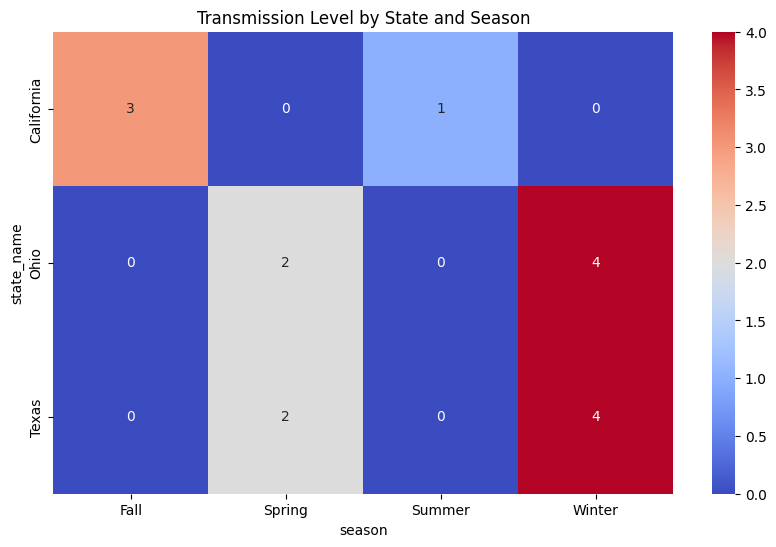

In [13]:
# Sample DataFrame with real U.S. states
data = pd.DataFrame({
    'state_name': ['Ohio', 'Ohio', 'California', 'California', 'Texas', 'Texas'],
    'season': ['Winter', 'Spring', 'Summer', 'Fall', 'Winter', 'Spring'],
    'transmission_level': ['High', 'Moderate', 'Low', 'Substantial', 'High', 'Moderate']
})

# Pivot the data to create a matrix suitable for a heatmap
pivot_data = data.pivot_table(index='state_name', columns='season', values='transmission_level', aggfunc='first')

# Display the pivoted data (just for reference)
print(pivot_data)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data.applymap(lambda x: {'High': 4, 'Substantial': 3, 'Moderate': 2, 'Low': 1}.get(x, 0)),
            annot=True, cmap='coolwarm', cbar=True, xticklabels=True, yticklabels=True)

# Show the plot
plt.title('Transmission Level by State and Season')
plt.show()

In [67]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')

#data = pd.DataFrame({
 #   'state_name': ['Ohio', 'Ohio', 'California', 'California', 'Texas', 'Texas'],
  ## 'transmission_level': ['High', 'Moderate', 'Low', 'Substantial', 'High', 'Moderate']
#})
query = ("""
SELECT 
    state_name, 
    date, 
    transmission_level, 
FROM 
    trans_level
GROUP BY 
    state_name, date, transmission_level
ORDER BY 
    date, state_name;
    """)

#Map dates to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Add a 'season' column
#data['season'] = data['date'].dt.month.apply(get_season)

# Group by state and season, and for each group select the transmission level (no counting)
seasonal_data = data.groupby(['state_name', 'season'])['transmission_level'].first().reset_index()

# Pivot the data for heatmap
heatmap_data = data.pivot_table(
    index='state_name', 
    columns='season',
    values='transmission_level',
    aggfunc='first'
    #aggfunc=lambda x: ', '.join(x)  # To preserve the categories in each cell
)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data.map(lambda x: {'High': 4, 'Substantial': 3, 'Moderate': 2, 'Low': 1}.get(x, 0)),
            annot=True, cmap='coolwarm', cbar=True, xticklabels=True, yticklabels=True)

# Plot the heatmap
#plt.figure(figsize=(10, 8))
#sns.heatmap(
 #  annot=True,
  #  fmt='s',  # Show string categories in the cells
   #linewidths=0.5,
    #cbar=False,  # No color bar since we are using categorical data
#)

# Adjust the title and labels
plt.title("Seasonal COVID-19 Transmission Levels by State", fontsize=16, pad=20)
plt.xlabel("Season", fontsize=12, labelpad=10)
plt.ylabel("State", fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)

plt.tight_layout()
plt.show()

KeyError: 'Column not found: transmission_level'

C:\Users\weare\AppData\Local\Temp\ipykernel_18836\1740310886.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(pivot_data.applymap(lambda x: {'High': 4, 'Substantial': 3, 'Moderate': 2, 'Low': 1}.get(x, 0)),


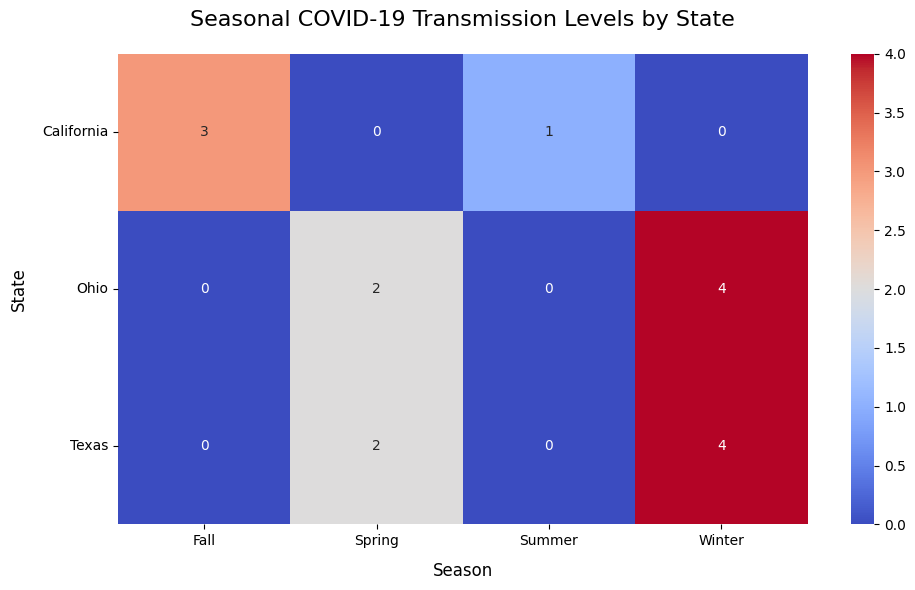

In [23]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')

#data = pd.DataFrame({
 #   'state_name': ['Ohio', 'Ohio', 'California', 'California', 'Texas', 'Texas'],
  ## 'transmission_level': ['High', 'Moderate', 'Low', 'Substantial', 'High', 'Moderate']
})
    

query = ("""
SELECT 
    state_name, 
    date, 
    transmission_level, 
FROM 
    trans_level
GROUP BY 
    state_name, date, transmission_level
ORDER BY 
    date, state_name;
    """)

#Map dates to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Add a 'season' column
#data['season'] = data['date'].dt.month.apply(get_season)

# Group by state and season, and for each group select the transmission level (no counting)
seasonal_data = data.groupby(['state_name', 'season'])['transmission_level'].first().reset_index()

# Pivot the data for heatmap
heatmap_data = data.pivot_table(
    index='state_name', 
    columns='season',
    values='transmission_level',
    aggfunc='first'
    #aggfunc=lambda x: ', '.join(x)  # To preserve the categories in each cell
)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data.applymap(lambda x: {'High': 4, 'Substantial': 3, 'Moderate': 2, 'Low': 1}.get(x, 0)),
            annot=True, cmap='coolwarm', cbar=True, xticklabels=True, yticklabels=True)

# Plot the heatmap
#plt.figure(figsize=(10, 8))
#sns.heatmap(
 #  annot=True,
  #  fmt='s',  # Show string categories in the cells
   #linewidths=0.5,
    #cbar=False,  # No color bar since we are using categorical data
#)

# Adjust the title and labels
plt.title("Seasonal COVID-19 Transmission Levels by State", fontsize=16, pad=20)
plt.xlabel("Season", fontsize=12, labelpad=10)
plt.ylabel("State", fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)

plt.tight_layout()
plt.show()

The heatmap indicates variations in COVID-19 transmission levels across states during different seasons:

Fall: Transmission levels are generally high in many states, with Texas showing the most intense activity. This suggests increased spread during this season, potentially due to indoor gatherings as temperatures cool.

Winter: Transmission levels remain elevated in some states, but overall intensity appears lower than in Fall. Winter often coincides with holiday travel and gatherings, which may sustain moderate transmission.

Spring: Transmission levels begin to decline across most states, likely due to warming weather and more outdoor activities reducing close contact.

Summer: Transmission levels are lowest in this season, as warmer weather and reduced indoor crowding likely help limit the spread of the virus.

The pattern reflects how seasonality and human behaviors impact COVID-19 transmission.

In [63]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')
print(Covid_rates)

  outcome     month Age group  Vaccinated with outcome  \
0    case  APR 2021     12-17                        8   
1    case  APR 2021     18-29                      674   
2    case  APR 2021     30-49                     1847   
3    case  APR 2021     50-64                     1558   
4    case  APR 2021     65-79                     1672   

   Unvaccinated with outcome  
0                      30785  
1                      76736  
2                      98436  
3                      50324  
4                      14880  


In [64]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')

# Merge the datasets on the 'date' columns
merged_data = pd.merge(Covid_rates, trans_level, on=['month'], how='left')
                    
print(merged_data.head())

KeyError: 'month'

In [69]:
print(merged_data.shape)

(5, 19)


In [70]:
merged_data.isnull().sum()

outcome                                               0
date                                                  0
MMWR week                                             0
Age group                                             0
Vaccine product                                       0
Vaccinated with outcome                               0
Fully vaccinated population                           0
Unvaccinated with outcome                             0
Unvaccinated population                               0
Crude vax IR                                          0
Crude unvax IR                                        0
Crude IRR                                             0
Continuity correction                                 0
state_name                                            5
county_name                                           5
fips_code                                             5
cases_per_100K_7_day_count_change                     5
percent_test_results_reported_positive_last_7_da

In [86]:
merged_data.describe()

,MMWR week,Vaccinated with outcome,Fully vaccinated population,Unvaccinated with outcome,Unvaccinated population,Crude vax IR,Crude unvax IR,Crude IRR,Continuity correction,fips_code,cases_per_100K_7_day_count_change,percent_test_results_reported_positive_last_7_days
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
merged_data.duplicated().sum()

np.int64(0)

In [78]:
merged_data.head(5)

,outcome,date,MMWR week,Age group,Vaccine product,Vaccinated with outcome,Fully vaccinated population,Unvaccinated with outcome,Unvaccinated population,Crude vax IR,Crude unvax IR,Crude IRR,Continuity correction,state_name,county_name,fips_code,cases_per_100K_7_day_count_change,percent_test_results_reported_positive_last_7_days,community_transmission_level
